# Coronavirus (COVID-19) Outbreak Peak Prediction by Machine Learning
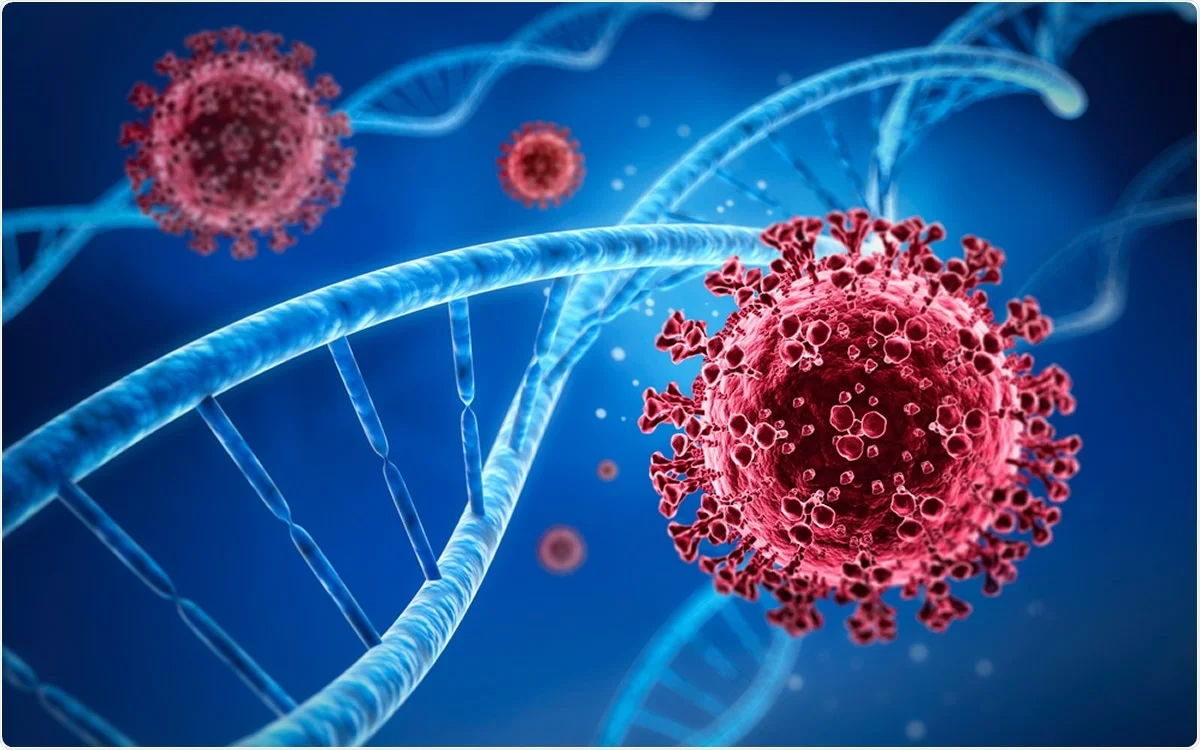

# I. Introduction
Coronavirus is a family of viruses that are named after their spiky crown. The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 2/11/2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. This notebook aims at exploring COVID-19 through data analysis and pandemic peak trend prediction using Machine Learning methodologies. Outbreak Forecast uses machine learning to combine time series data with additional variables to build forecasts.

The study period covers California and United States from 1/22/2020 to 8/17/2021:

• 	Daily new confirmed cases
• 	Total Accumulated confimed cases

Machine Learning Models used in the study include following:
1.	SVM
2.	Polynomial Regression
3.	Bayesian Ridge Polynomial Regression
4.	Time Series- LSTM
5.	Time Series- ARIMA

Coronavirus Case Data is provided by Johns Hopkins University: https://github.com/CSSEGISandData/COVID-19

Visualizations mapping from JHU CCSE Dashboard https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

Source code is on my Github


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

# Here are the Data Source

In [2]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_CA.csv')

In [3]:
confirmed_df

UID iso2 iso3  code3   FIPS           Admin2 Province_State  \
0   84006001   US  USA    840   6001          Alameda     California   
1   84006003   US  USA    840   6003           Alpine     California   
2   84006005   US  USA    840   6005           Amador     California   
3   84006007   US  USA    840   6007            Butte     California   
4   84006009   US  USA    840   6009        Calaveras     California   
5   84006011   US  USA    840   6011           Colusa     California   
6   84006013   US  USA    840   6013     Contra Costa     California   
7   84006015   US  USA    840   6015        Del Norte     California   
8   84006017   US  USA    840   6017        El Dorado     California   
9   84006019   US  USA    840   6019           Fresno     California   
10  84006021   US  USA    840   6021            Glenn     California   
11  84006023   US  USA    840   6023         Humboldt     California   
12  84006025   US  USA    840   6025         Imperial     California   
13  84006027   US  USA    840   6027             Inyo     California   
14  84006029   US  USA    840   6029             Kern     California   
15  84006031   US  USA    840   6031            Kings     California   
16  84006033   US  USA    840   6033             Lake     California   
17  84006035   US  USA    840   6035           Lassen     California   
18  84006037   US  USA    840   6037      Los Angeles     California   
19  84006039   US  USA    840   6039           Madera     California   
20  84006041   US  USA    840   6041            Marin     California   
21  84006043   US  USA    840   6043         Mariposa     California   
22  84006045   US  USA    840   6045        Mendocino     California   
23  84006047   US  USA    840   6047           Merced     California   
24  84006049   US  USA    840   6049            Modoc     California   
25  84006051   US  USA    840   6051             Mono     California   
26  84006053   US  USA    840   6053         Monterey     California   
27  84006055   US  USA    840   6055             Napa     California   
28  84006057   US  USA    840   6057           Nevada     California   
29  84006059   US  USA    840   6059           Orange     California   
30  84080006   US  USA    840  80006        Out of CA     California   
31  84006061   US  USA    840   6061           Placer     California   
32  84006063   US  USA    840   6063           Plumas     California   
33  84006065   US  USA    840   6065        Riverside     California   
34  84006067   US  USA    840   6067       Sacramento     California   
35  84006069   US  USA    840   6069       San Benito     California   
36  84006071   US  USA    840   6071   San Bernardino     California   
37  84006073   US  USA    840   6073        San Diego     California   
38  84006075   US  USA    840   6075    San Francisco     California   
39  84006077   US  USA    840   6077      San Joaquin     California   
40  84006079   US  USA    840   6079  San Luis Obispo     California   
41  84006081   US  USA    840   6081        San Mateo     California   
42  84006083   US  USA    840   6083    Santa Barbara     California   
43  84006085   US  USA    840   6085      Santa Clara     California   
44  84006087   US  USA    840   6087       Santa Cruz     California   
45  84006089   US  USA    840   6089           Shasta     California   
46  84006091   US  USA    840   6091           Sierra     California   
47  84006093   US  USA    840   6093         Siskiyou     California   
48  84006095   US  USA    840   6095           Solano     California   
49  84006097   US  USA    840   6097           Sonoma     California   
50  84006099   US  USA    840   6099       Stanislaus     California   
51  84006101   US  USA    840   6101           Sutter     California   
52  84006103   US  USA    840   6103           Tehama     California   
53  84006105   US  USA    840   6105          Trinity     California   
54  84006107   US  USA    840   6107           Tu

In [4]:
cols = confirmed_df.keys()

In [5]:
confirmed = confirmed_df.loc[:, cols[11]:cols[-1]]

In [6]:
dates = confirmed.keys()
total_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    total_cases.append(confirmed_sum)


In [7]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average


In [8]:
window = 7

In [9]:
# confirmed cases
total_case_avg= moving_average(total_cases, window)
daily_cases = daily_increase(total_cases)
daily_case_avg = moving_average(daily_cases, window)

# II. Current COVID-19 Pandemic Data Analysis

In [10]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_cases = np.array(total_cases).reshape(-1, 1)

In [11]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [12]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

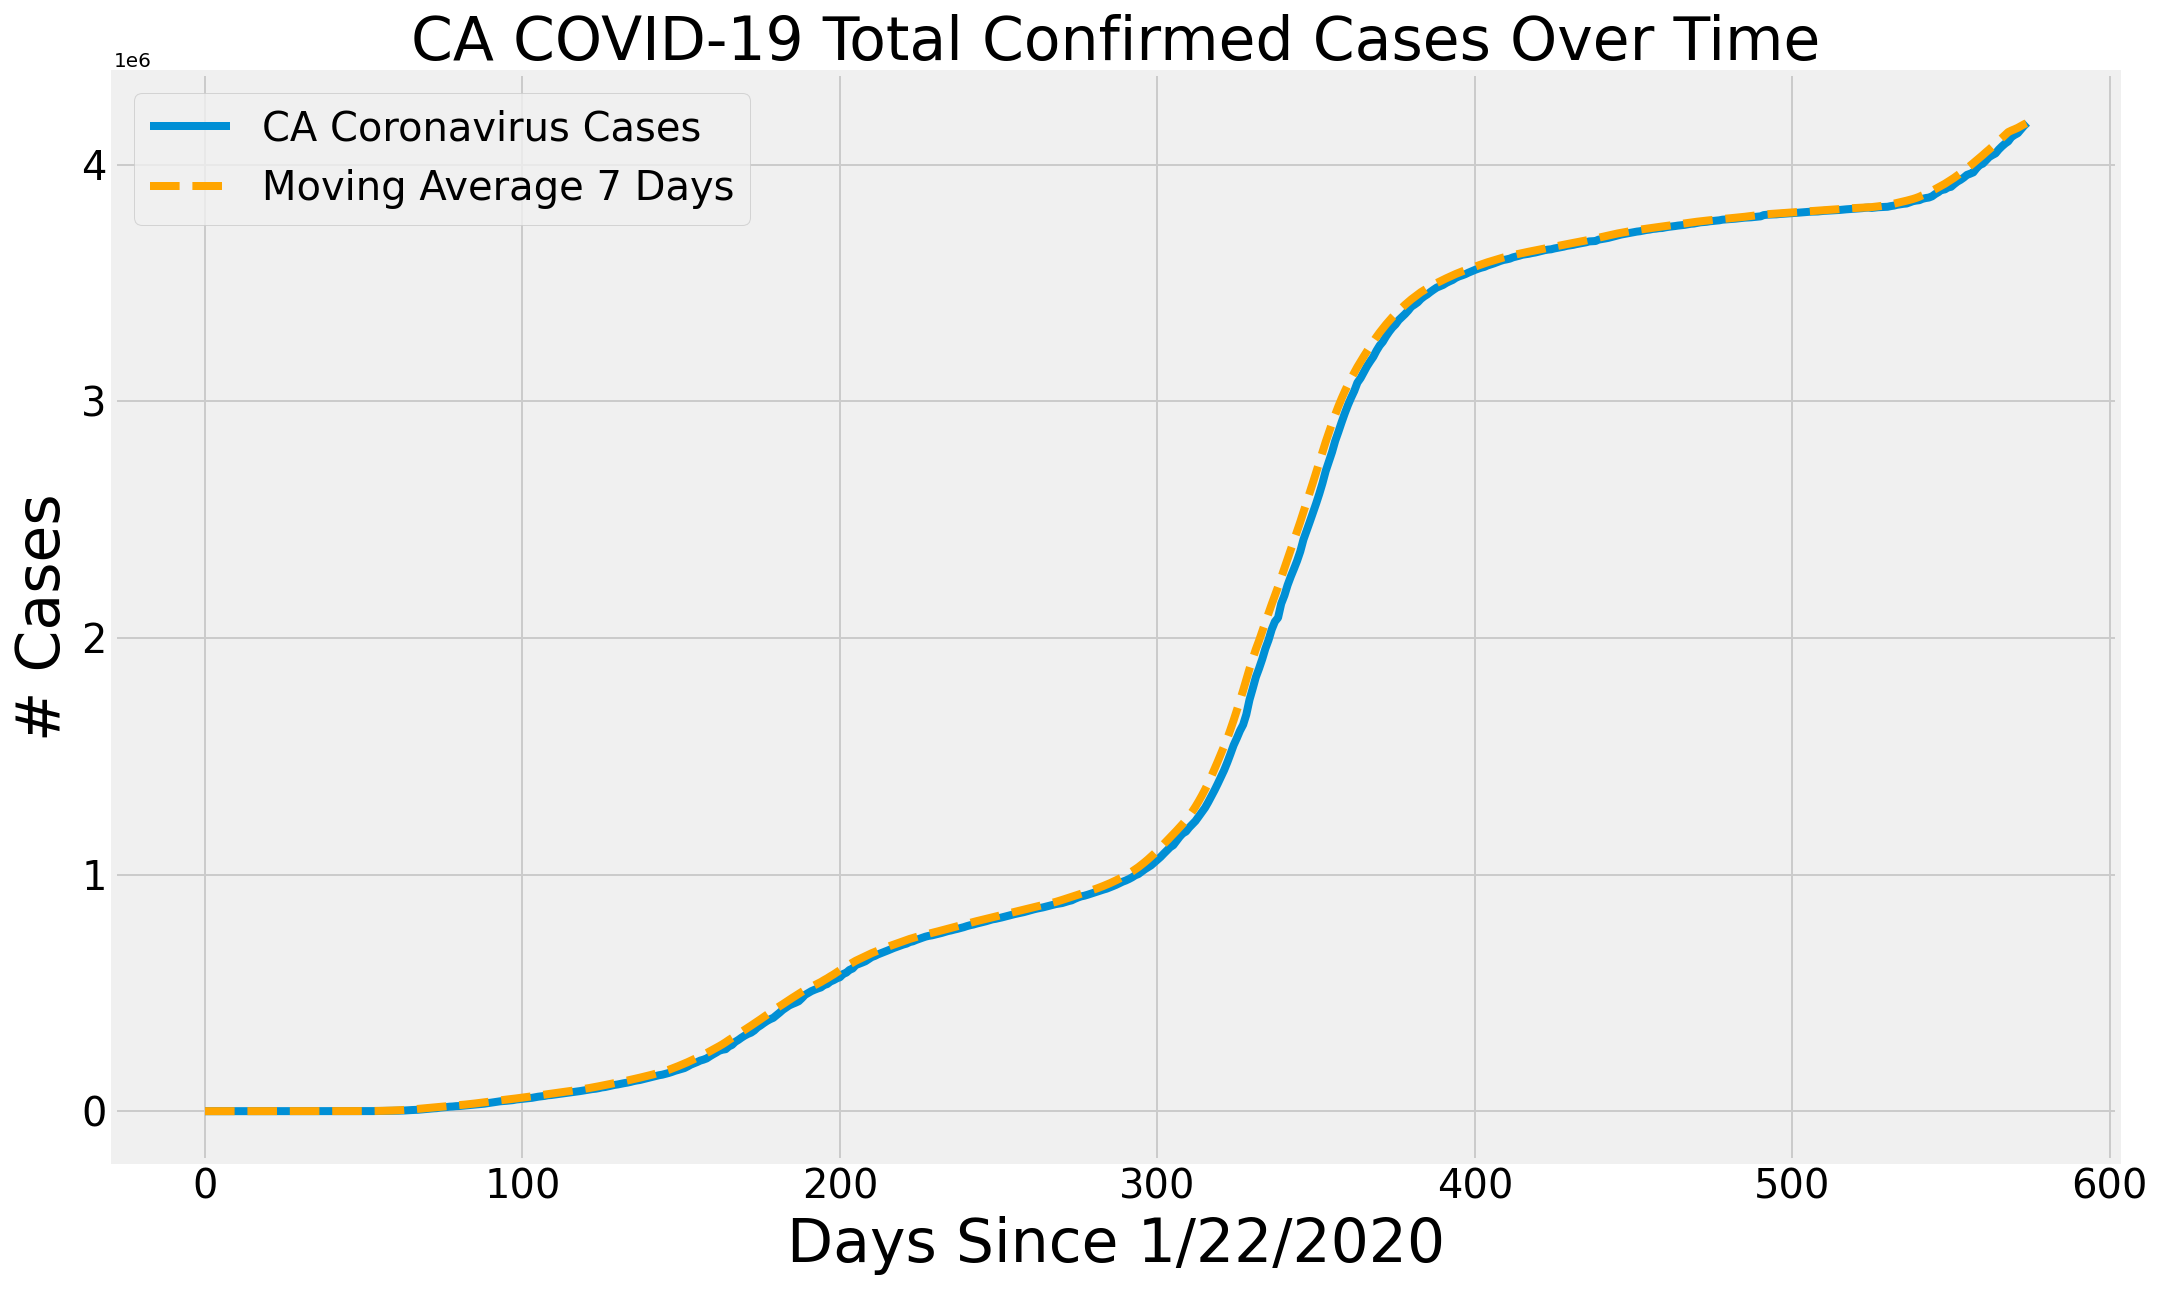

In [13]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_cases)
plt.plot(adjusted_dates, total_case_avg, linestyle='dashed', color='orange')
plt.title('CA COVID-19 Total Confirmed Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# Cases', size=30)
plt.legend(['CA Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


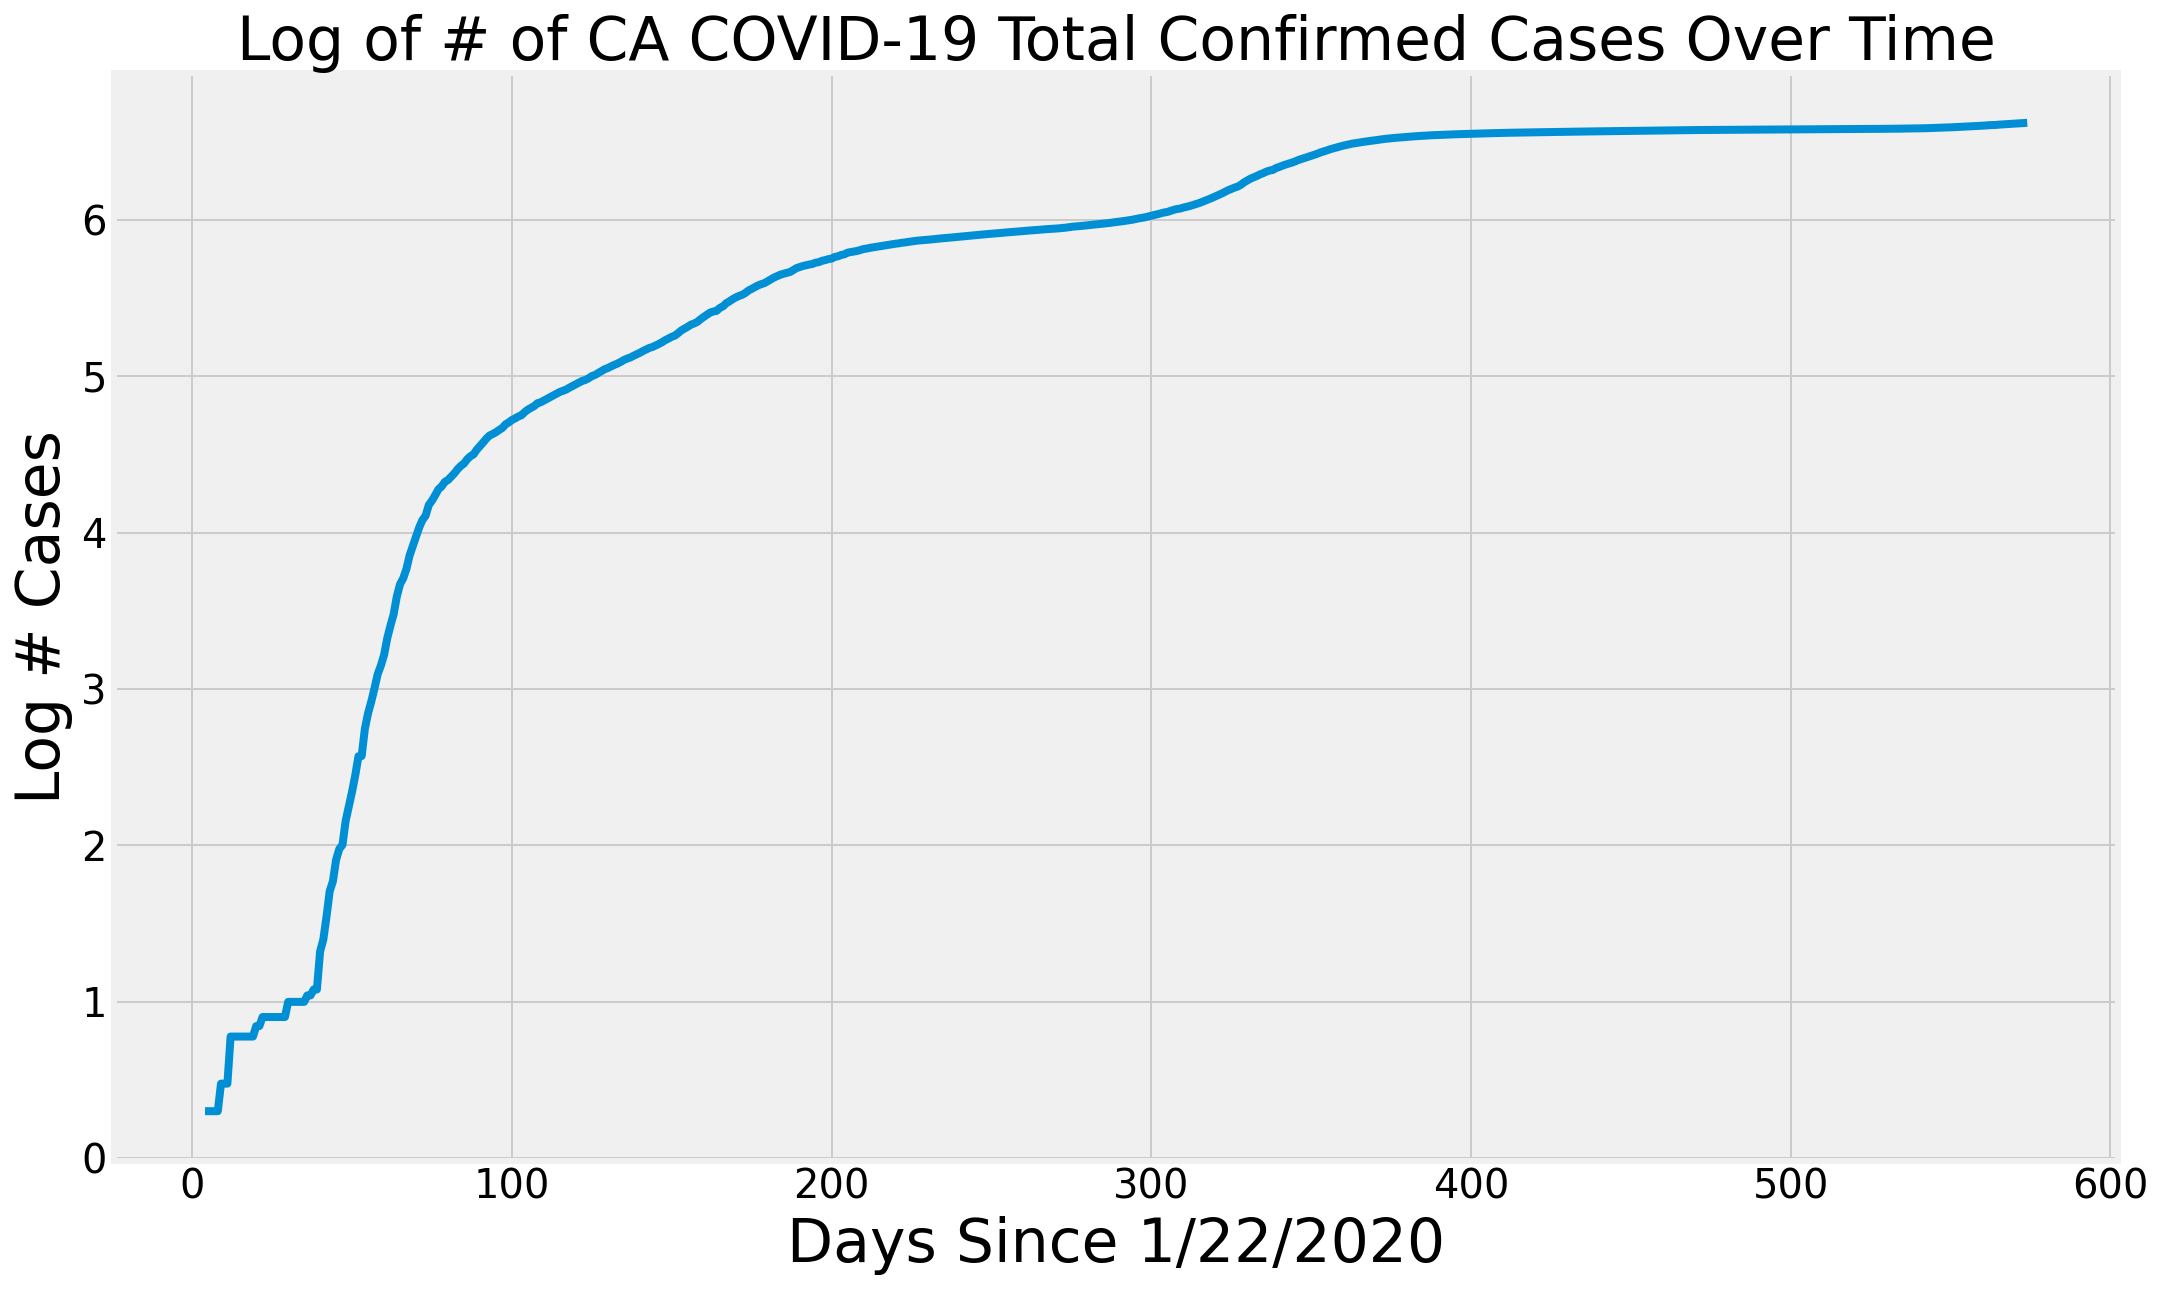

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_cases))
plt.title('Log of # of CA COVID-19 Total Confirmed Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Log # Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


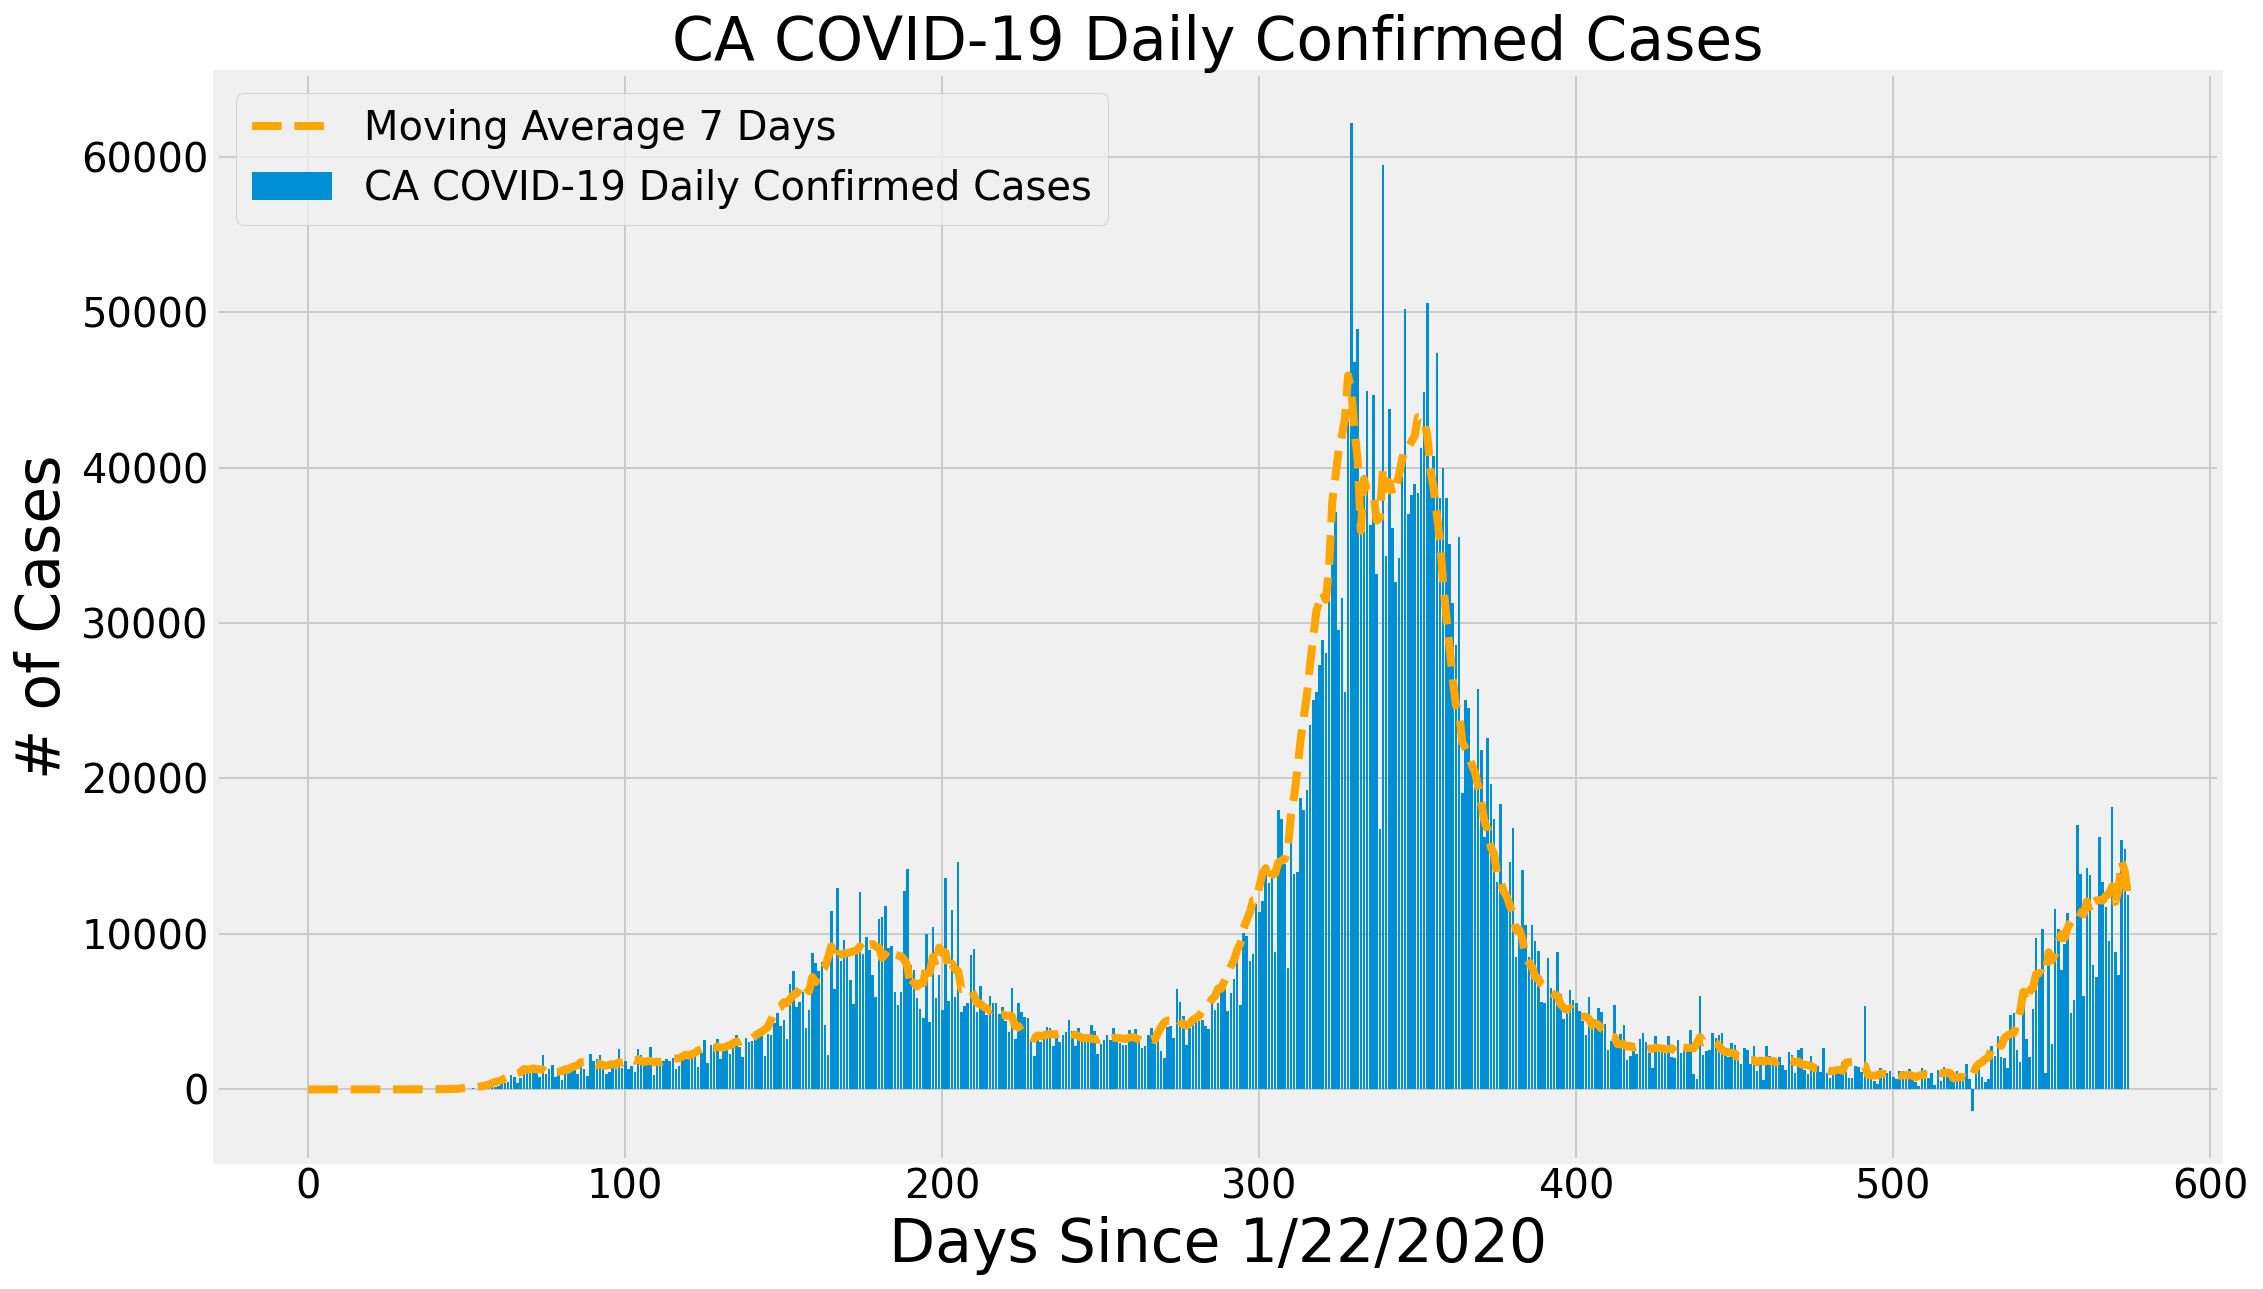

In [15]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, daily_cases)
plt.plot(adjusted_dates, daily_case_avg, color='orange', linestyle='dashed')
plt.title('CA COVID-19 Daily Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'CA COVID-19 Daily Confirmed Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


# III. COVID-19 Pandemic Peak Trend Prediction

# 1. SVM Model

In [16]:
# Decide Training and Test Data Set.
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], total_cases[50:], test_size=0.5, shuffle=False)

In [17]:
#svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 1364078.7424705615
MSE: 3473109651115.476


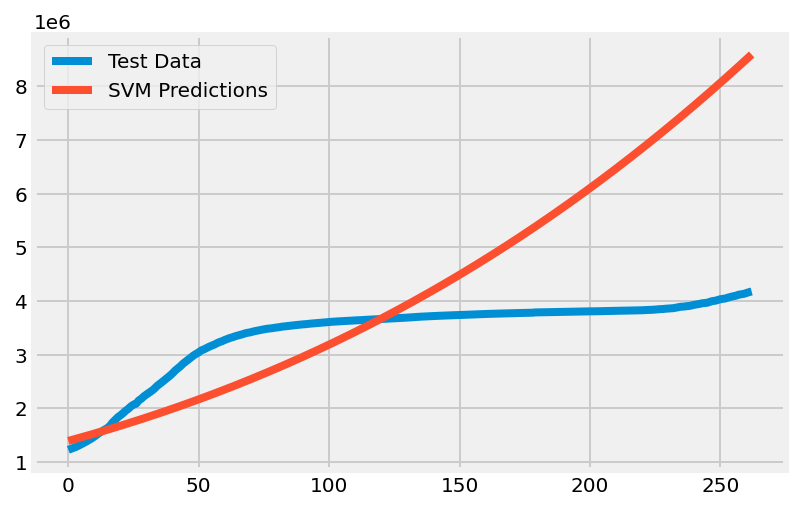

In [18]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [19]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('CA COVID-19 Total Confirmed Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

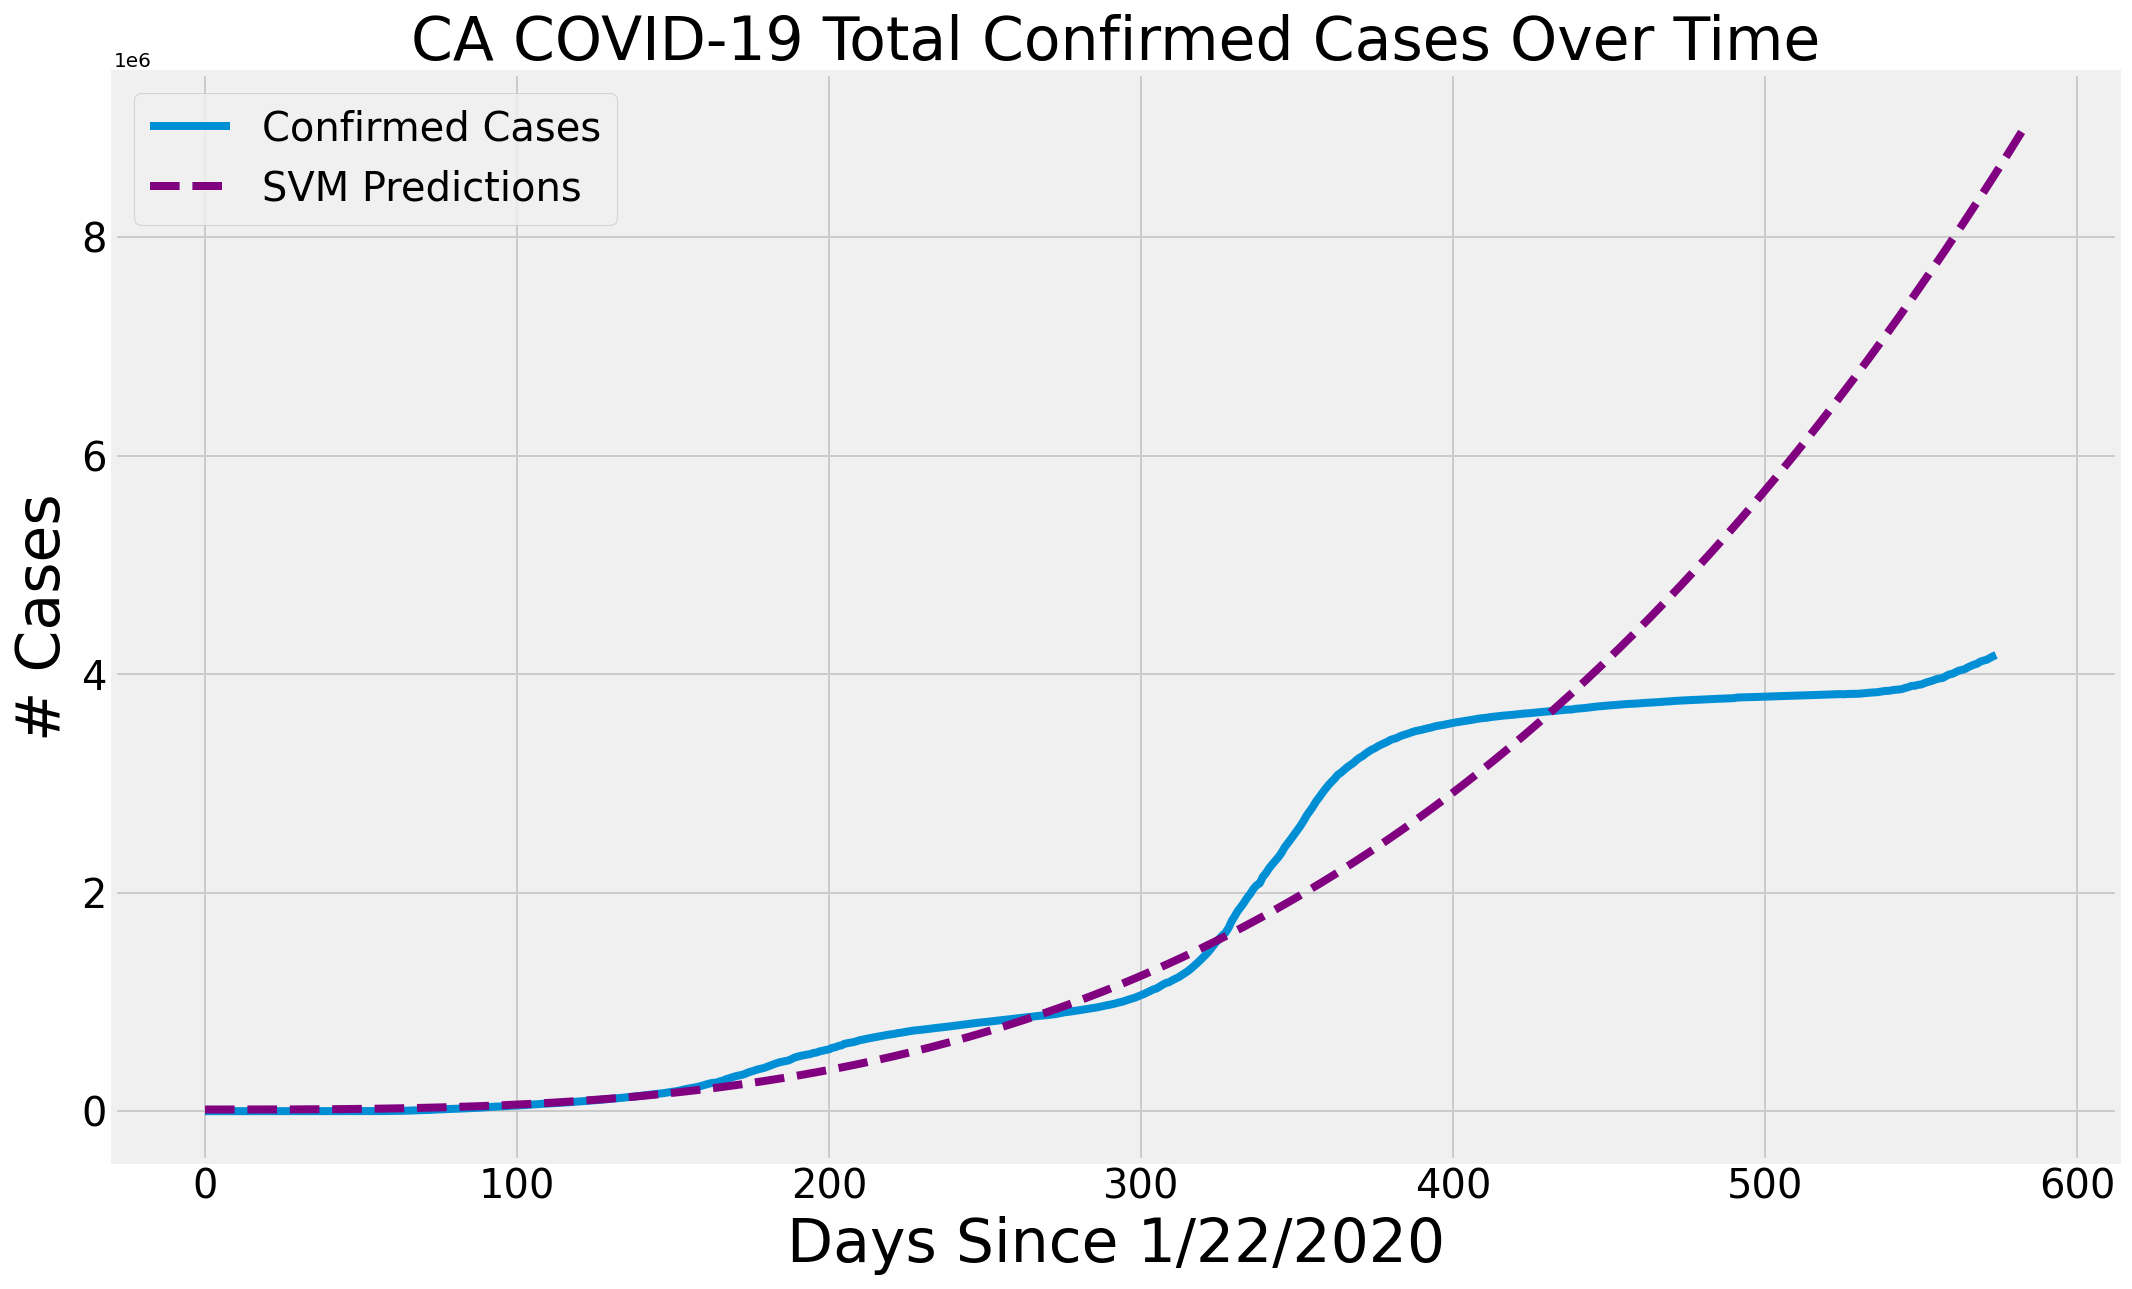

In [20]:
plot_predictions(adjusted_dates, total_cases, svm_pred, 'SVM Predictions', 'purple')

# Generate forecasts

In [21]:
# Future predictions using SVM
SVM_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'SVM Predicted # of CA Total Confirmed Cases': np.round(svm_pred[-10:])})
SVM_df.style.background_gradient(cmap='Reds')

In [22]:
SVM_df.index

RangeIndex(start=0, stop=10, step=1)

# 2. Polynomial Regression Model

In [23]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [24]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1258041.5643973972
MSE: 1993494390630.6152


In [25]:
print(linear_model.coef_)

[[ 5.93247911e+05 -1.76093291e+04  1.60155870e+02 -4.61441696e-01
   4.68298048e-04]]


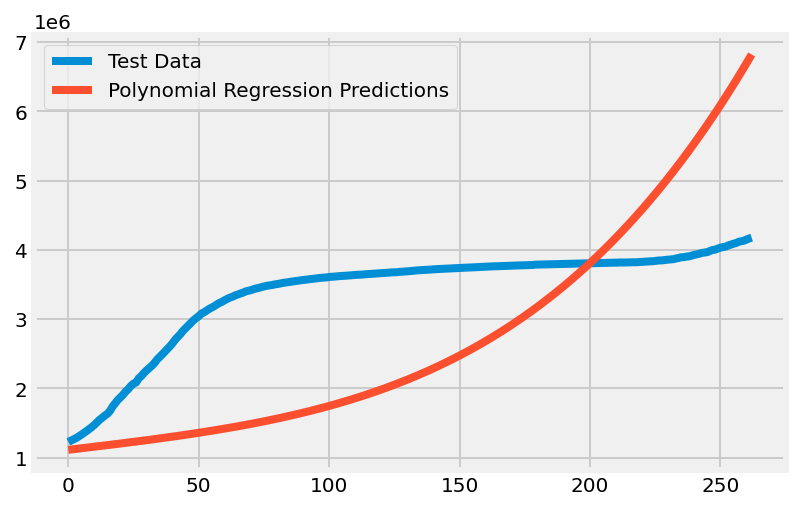

In [26]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

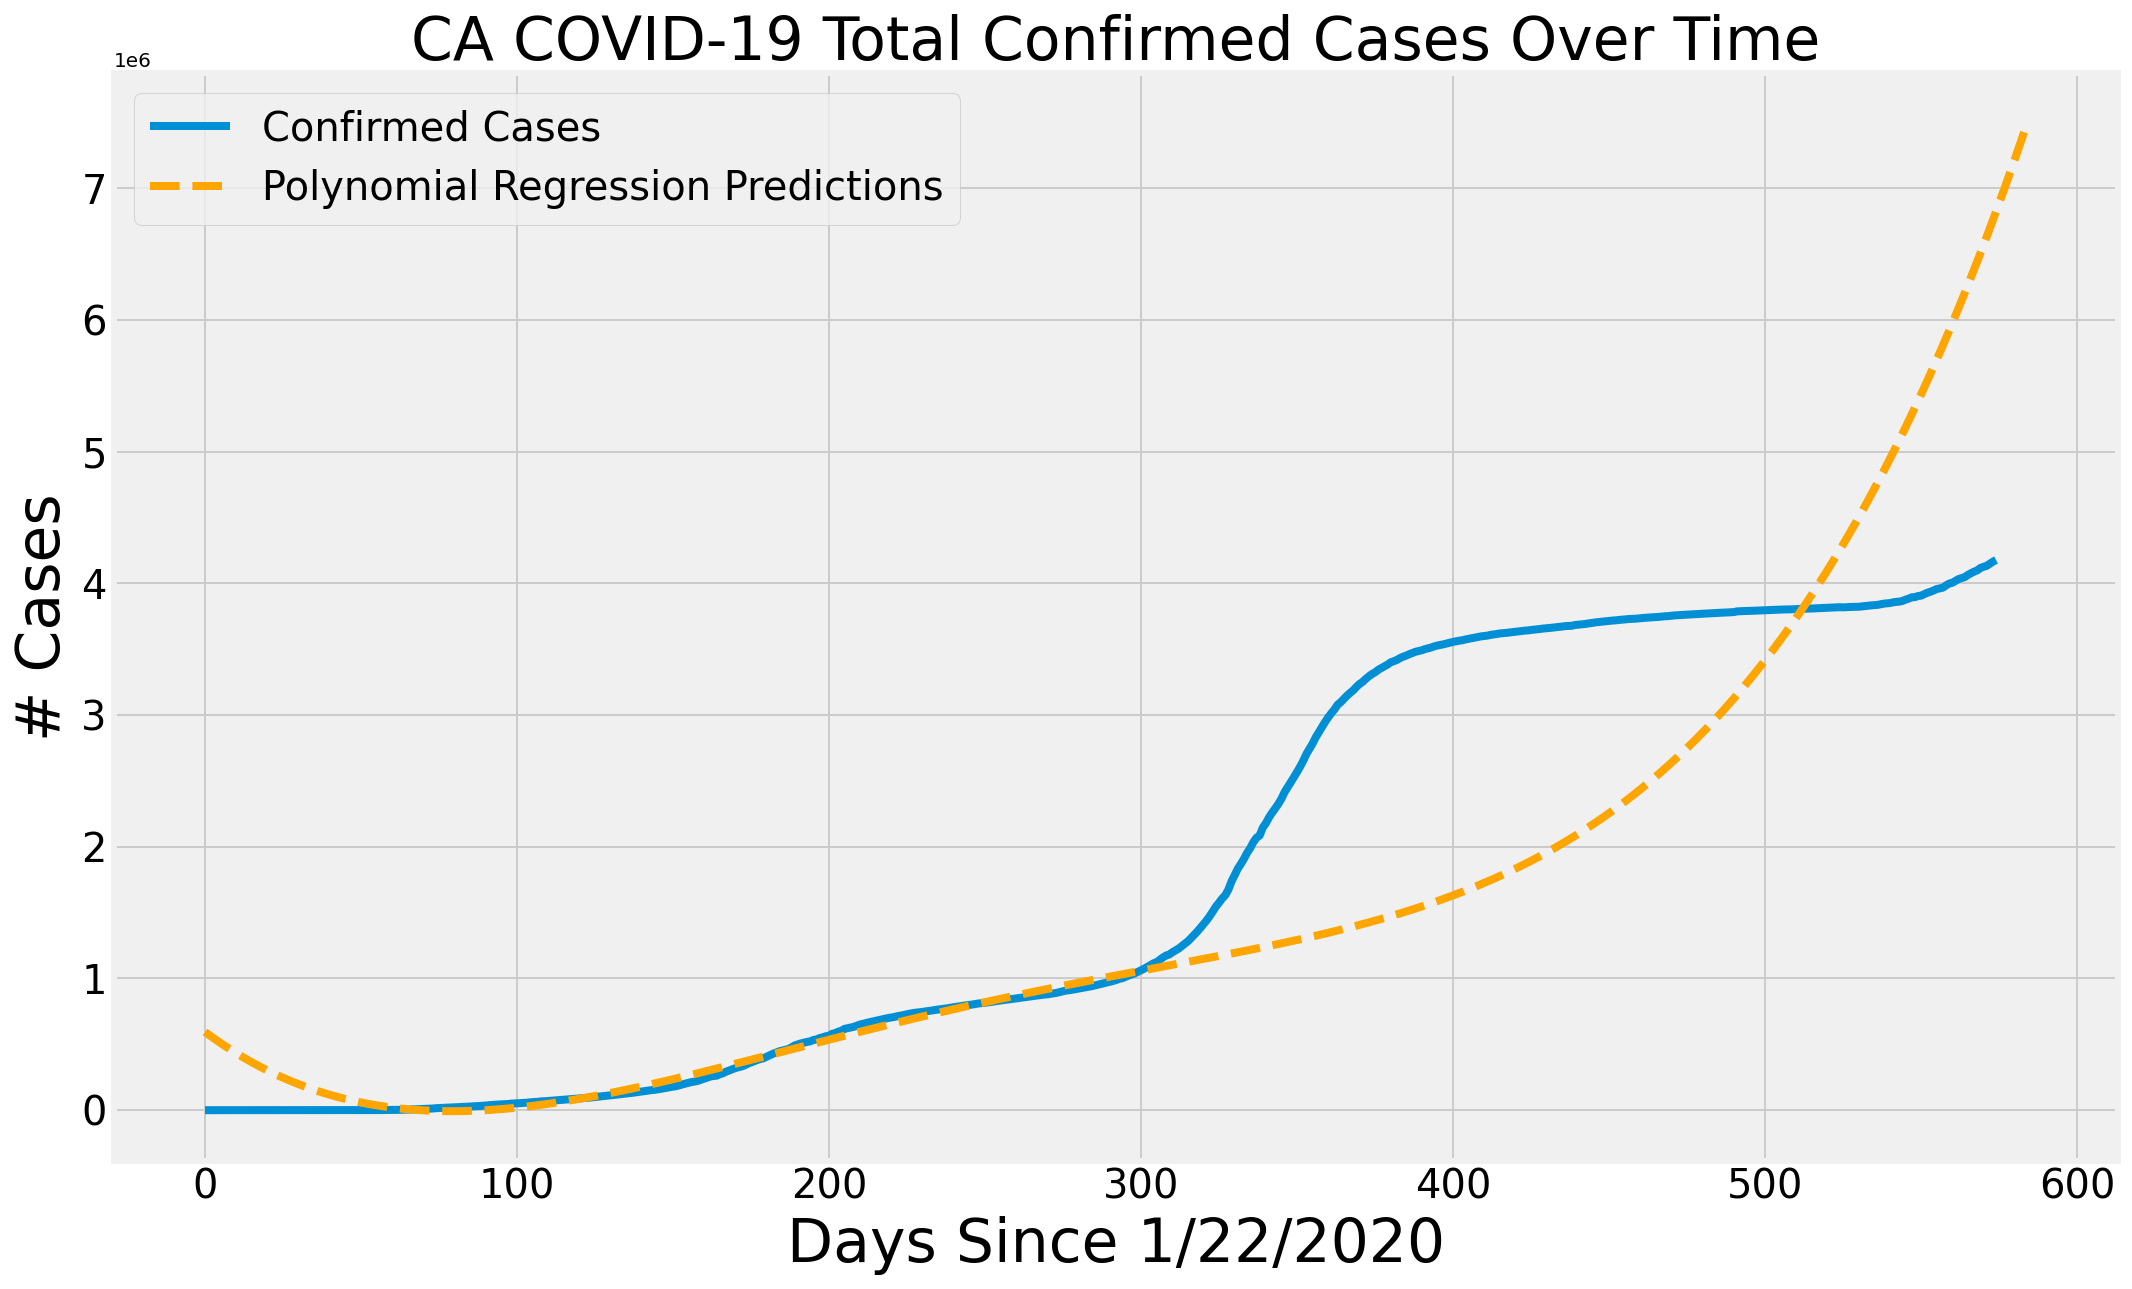

In [27]:
plot_predictions(adjusted_dates, total_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

# Generate forecasts

In [28]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'Polynomial Predicted # of CA Total Confirmed Cases': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

# 3. Bayesian Ridge Polynomial Regression Model

In [29]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.3s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [30]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': False,
 'lambda_2': 1e-06,
 'lambda_1': 0.001,
 'alpha_2': 1e-05,
 'alpha_1': 1e-05}

In [31]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 8237376.006610642
MSE: 114606006702848.61


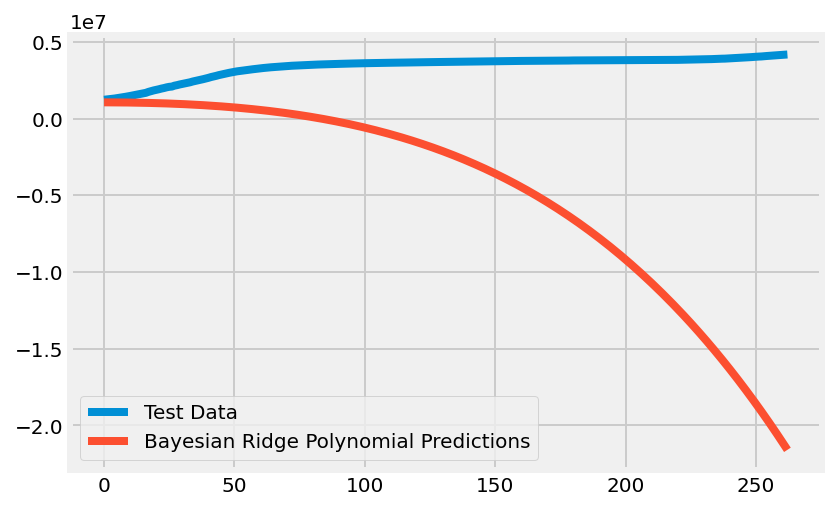

In [32]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

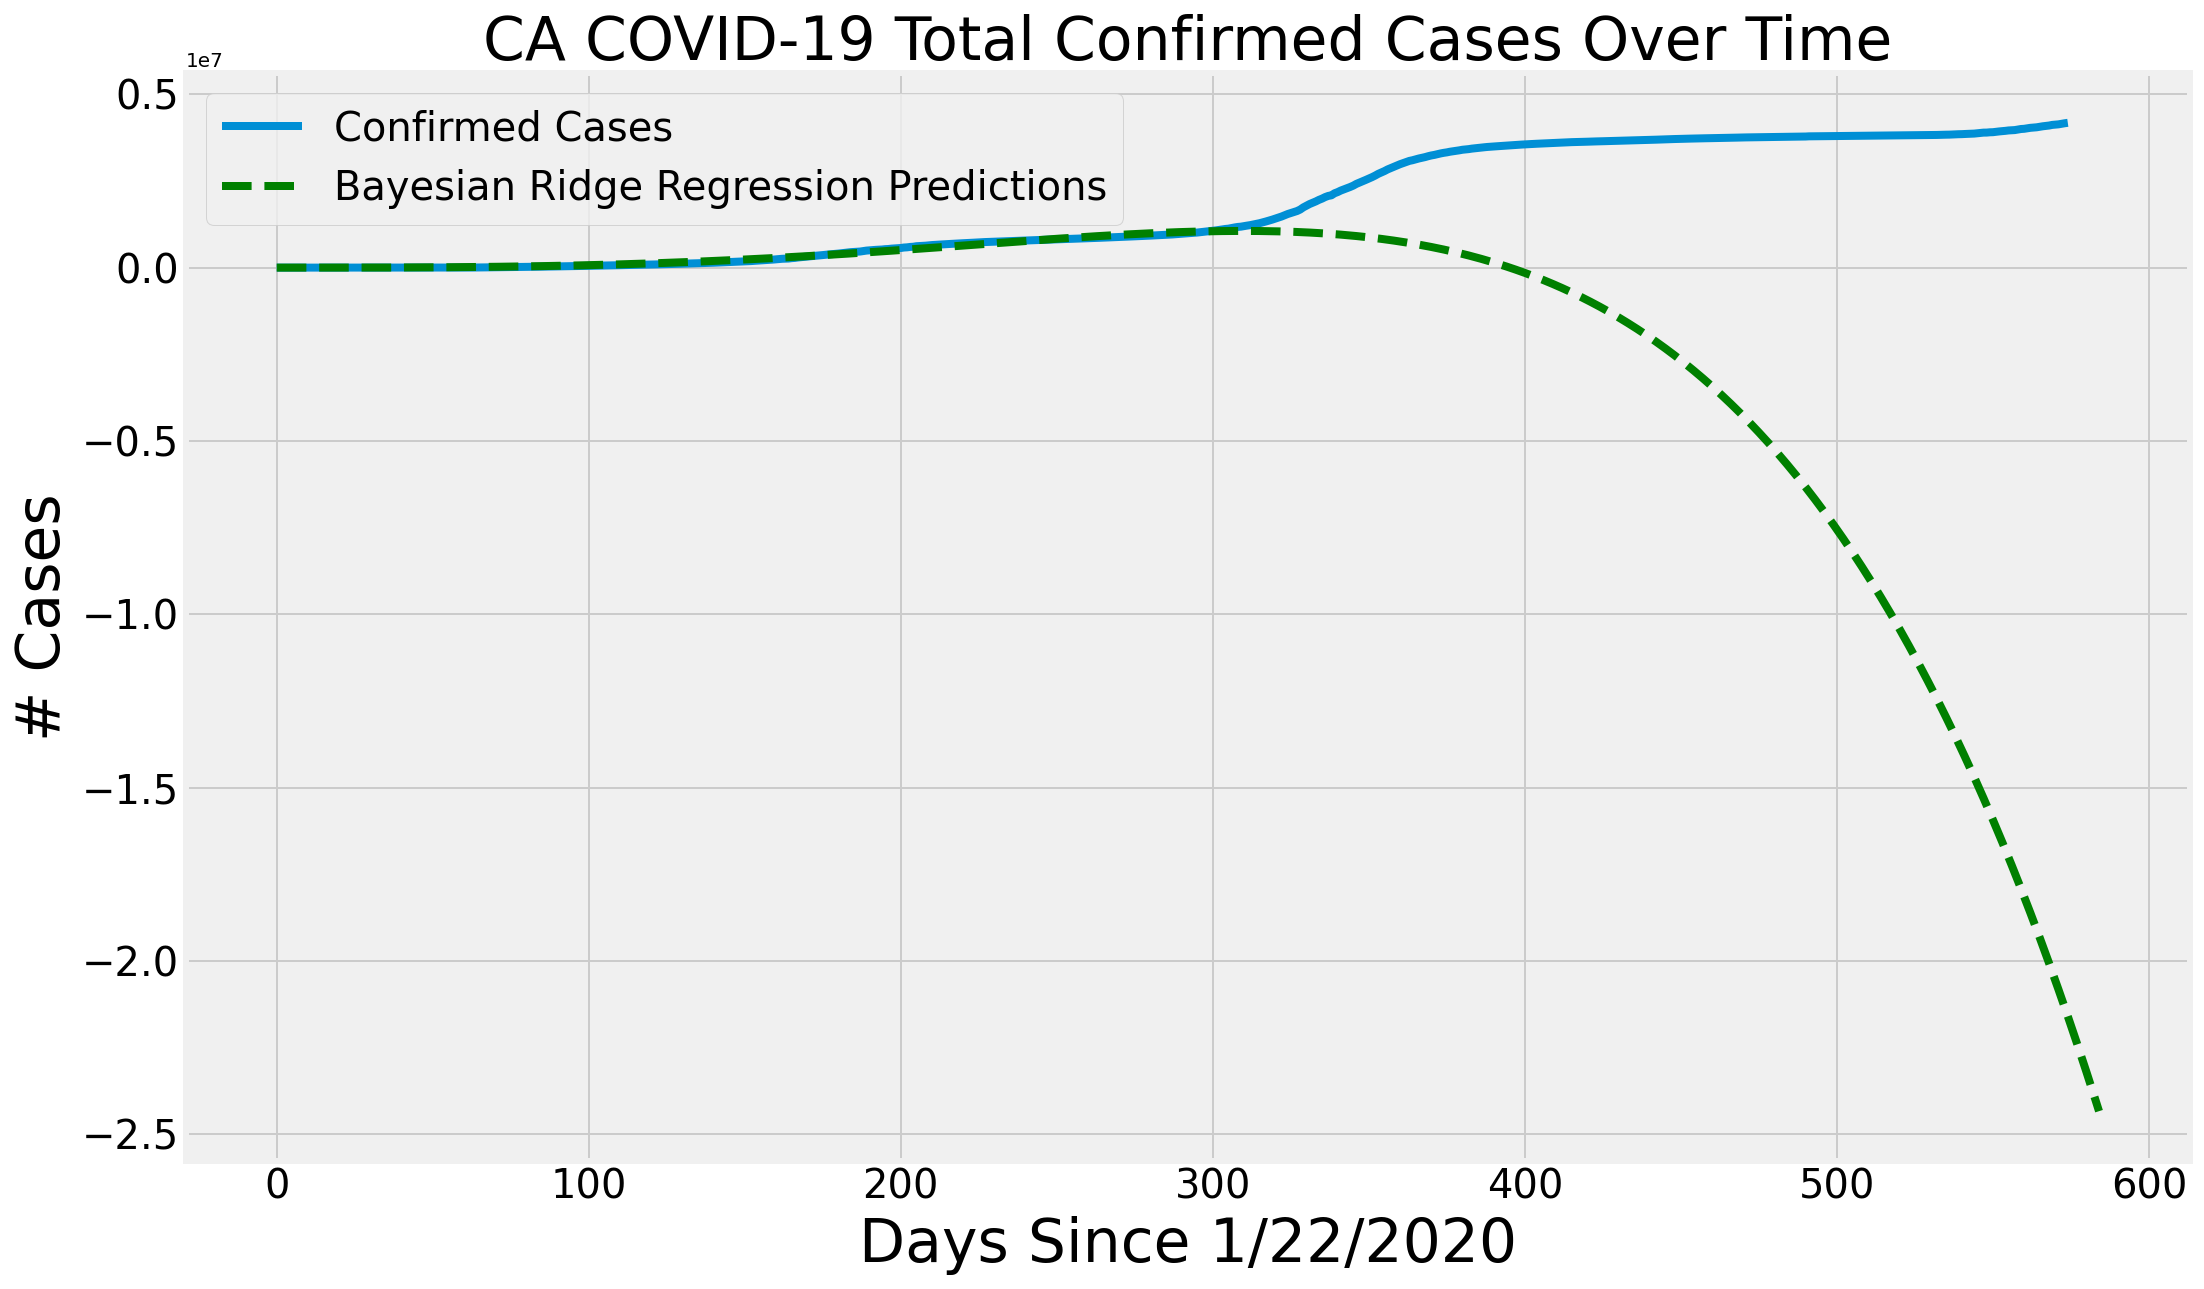

In [33]:
plot_predictions(adjusted_dates, total_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

# Generate forecasts

In [34]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of CA Total Confirmed Cases': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')

# 4. LSTM Model

In [35]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [37]:
confirmed_df = pd.read_csv("time_series_covid19_confirmed_CA_Transposed.csv")
confirmed_df.isnull().values.any()
confirmed_df = confirmed_df.dropna()

confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

Date  Alameda  Alpine  Amador  Butte  Calaveras  Colusa  \
Date                                                                       
2021-08-14  8/14/2021   101473      91    4169  14179       2564    2459   
2021-08-15  8/15/2021   101876      91    4206  14192       2579    2459   
2021-08-16  8/16/2021   102101      91    4231  14263       2599    2565   
2021-08-17  8/17/2021   102751      91    4235  14448       2609    2565   
2021-08-18  8/18/2021   103075      91    4266  14518       2624    2565   

            Contra Costa  Del Norte  El Dorado  ...  Tehama  Trinity  Tulare  \
Date                                            ...                            
2021-08-14         81823       2060      12001  ...    6214      526   51770   
2021-08-15         82150       2060      12019  ...    6214      526   51951   
2021-08-16         82440       2240      12195  ...    6214      532   52046   
2021-08-17         82850       2275      12298  ...    6214      542   52162   
2021-08-18         82850       2306      12363  ...    6214      545   52362   

            Tuolumne  Unassigned  Ventura   Yolo  Yuba      SUM  Daily  
Date                                                                    
2021-08-14      5053         107    86440  15761  7562  4124955   8834  
2021-08-15      5053          84    86569  15815  7562  4132332   7377  
2021-08-16      5148         132    86977  15877  7584  4148367  16035  
2021-08-17      5192         181    87202  15933  7737  4163848  15481  
2021-08-18      5235          73    87601  15986  7789  4176356  12508  

[5 rows x 63 columns]

# (1) Daily Confirmed Cases Prediction- CA


# Build Train-Test Datasets

In [38]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]
train_series = train_data['Daily']
test_series = test_data['Daily']
train_series.shape, test_series.shape

((345,), (230,))

# Visualize train and test data

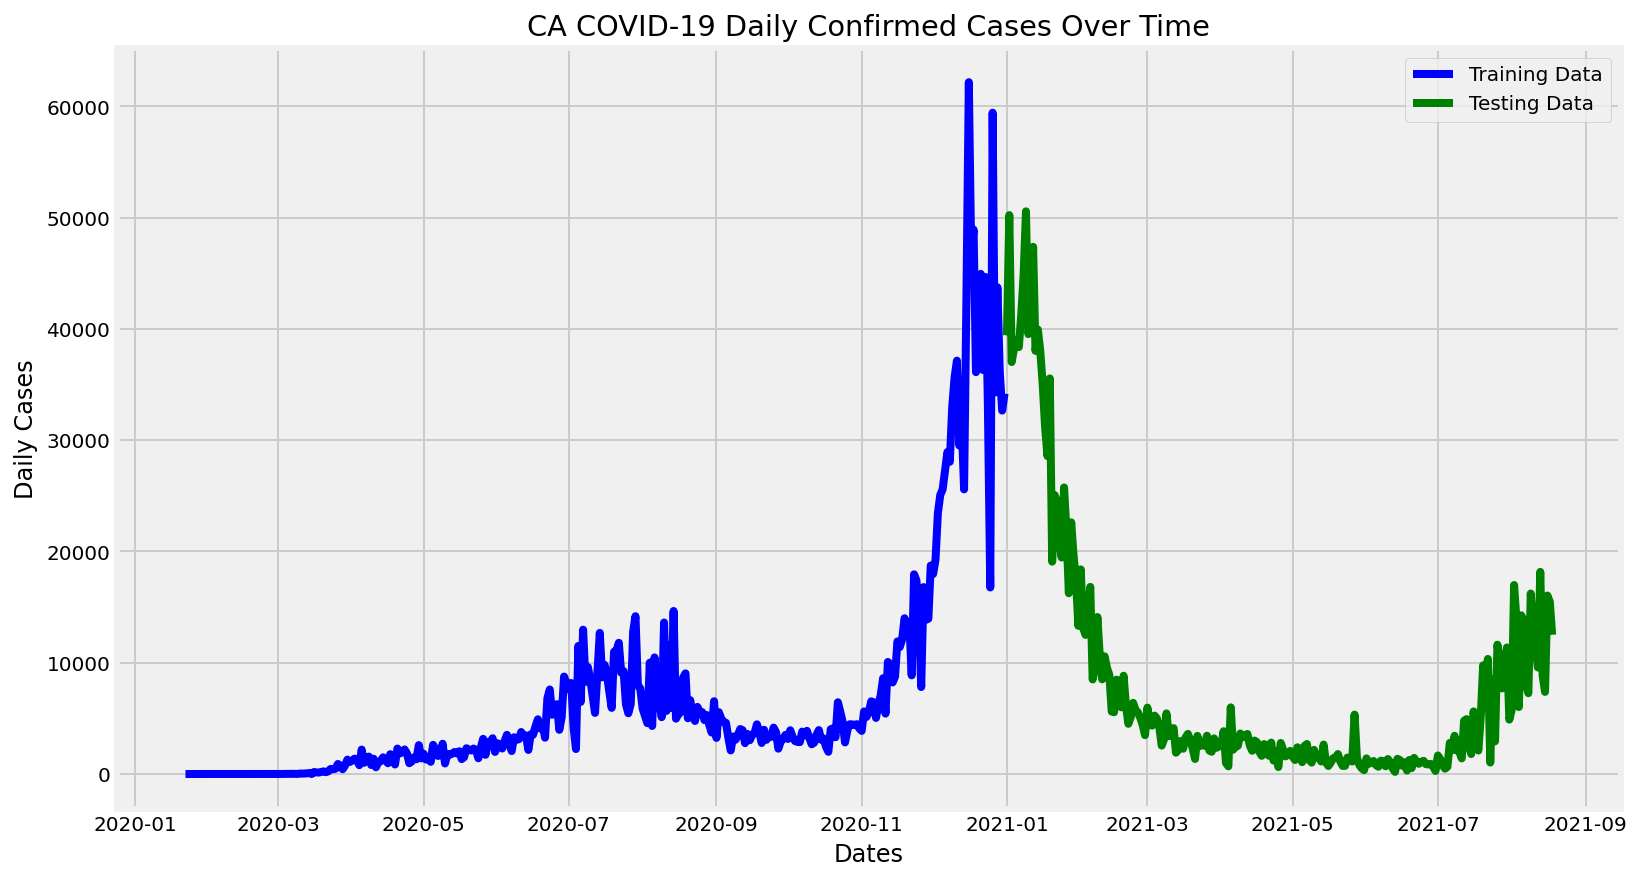

In [39]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Daily Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [40]:
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.82563377e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],


In [41]:
training_set_scaled.shape

(345, 1)

# Train Data Preparation

In [42]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((285, 60), (285,))

In [43]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [44]:
X_train.shape

(285, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [46]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [47]:
regressor.fit(X_train,y_train, epochs=10, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/10
4/4 [==============================] - 36s 929ms/step - loss: 0.0028 - val_loss: 0.1001
Epoch 2/10
4/4 [==============================] - 0s 87ms/step - loss: 0.0014 - val_loss: 0.0489
Epoch 3/10
4/4 [==============================] - 0s 89ms/step - loss: 0.0019 - val_loss: 0.0387
Epoch 4/10
4/4 [==============================] - 0s 97ms/step - loss: 0.0014 - val_loss: 0.0336
Epoch 5/10
4/4 [==============================] - 0s 97ms/step - loss: 0.0012 - val_loss: 0.0326
Epoch 6/10
4/4 [==============================] - 0s 105ms/step - loss: 0.0013 - val_loss: 0.0327
Epoch 7/10
4/4 [==============================] - 0s 105ms/step - loss: 0.0011 - val_loss: 0.0339
Epoch 8/10
4/4 [==============================] - 0s 98ms/step - loss: 0.0012 - val_loss: 0.0337
Epoch 9/10
4/4 [==============================] - 0s 105ms/step - loss: 9.6900e-04 - val_loss: 0.0353
Epoch 10/10
4/4 [==============================] - 0s 99ms/step - loss: 9.5917e-04 - val_loss: 0.0373


# Test Data Forecasting

# Get the last 60 records from train_series

In [48]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [49]:
test_series.shape

(230,)

In [50]:
print(test_series)

Date
2021-01-01    39425
2021-01-02    50222
2021-01-03    37016
2021-01-04    38256
2021-01-05    38962
              ...  
2021-08-14     8834
2021-08-15     7377
2021-08-16    16035
2021-08-17    15481
2021-08-18    12508
Name: Daily, Length: 230, dtype: int64


# Combine both train_last60 and test_series together

In [51]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(290,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [52]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [53]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(230, 60, 1)

# Model Prediction and Reverse Transform

In [54]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((230,), (230,))

# Model Evaluation

In [55]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [56]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 29739389.125
Symmetric Mean absolute percentage error: 52.060


# Visualizing the results from model predictions

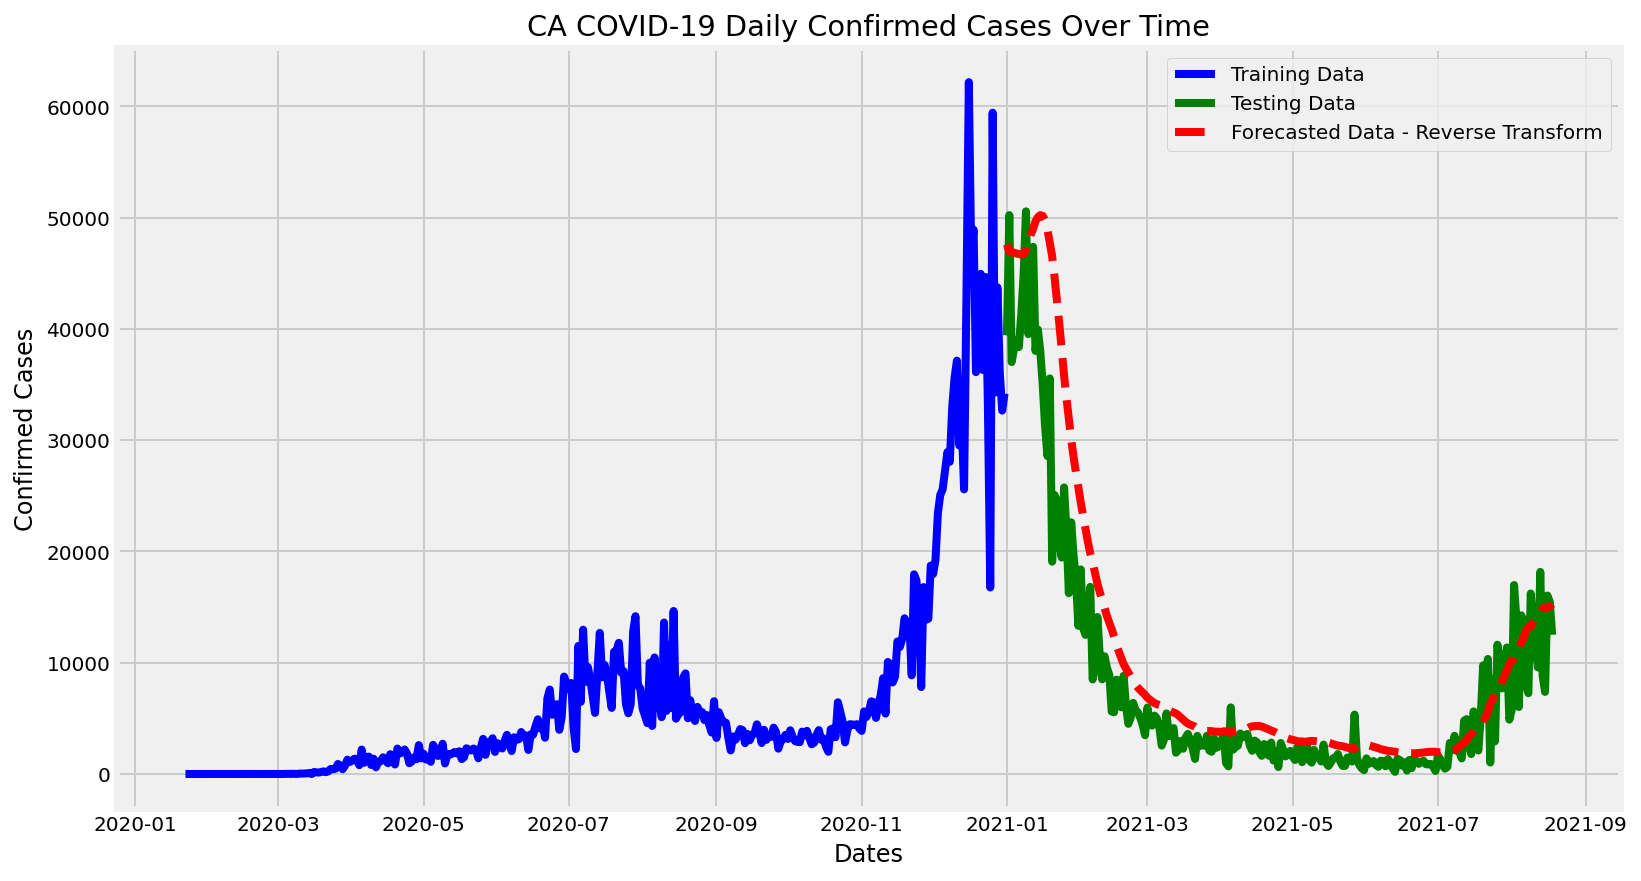

In [57]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

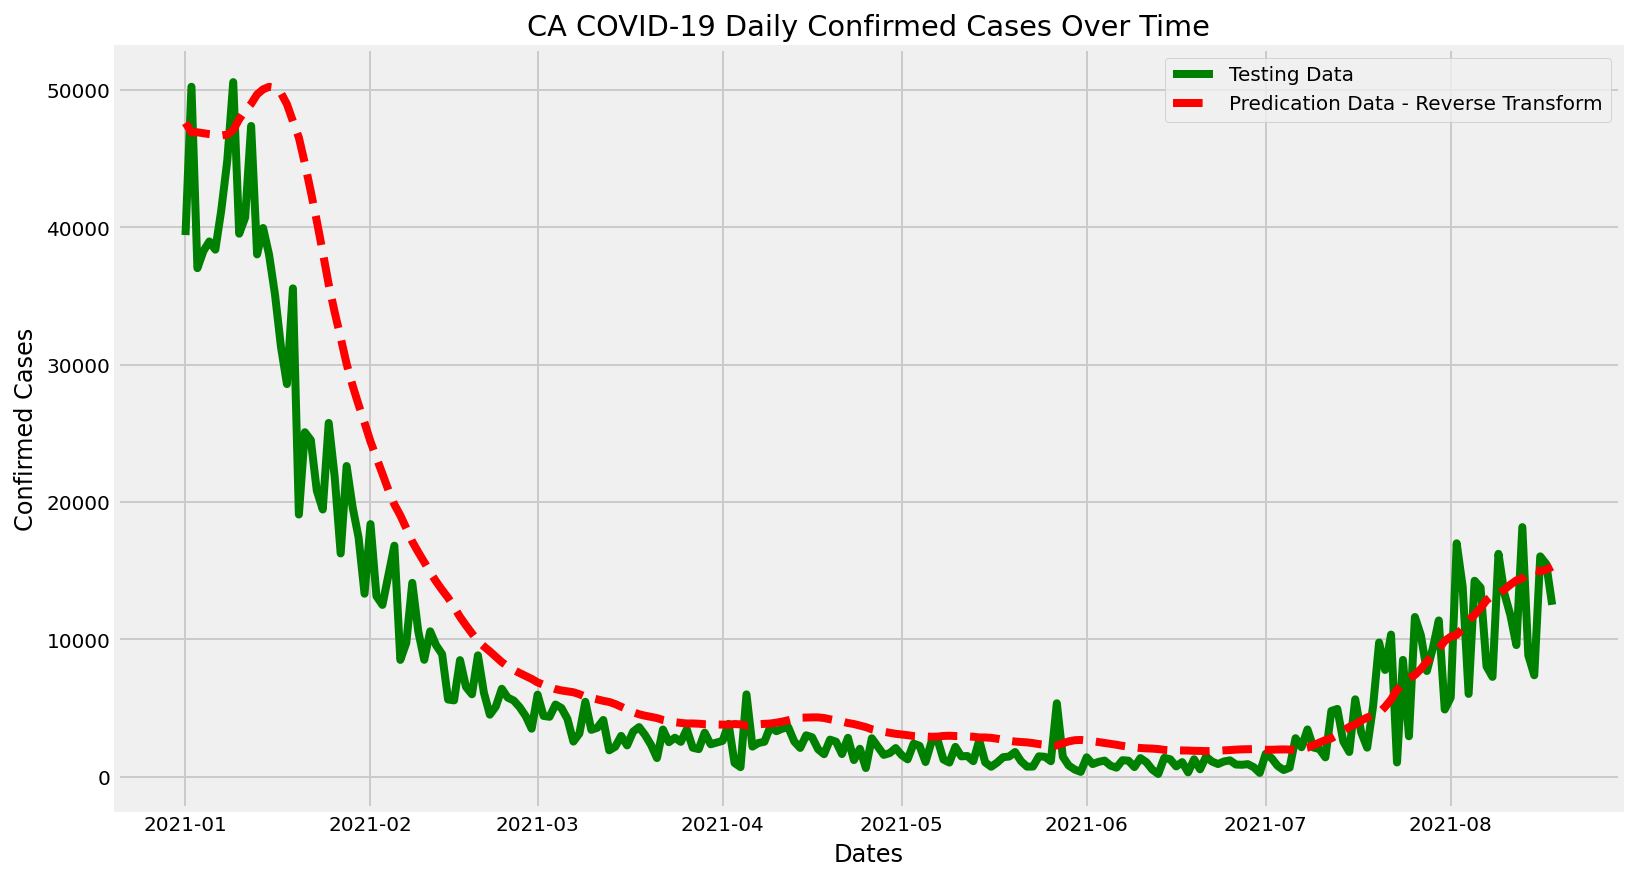

In [58]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Predication Data - Reverse Transform')
plt.legend();

# Generate forecasts

In [59]:
# Future predictions using LSTM 
LSTM_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'LSTM Predicted # of CA Daily Confirmed Cases': np.round(predicted_confirmed_cases_revtrans_series[-10:])})
LSTM_df.style.background_gradient(cmap='Reds')

In [60]:
LSTM_df.reset_index(drop=True)

Future Date  LSTM Predicted # of CA Daily Confirmed Cases
0  08/19/2021                                       13302.0
1  08/20/2021                                       13620.0
2  08/21/2021                                       13977.0
3  08/22/2021                                       14284.0
4  08/23/2021                                       14438.0
5  08/24/2021                                       14842.0
6  08/25/2021                                       15027.0
7  08/26/2021                                       14953.0
8  08/27/2021                                       15055.0
9  08/28/2021                                       15284.0

# (2) Total Confirmed Cases Prediction- CA

# Build Train-Test Datasets

In [61]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]
train_series = train_data['SUM']
test_series = test_data['SUM']
train_series.shape, test_series.shape

((345,), (230,))

# Visualize train and test data

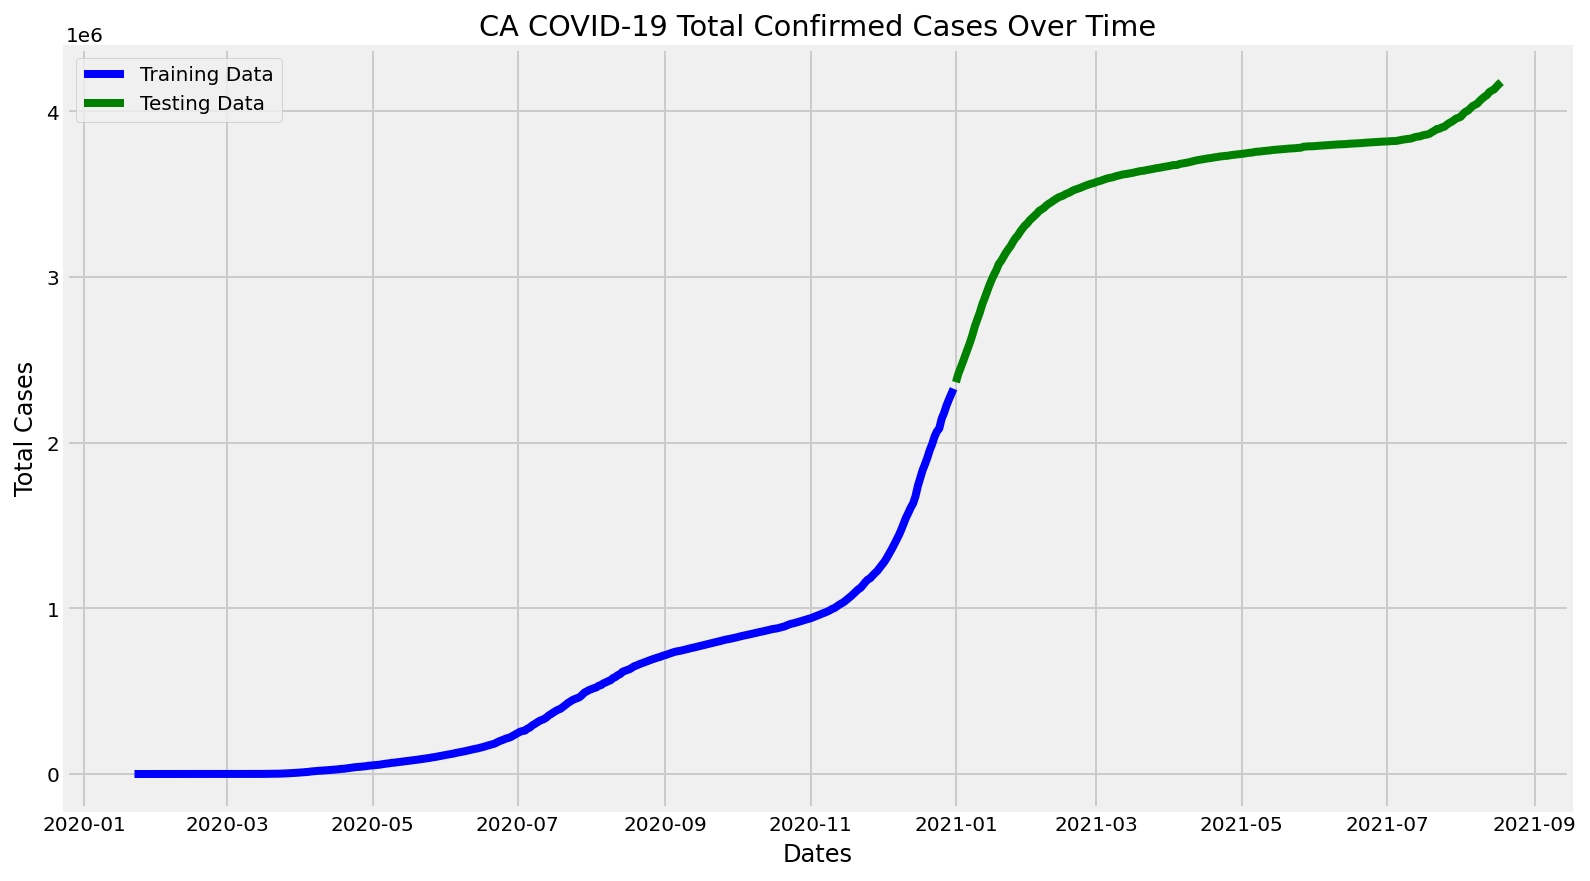

In [62]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Total Cases')
plt.plot(train_data['SUM'], 'blue', label='Training Data')
plt.plot(test_data['SUM'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [63]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [1.28999023e-06],
       [1.28999023e-06],
       [1.28999023e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [3.00997721e-06],
       [3.00997721e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.72996419e-06],
       [4.72996419e-06],
       [5.15996094e-06],
       [5.15996094e-06],


In [64]:
training_set_scaled.shape

(345, 1)

# Train Data Preparation

In [65]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((285, 60), (285,))

In [66]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [67]:
X_train.shape

(285, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [69]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [70]:
regressor.fit(X_train,y_train, epochs=6, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/6
4/4 [==============================] - 9s 664ms/step - loss: 0.0087 - val_loss: 0.0271
Epoch 2/6
4/4 [==============================] - 0s 80ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 3/6
4/4 [==============================] - 0s 77ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 4/6
4/4 [==============================] - 0s 79ms/step - loss: 8.6510e-04 - val_loss: 0.0354
Epoch 5/6
4/4 [==============================] - 0s 82ms/step - loss: 6.9738e-04 - val_loss: 0.0297
Epoch 6/6
4/4 [==============================] - 0s 77ms/step - loss: 7.7053e-04 - val_loss: 0.0061


# Test Data Forecasting¶

# Get the last 60 records from train_series¶

In [71]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [72]:
test_series.shape

(230,)

In [73]:
print(test_series)

Date
2021-01-01    2365024
2021-01-02    2415246
2021-01-03    2452262
2021-01-04    2490518
2021-01-05    2529480
               ...   
2021-08-14    4124955
2021-08-15    4132332
2021-08-16    4148367
2021-08-17    4163848
2021-08-18    4176356
Name: SUM, Length: 230, dtype: int64


# Combine both train_last60 and test_series together

In [74]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(290,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [75]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [76]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(230, 60, 1)

# Model Prediction and Reverse Transform

In [77]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((230,), (230,))

# Model Evaluation

In [78]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [79]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 120318759113.035
Symmetric Mean absolute percentage error: 9.844


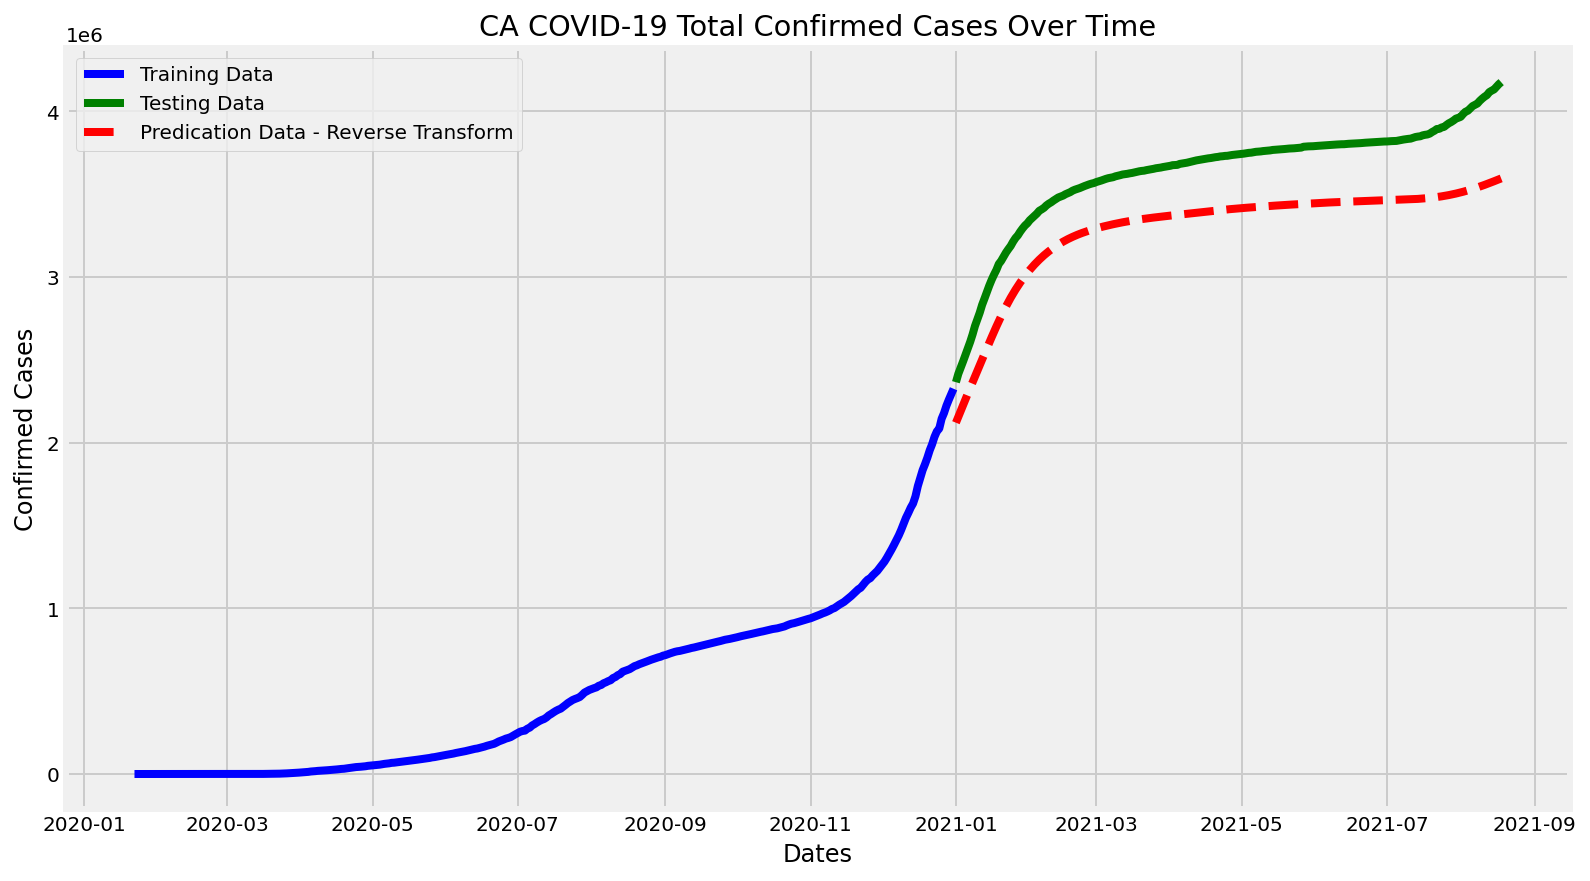

In [80]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Predication Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

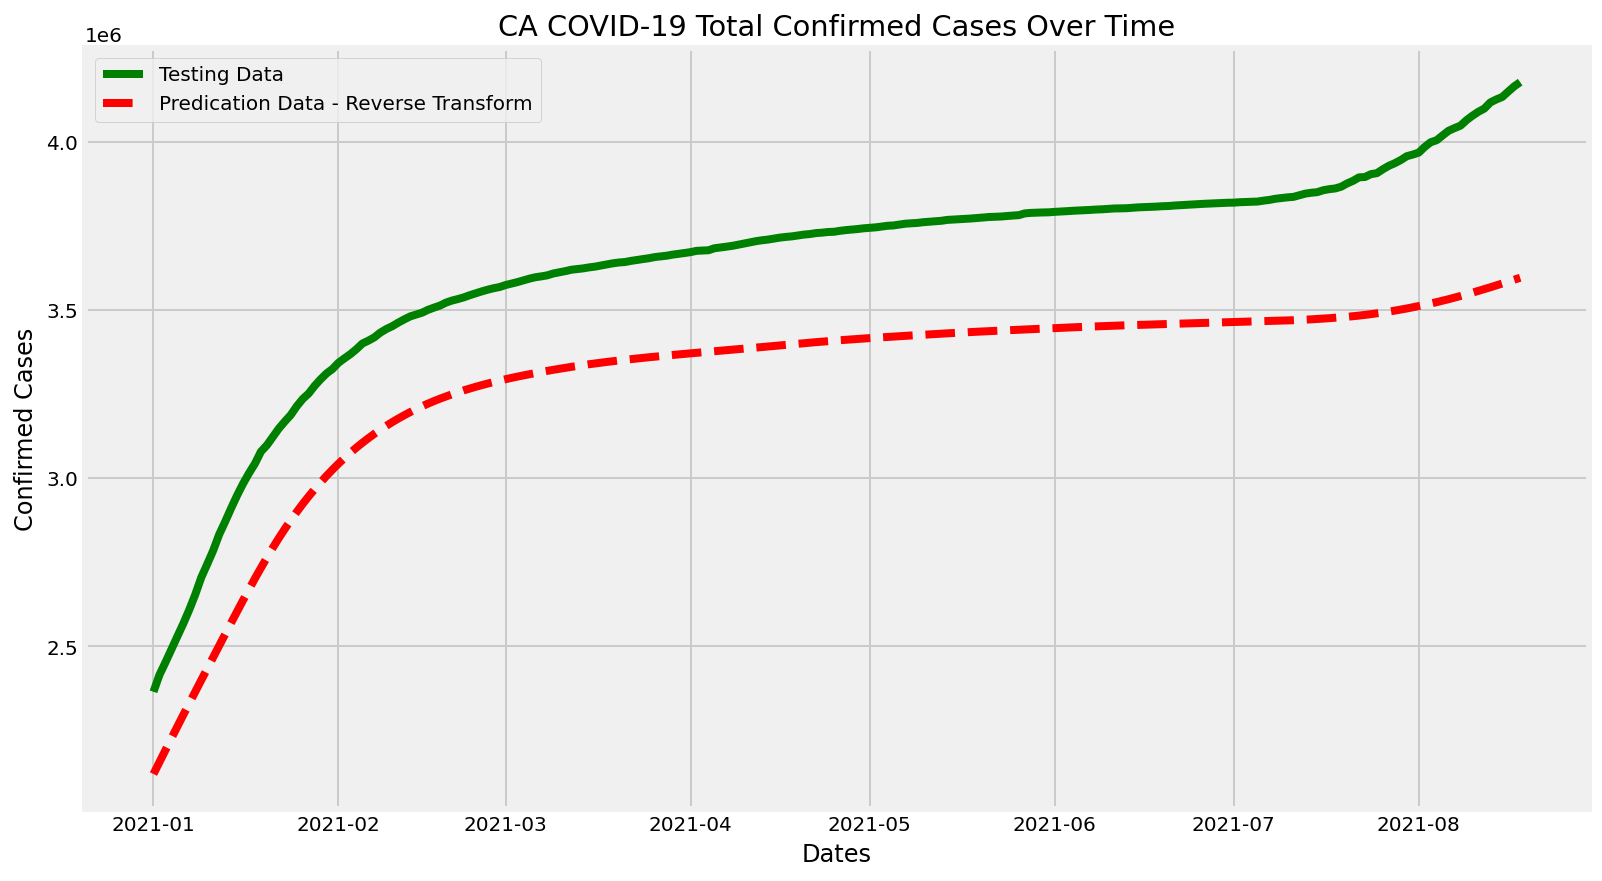

In [81]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Predication Data - Reverse Transform')
plt.legend();

# Generate forecasts

In [82]:
# Future predictions using LSTM 
LSTM_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'LSTM Predicted # of CA Total Confirmed Cases': np.round(predicted_confirmed_cases_revtrans_series[-10:])})
LSTM_df.style.background_gradient(cmap='Reds')

In [83]:
LSTM_df.reset_index(drop=True)

Future Date  LSTM Predicted # of CA Total Confirmed Cases
0  08/19/2021                                     3545852.0
1  08/20/2021                                     3550901.0
2  08/21/2021                                     3556100.0
3  08/22/2021                                     3561430.0
4  08/23/2021                                     3566836.0
5  08/24/2021                                     3572410.0
6  08/25/2021                                     3578064.0
7  08/26/2021                                     3583717.0
8  08/27/2021                                     3589438.0
9  08/28/2021                                     3595260.0

# 5. ARIMA Model

In [84]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [85]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

# (1) Daily Confirmed Cases Prediction- CA

In [86]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_CA_Transposed.csv')
confirmed_df = confirmed_df.dropna()
confirmed_df.tail()

Date  Alameda  Alpine  Amador  Butte  Calaveras  Colusa  \
570  8/14/2021   101473      91    4169  14179       2564    2459   
571  8/15/2021   101876      91    4206  14192       2579    2459   
572  8/16/2021   102101      91    4231  14263       2599    2565   
573  8/17/2021   102751      91    4235  14448       2609    2565   
574  8/18/2021   103075      91    4266  14518       2624    2565   

     Contra Costa  Del Norte  El Dorado  ...  Tehama  Trinity  Tulare  \
570         81823       2060      12001  ...    6214      526   51770   
571         82150       2060      12019  ...    6214      526   51951   
572         82440       2240      12195  ...    6214      532   52046   
573         82850       2275      12298  ...    6214      542   52162   
574         82850       2306      12363  ...    6214      545   52362   

     Tuolumne  Unassigned  Ventura   Yolo  Yuba      SUM  Daily  
570      5053         107    86440  15761  7562  4124955   8834  
571      5053          84    86569  15815  7562  4132332   7377  
572      5148         132    86977  15877  7584  4148367  16035  
573      5192         181    87202  15933  7737  4163848  15481  
574      5235          73    87601  15986  7789  4176356  12508  

[5 rows x 63 columns]

In [87]:
confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

Date  Alameda  Alpine  Amador  Butte  Calaveras  Colusa  \
Date                                                                       
2021-08-14  8/14/2021   101473      91    4169  14179       2564    2459   
2021-08-15  8/15/2021   101876      91    4206  14192       2579    2459   
2021-08-16  8/16/2021   102101      91    4231  14263       2599    2565   
2021-08-17  8/17/2021   102751      91    4235  14448       2609    2565   
2021-08-18  8/18/2021   103075      91    4266  14518       2624    2565   

            Contra Costa  Del Norte  El Dorado  ...  Tehama  Trinity  Tulare  \
Date                                            ...                            
2021-08-14         81823       2060      12001  ...    6214      526   51770   
2021-08-15         82150       2060      12019  ...    6214      526   51951   
2021-08-16         82440       2240      12195  ...    6214      532   52046   
2021-08-17         82850       2275      12298  ...    6214      542   52162   
2021-08-18         82850       2306      12363  ...    6214      545   52362   

            Tuolumne  Unassigned  Ventura   Yolo  Yuba      SUM  Daily  
Date                                                                    
2021-08-14      5053         107    86440  15761  7562  4124955   8834  
2021-08-15      5053          84    86569  15815  7562  4132332   7377  
2021-08-16      5148         132    86977  15877  7584  4148367  16035  
2021-08-17      5192         181    87202  15933  7737  4163848  15481  
2021-08-18      5235          73    87601  15986  7789  4176356  12508  

[5 rows x 63 columns]

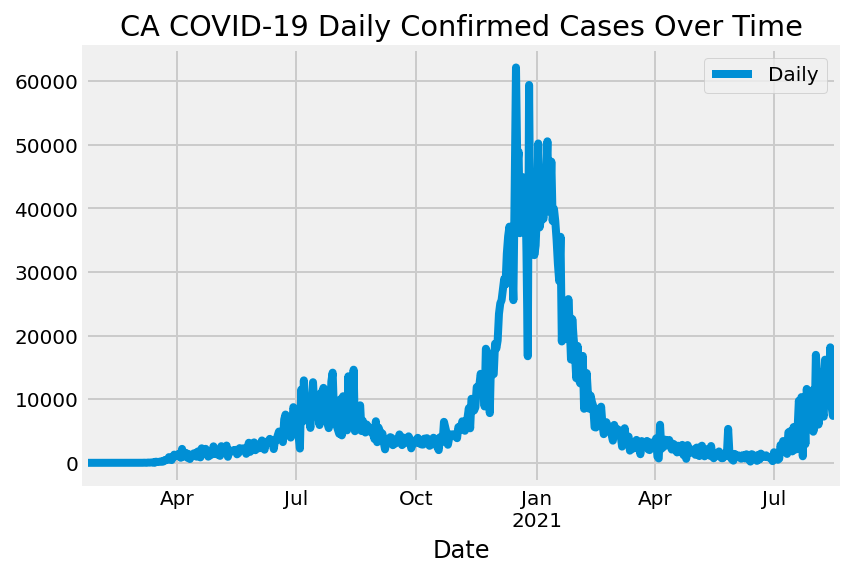

In [88]:
dr = confirmed_df[['Daily']]
dr.plot()
plt.title('CA COVID-19 Daily Confirmed Cases Over Time');

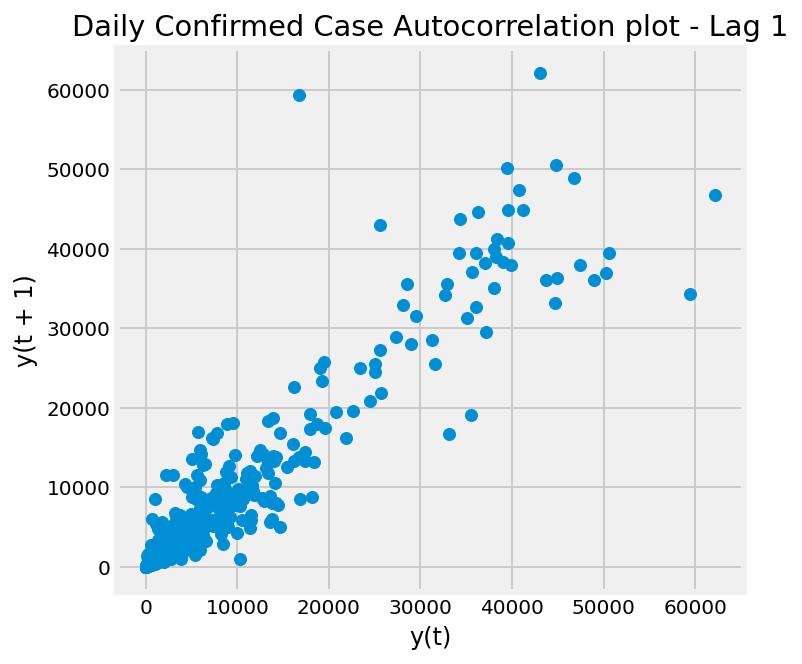

In [89]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['Daily'], lag=1)
plt.title('Daily Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets

In [90]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]

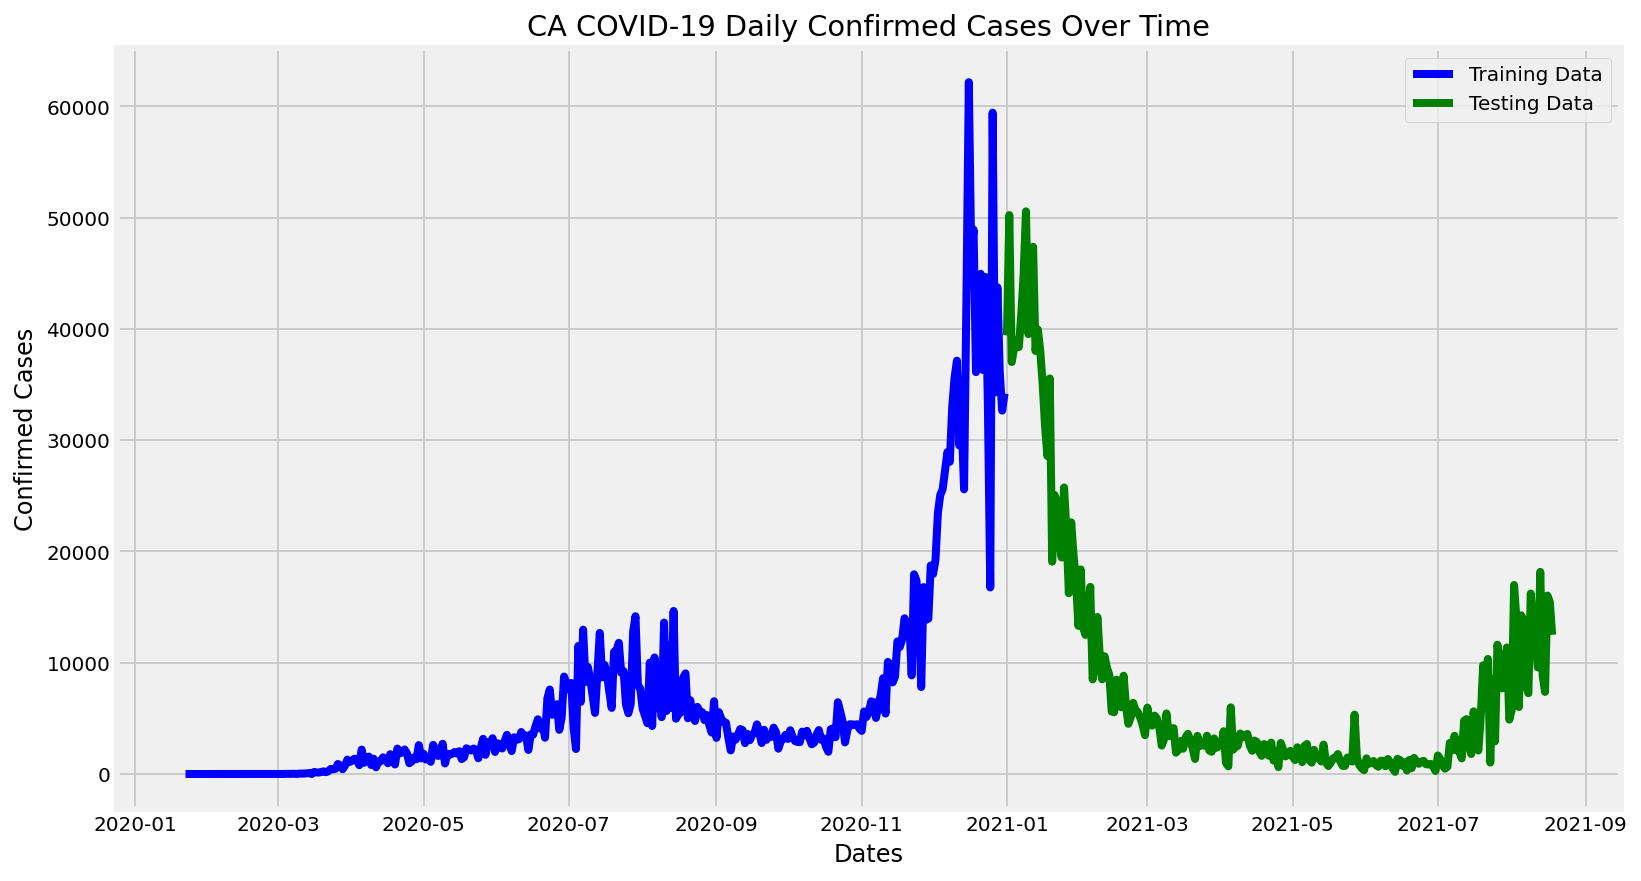

In [91]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

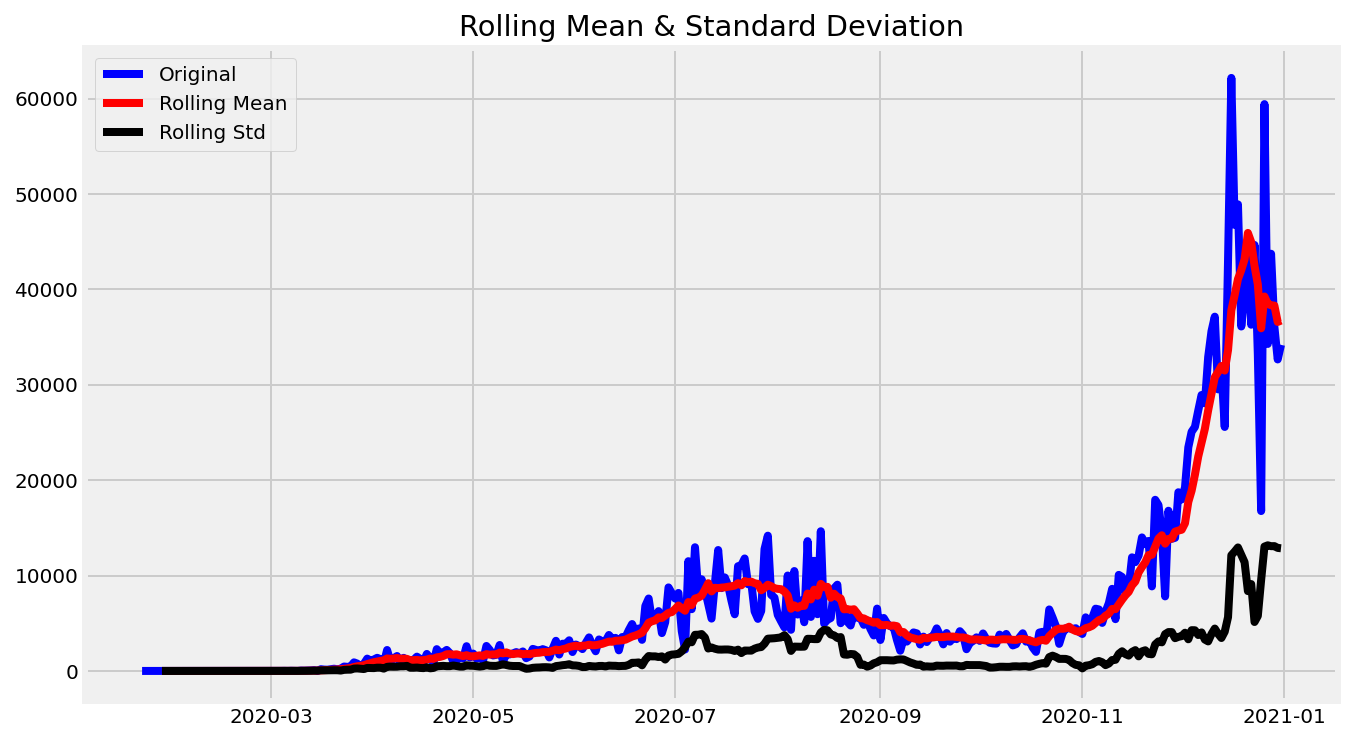

In [92]:
window = 7
train_series = train_data['Daily']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [93]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.431648
p-value                          0.133002
#Lags Used                      17.000000
Number of Observations Used    327.000000
Critical Value (1%)             -3.450507
Critical Value (5%)             -2.870420
Critical Value (10%)            -2.571501
dtype: float64

# Apply a first order differencing on the training data

In [94]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [95]:
train_diff

Date
2020-01-23        0.0
2020-01-24        0.0
2020-01-25        0.0
2020-01-26        2.0
2020-01-27       -2.0
               ...   
2020-12-27   -25143.0
2020-12-28     9455.0
2020-12-29    -7645.0
2020-12-30    -3435.0
2020-12-31     1530.0
Name: Daily, Length: 344, dtype: float64

# Visualize Rolling statistics for differenced train data

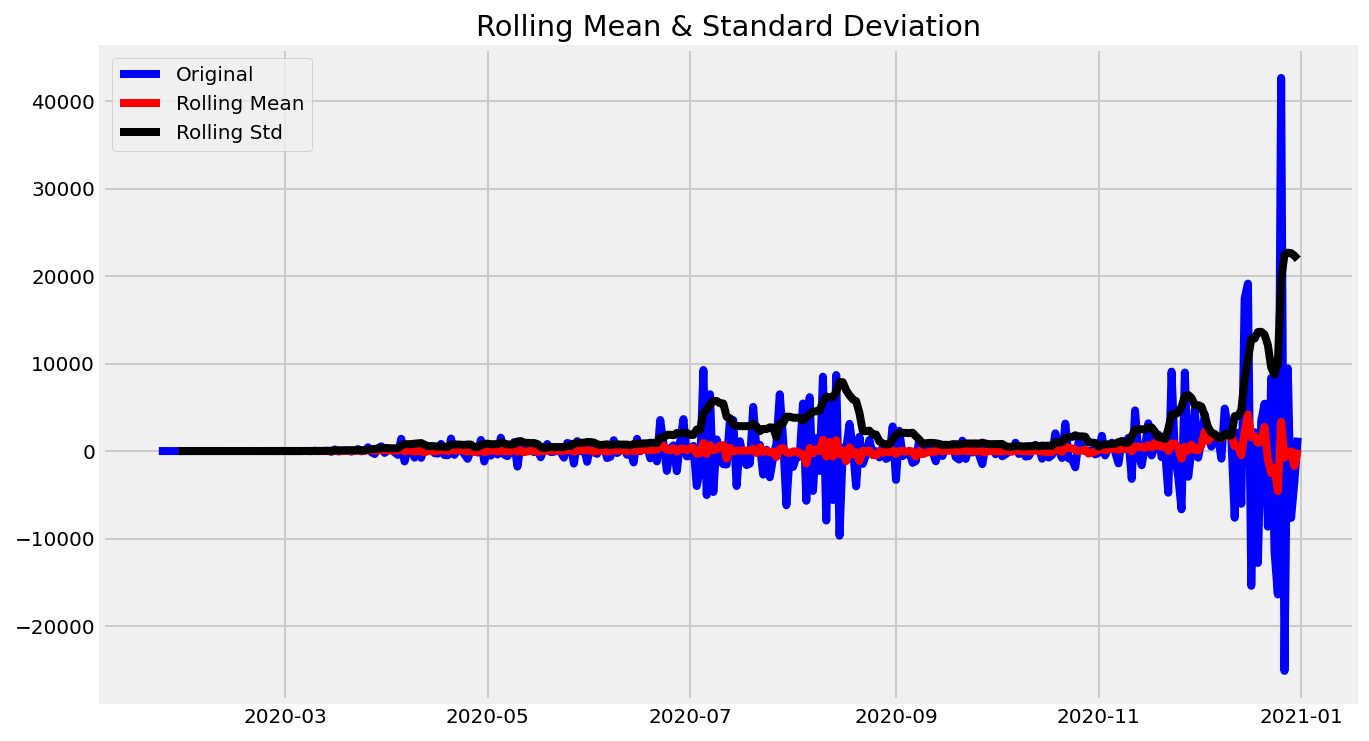

In [96]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [97]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -4.712280
p-value                          0.000080
#Lags Used                      10.000000
Number of Observations Used    333.000000
Critical Value (1%)             -3.450141
Critical Value (5%)             -2.870259
Critical Value (10%)            -2.571415
dtype: float64

# Plot ACF and PACF on the original train series

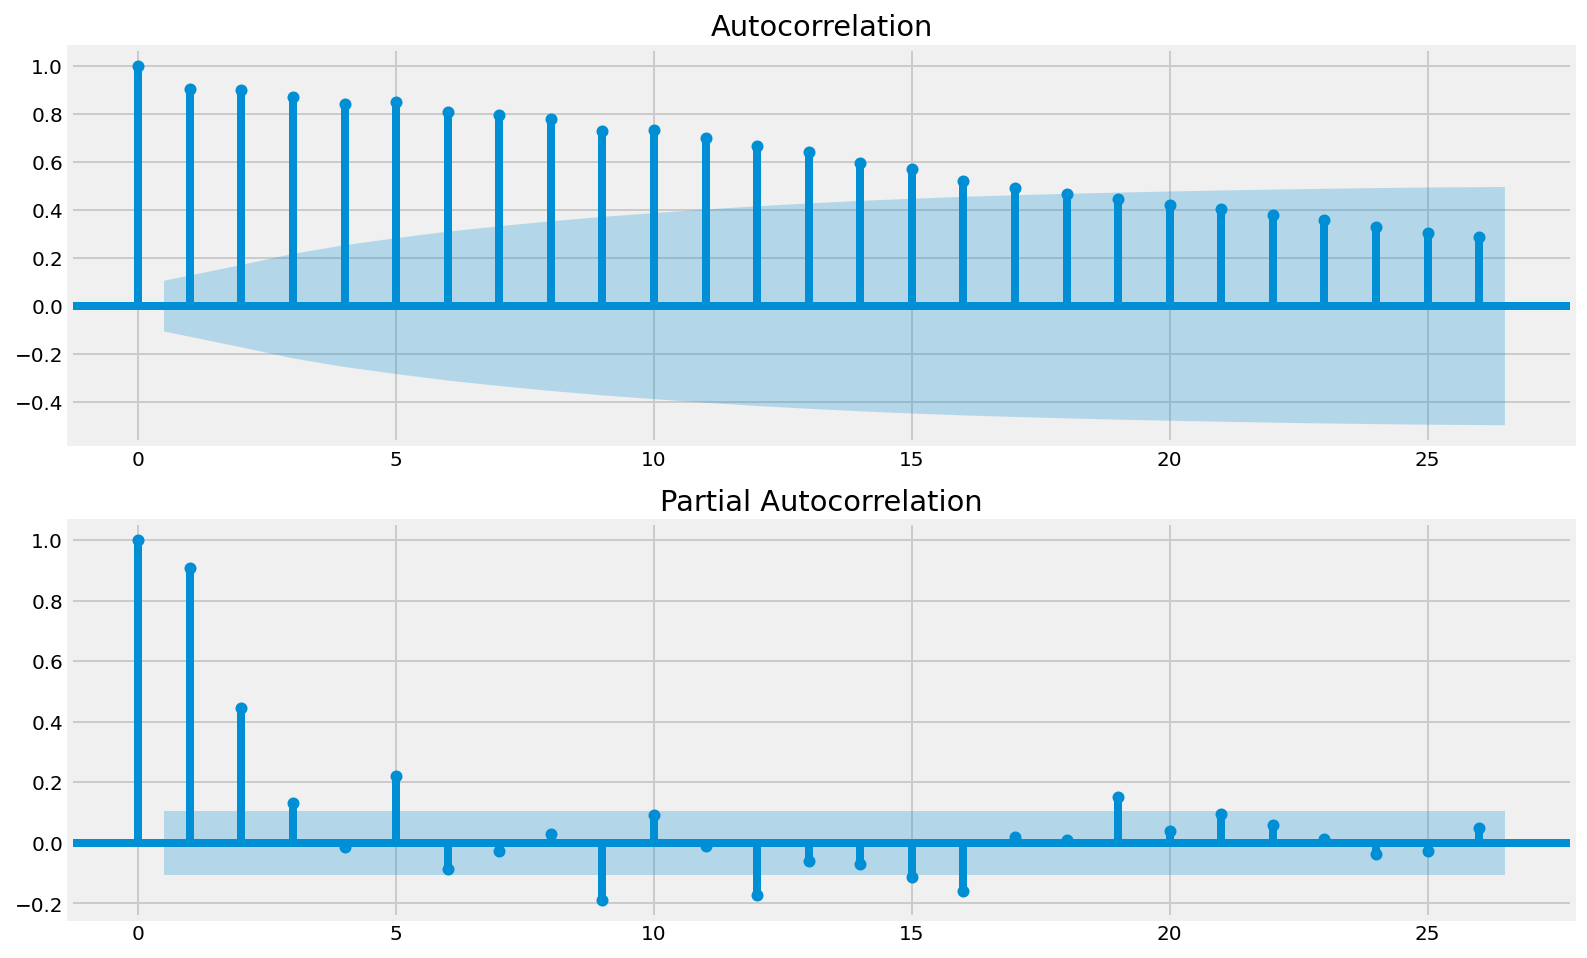

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

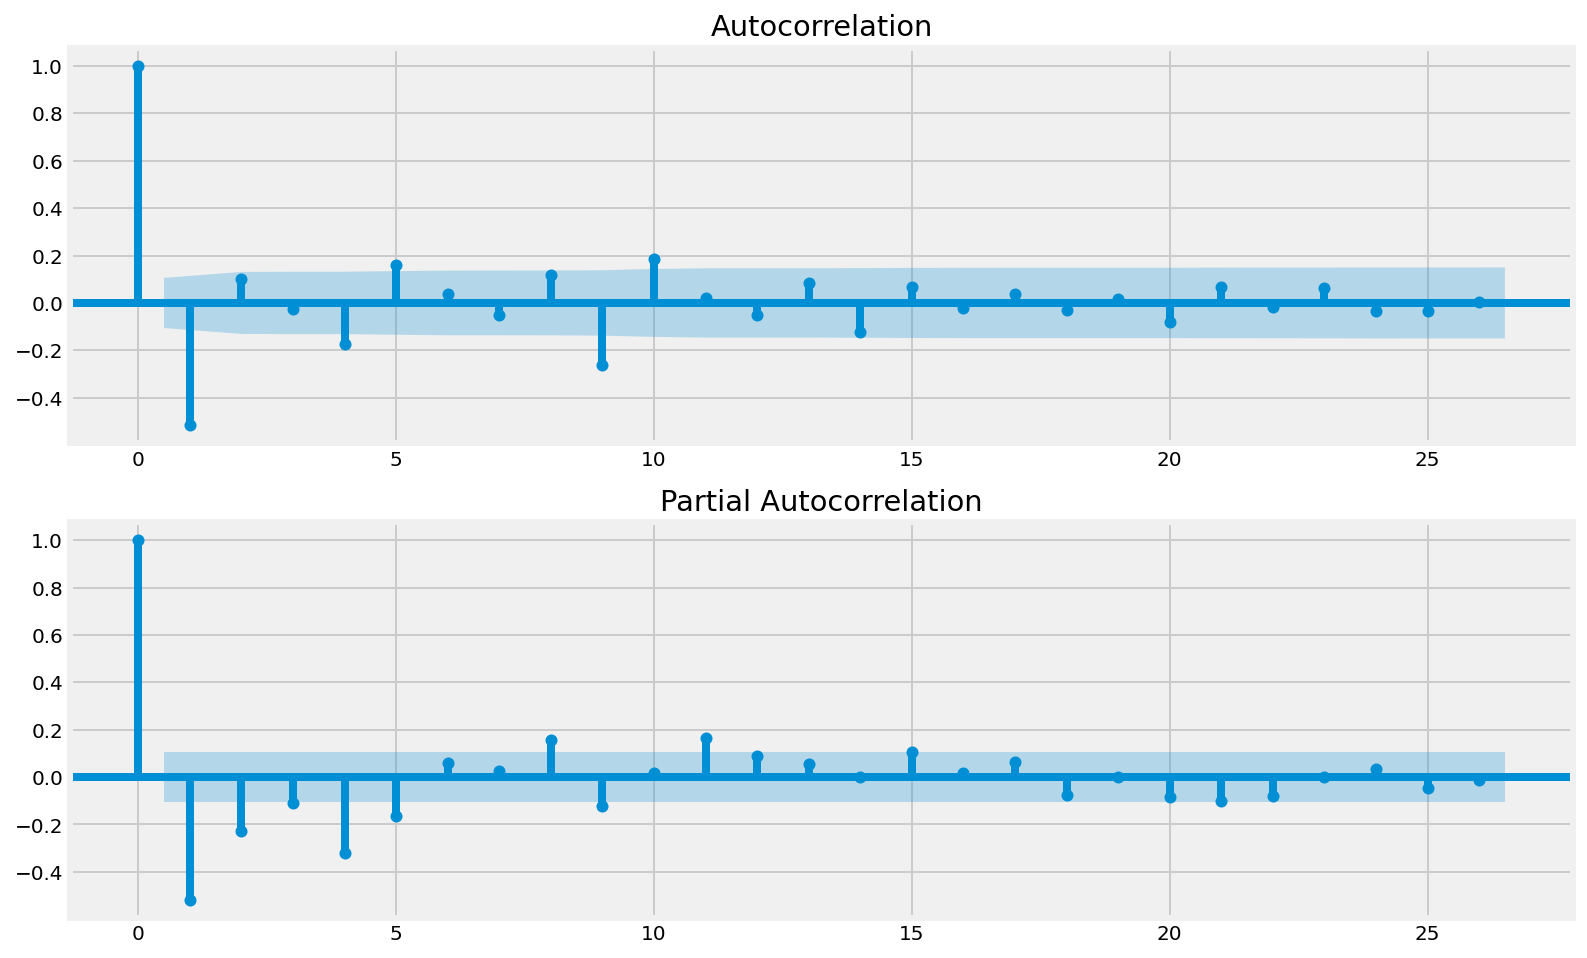

In [99]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [100]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [101]:
test_series = test_data['Daily']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-01-02    10797.0
2021-01-03   -13206.0
2021-01-04     1240.0
2021-01-05      706.0
2021-01-06     -599.0
               ...   
2021-08-14    -9329.0
2021-08-15    -1457.0
2021-08-16     8658.0
2021-08-17     -554.0
2021-08-18    -2973.0
Name: Daily, Length: 229, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [102]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [103]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=10699.559901994377, Expected=10797.0
Test Series Point: 100	Predicted=-1151.163412414453, Expected=108.0
Test Series Point: 200	Predicted=-1426.4008993658408, Expected=-1999.0
Wall time: 1min 14s


# Reverse Transform the forecasted values

In [104]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((230,), (230,))

# Evaluate model performance

In [105]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 30659971.491
Symmetric Mean absolute percentage error: 144.020


In [106]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

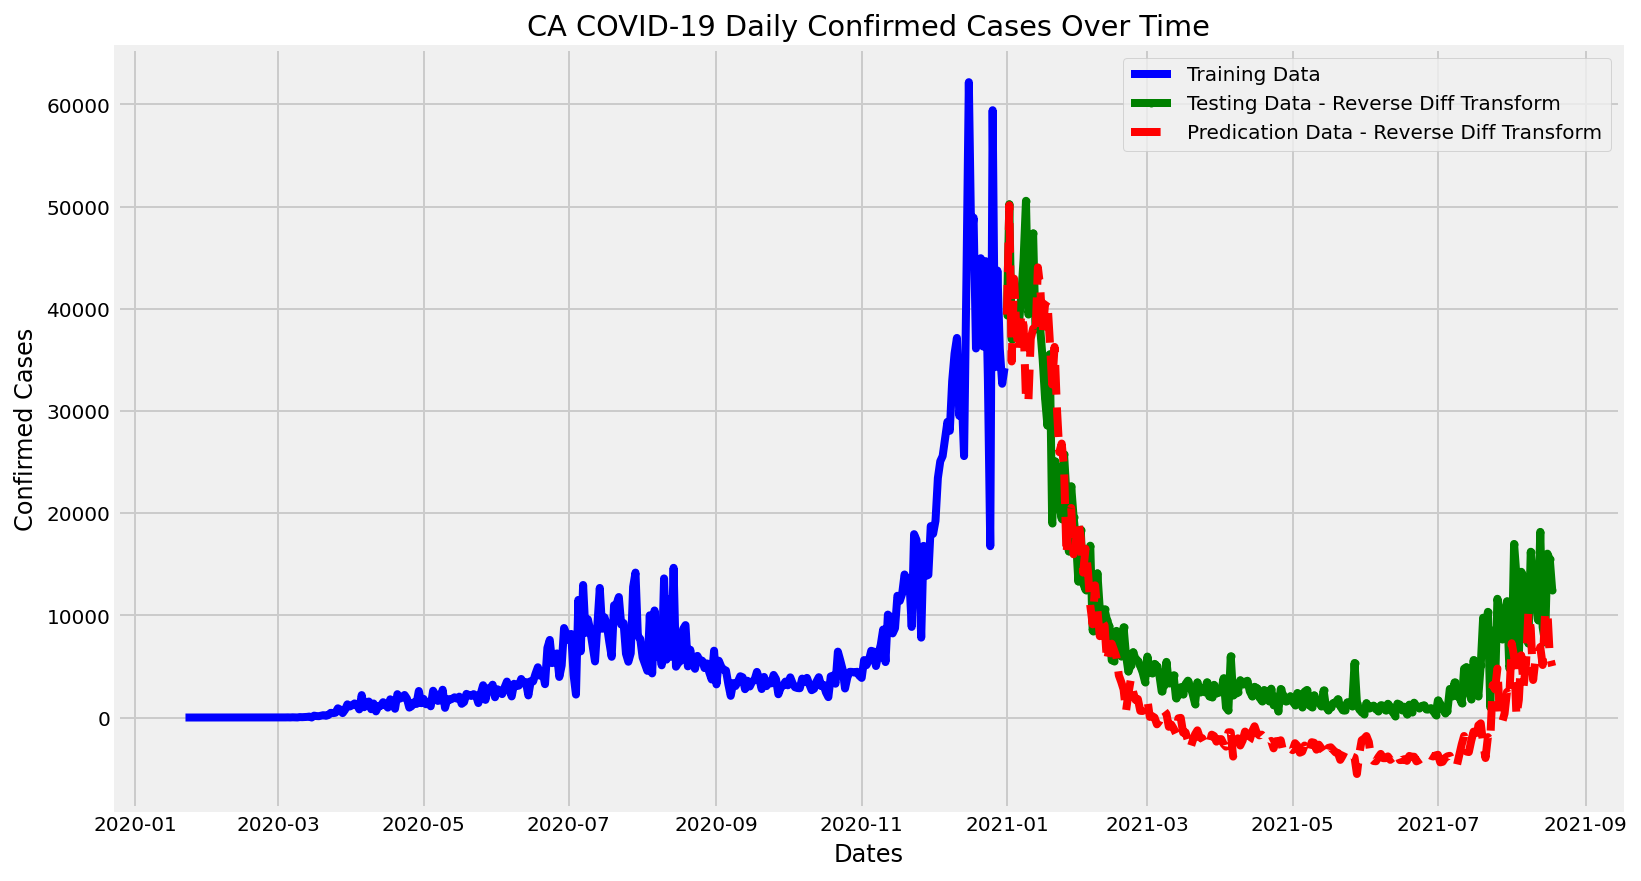

In [107]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and forecast prices

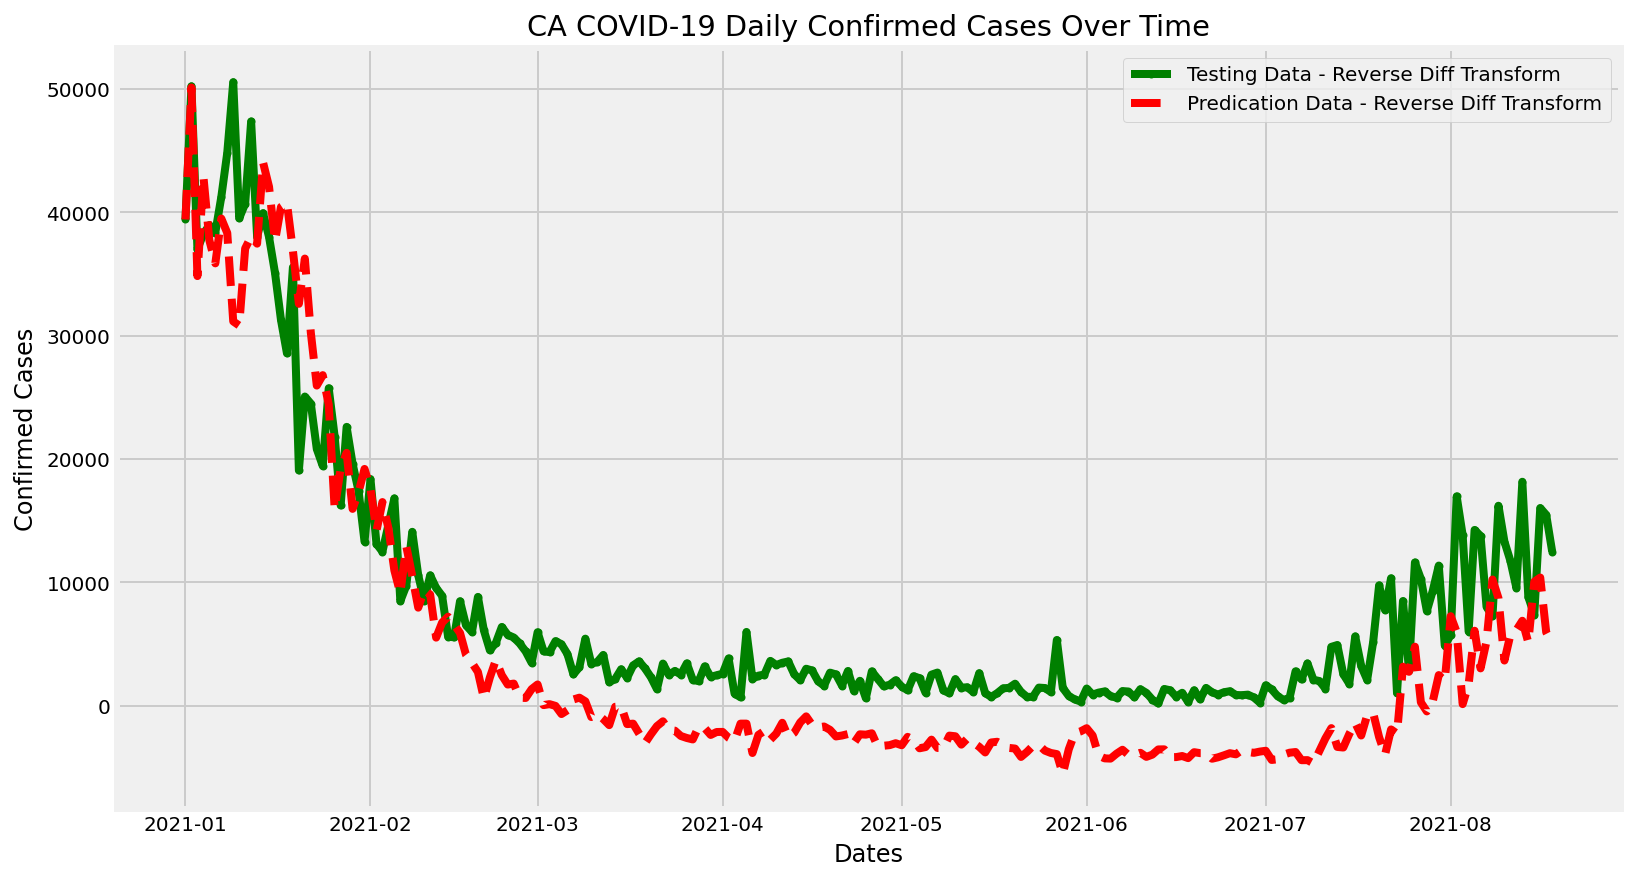

In [108]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Generate forecasts

In [109]:
# Future predictions using ARIMA 
ARIMA_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'ARIMA Predicted # of CA Total Confirmed Cases': np.round(reverse_predictions_series[-10:])})
ARIMA_df.style.background_gradient(cmap='Reds')

In [110]:
ARIMA_df.reset_index(drop=True)


Future Date  ARIMA Predicted # of CA Total Confirmed Cases
0  08/19/2021                                         8732.0
1  08/20/2021                                         3671.0
2  08/21/2021                                         5750.0
3  08/22/2021                                         6139.0
4  08/23/2021                                         6896.0
5  08/24/2021                                         5139.0
6  08/25/2021                                        10053.0
7  08/26/2021                                        10398.0
8  08/27/2021                                         5964.0
9  08/28/2021                                         5026.0

# (2) Total Confirmed Cases Prediction- CA

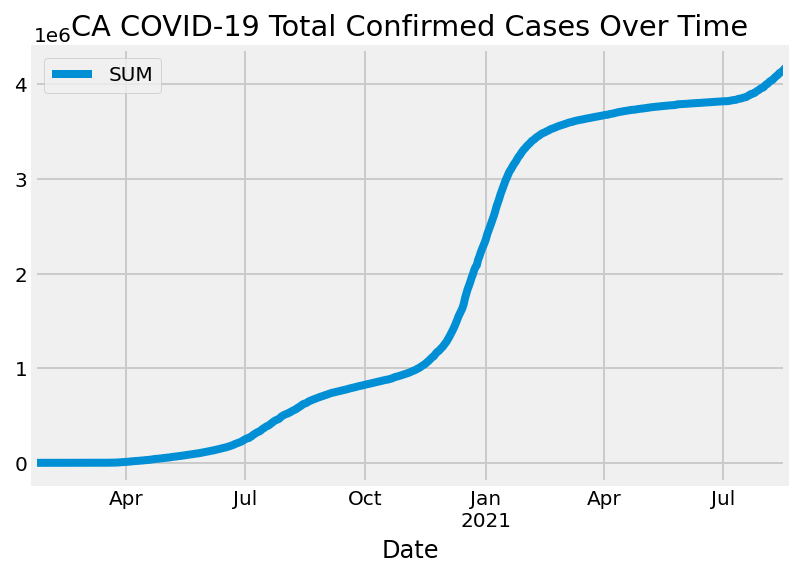

In [111]:
dr = confirmed_df[['SUM']]
dr.plot()
plt.title('CA COVID-19 Total Confirmed Cases Over Time');

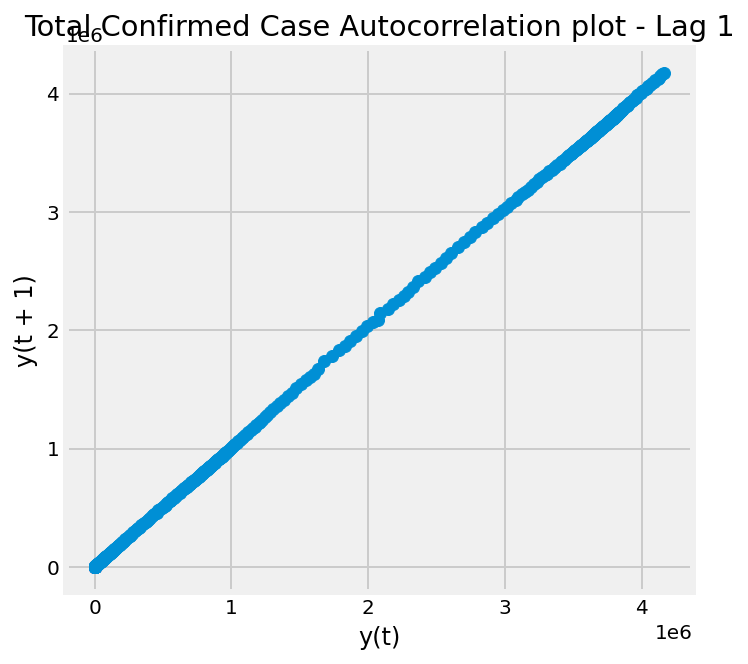

In [112]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['SUM'], lag=1)
plt.title('Total Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets

In [113]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]

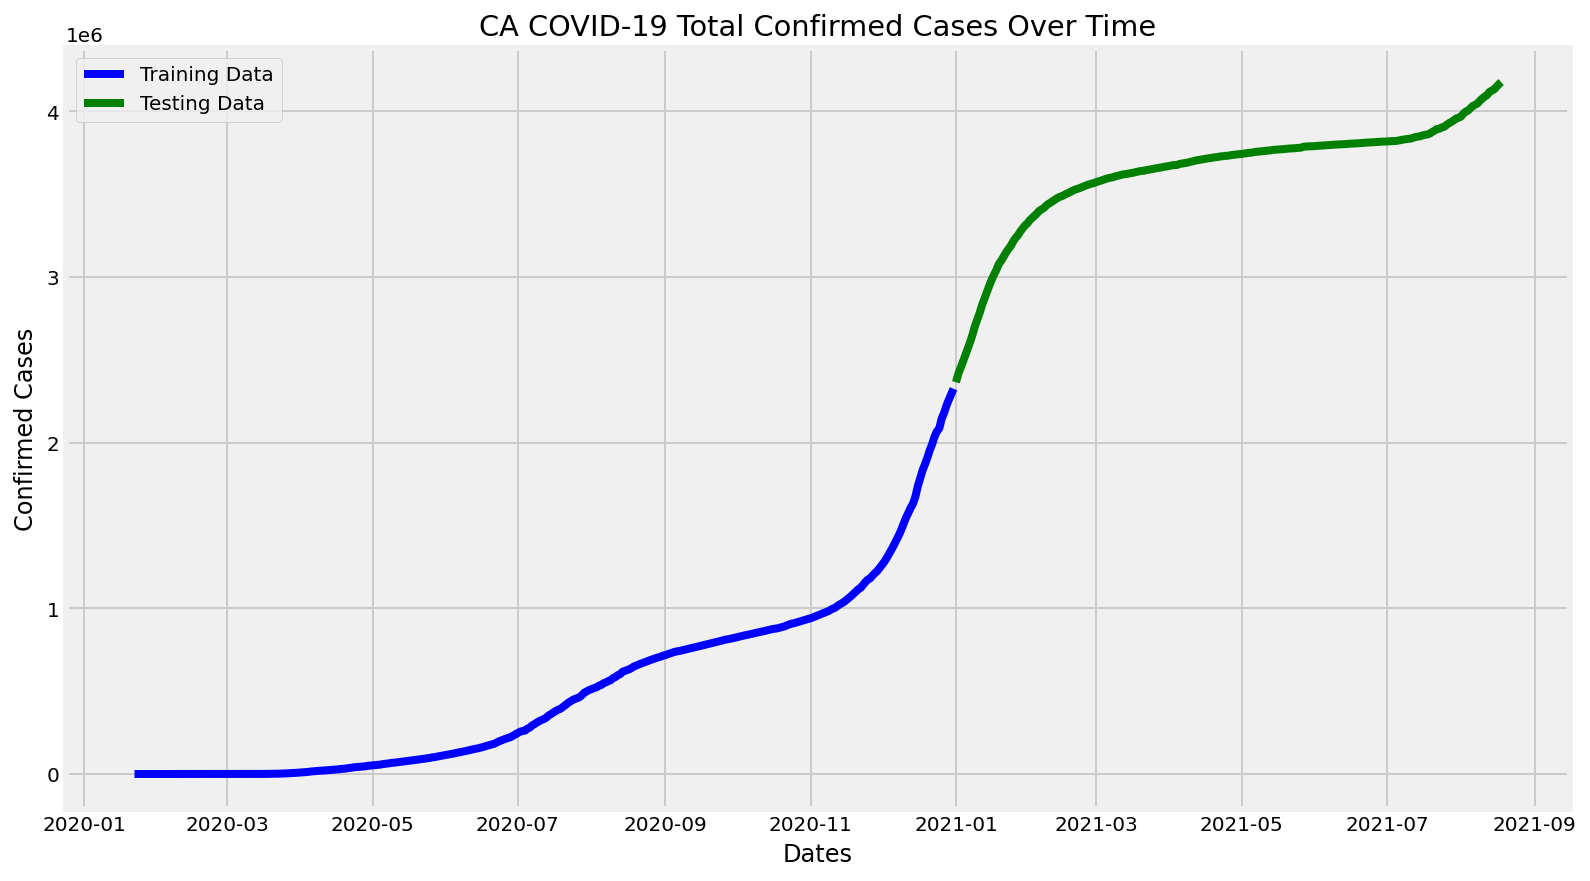

In [114]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['SUM'], 'blue', label='Training Data')
plt.plot(test_data['SUM'], 'green', label='Testing Data')
plt.legend();

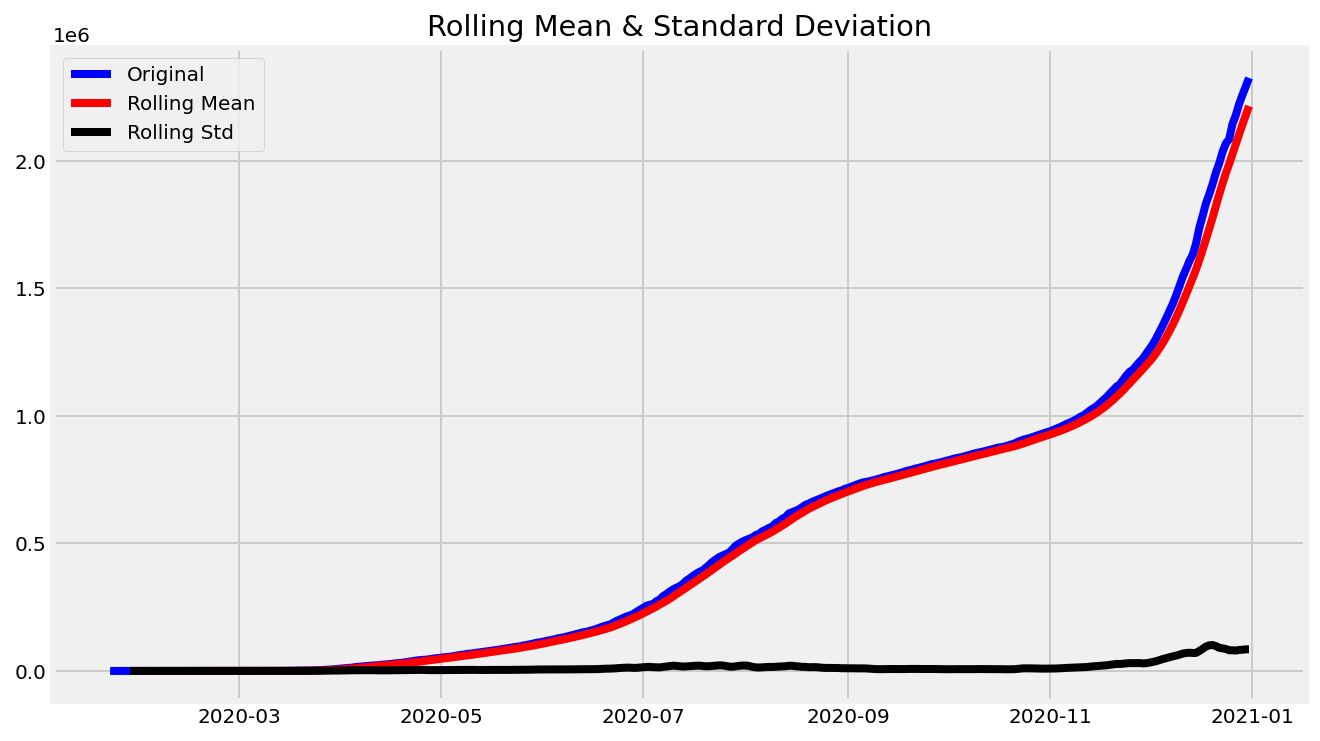

In [115]:
window = 7
train_series = train_data['SUM']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [116]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   2.136538
p-value                          0.998826
#Lags Used                      17.000000
Number of Observations Used    327.000000
Critical Value (1%)             -3.450507
Critical Value (5%)             -2.870420
Critical Value (10%)            -2.571501
dtype: float64

# Apply a first order differencing on the training data

In [117]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [118]:
train_diff

Date
2020-01-23        0.0
2020-01-24        0.0
2020-01-25        0.0
2020-01-26        2.0
2020-01-27        0.0
               ...   
2020-12-27    34280.0
2020-12-28    43735.0
2020-12-29    36090.0
2020-12-30    32655.0
2020-12-31    34185.0
Name: SUM, Length: 344, dtype: float64

# Visualize Rolling statistics for differenced train data

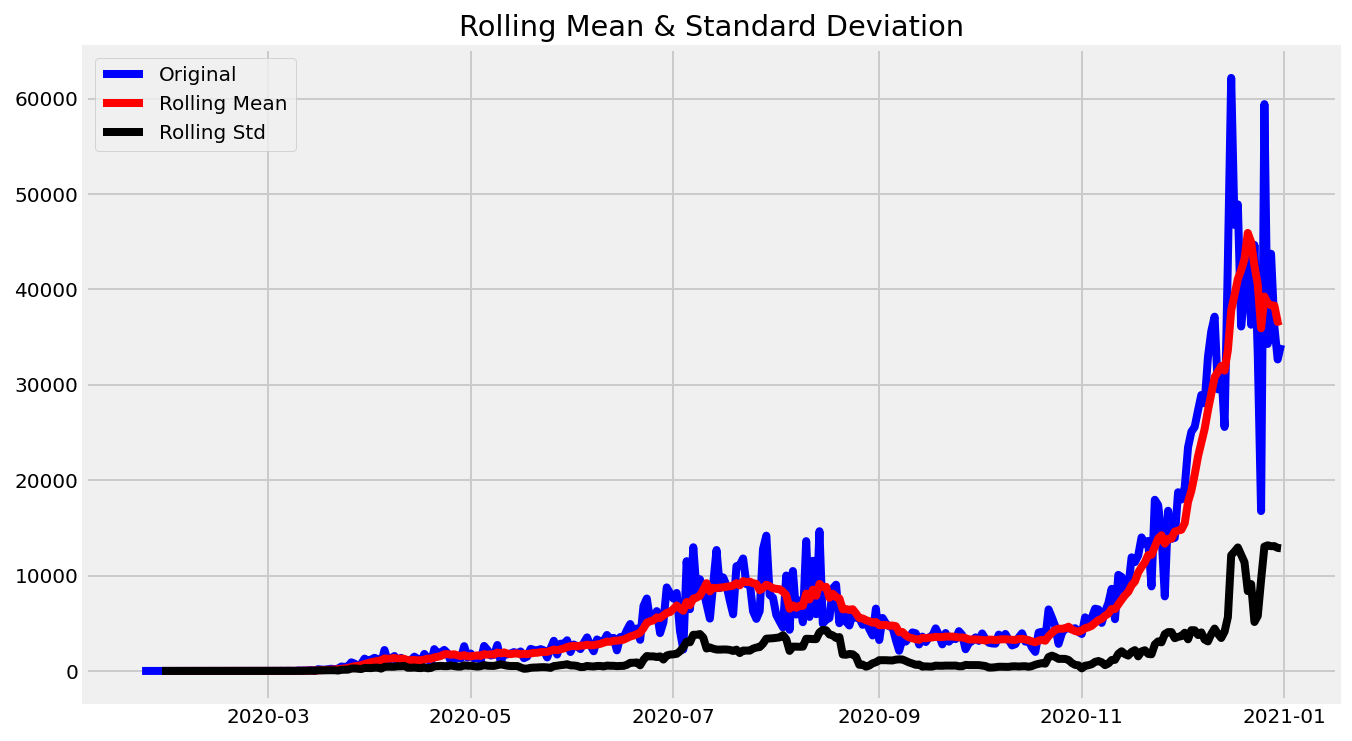

In [119]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [120]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.432618
p-value                          0.132741
#Lags Used                      17.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64

# Plot ACF and PACF on the original train series

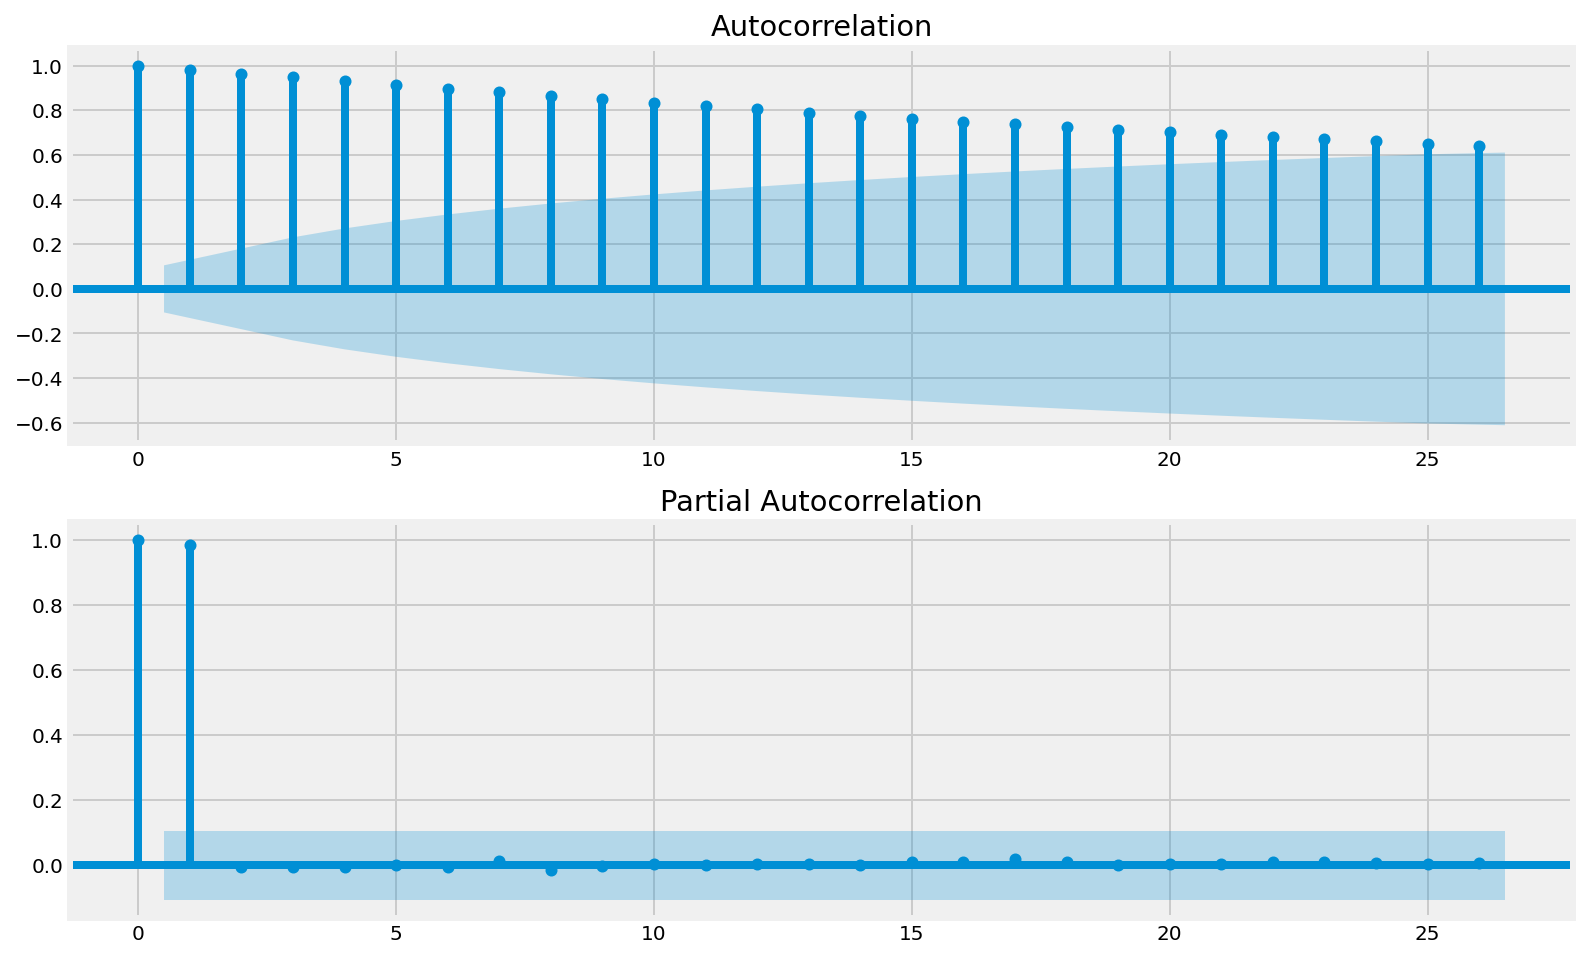

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

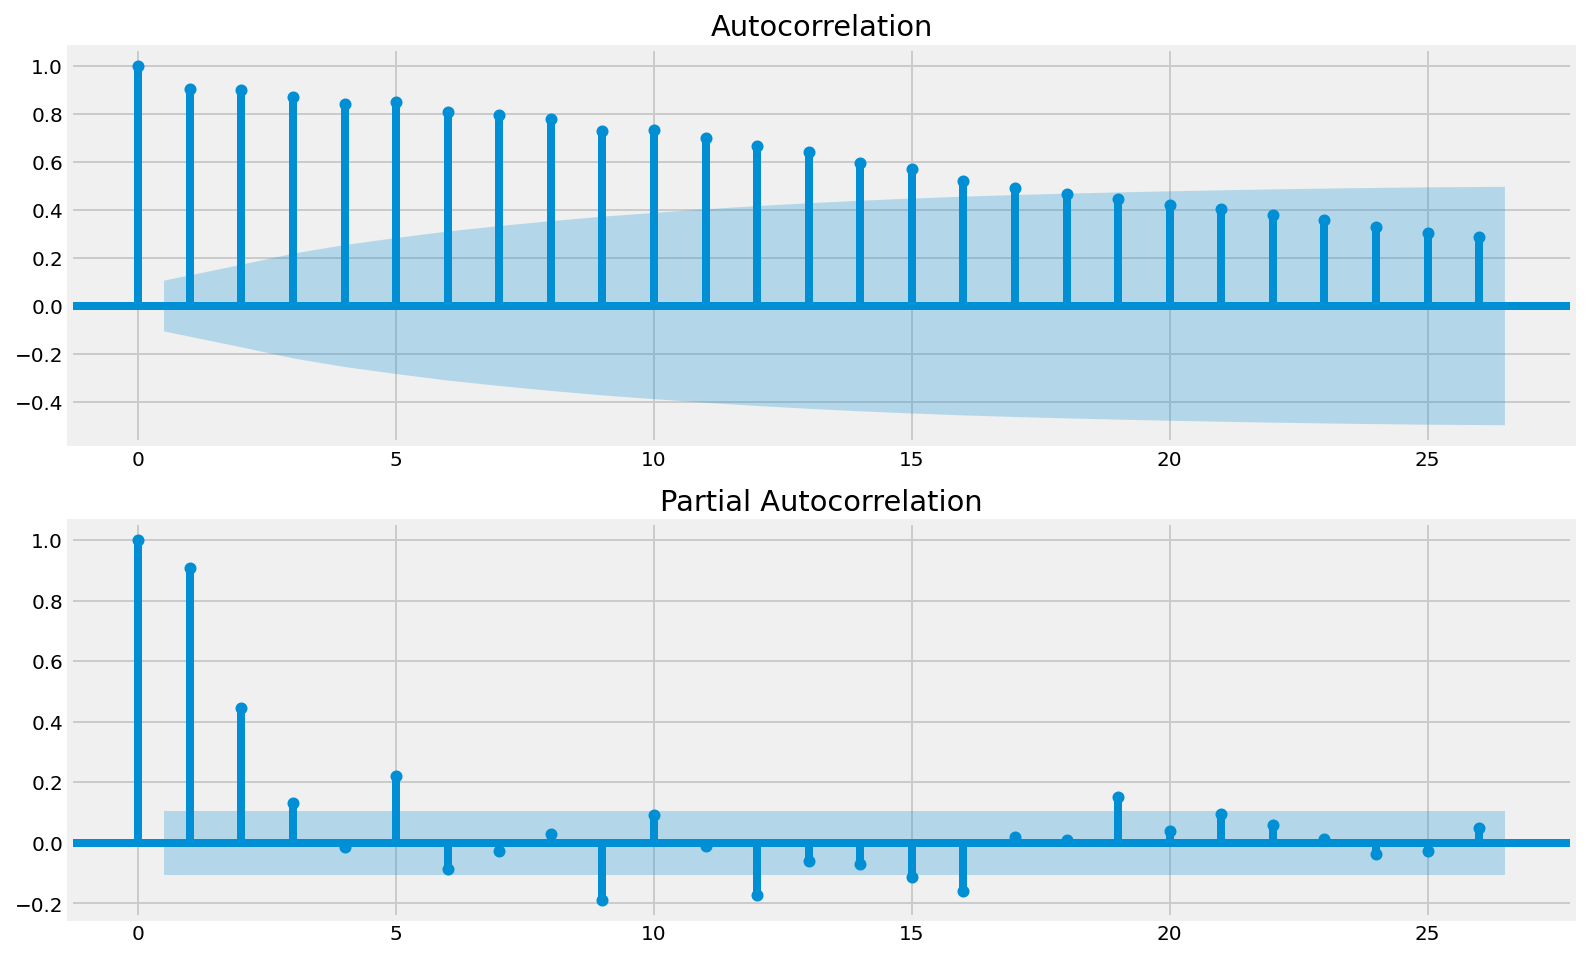

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [123]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [124]:
test_series = test_data['SUM']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-01-02    50222.0
2021-01-03    37016.0
2021-01-04    38256.0
2021-01-05    38962.0
2021-01-06    38363.0
               ...   
2021-08-14     8834.0
2021-08-15     7377.0
2021-08-16    16035.0
2021-08-17    15481.0
2021-08-18    12508.0
Name: SUM, Length: 229, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [125]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [126]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=38472.01572363321, Expected=50222.0
Test Series Point: 100	Predicted=3137.700530692892, Expected=3599.0
Test Series Point: 200	Predicted=5567.940286188714, Expected=7766.0
Wall time: 58.2 s


# Reverse Transform the forecasted values

In [127]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((230,), (230,))

# Evaluate model performance

In [128]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 10775775003.851
Symmetric Mean absolute percentage error: 2.628


In [129]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

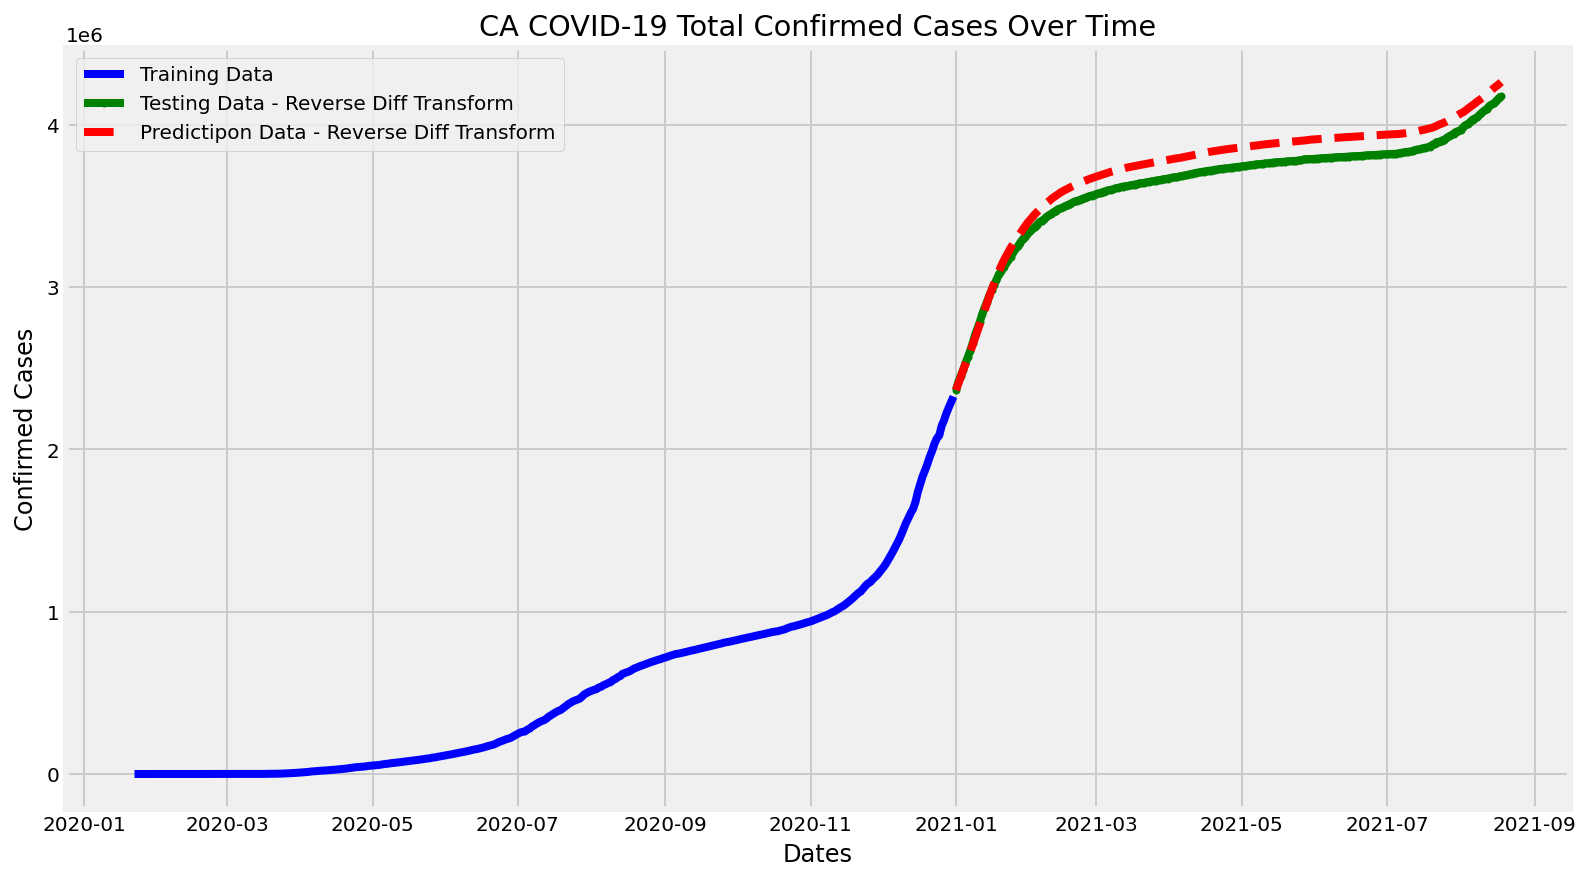

In [130]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predictipon Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and forecast prices

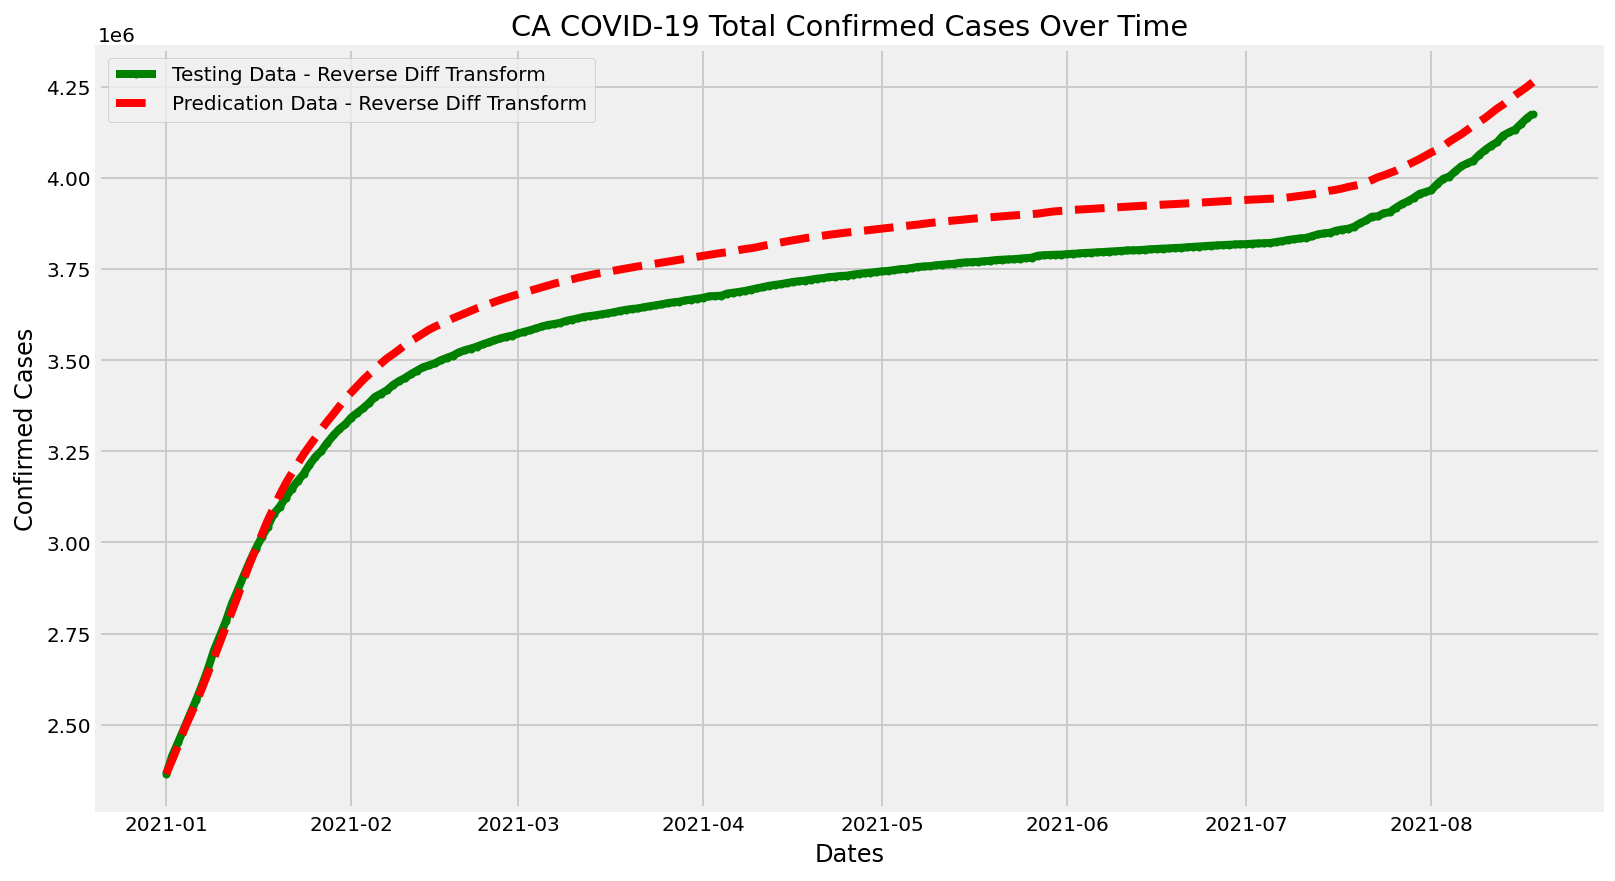

In [131]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Generate forecasts

In [132]:
# Future predictions using ARIMA 
ARIMA_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'ARIMA Predicted # of CA Total Confirmed Cases': np.round(reverse_predictions_series[-10:])})
ARIMA_df.style.background_gradient(cmap='Reds')

In [133]:
ARIMA_df.reset_index(drop=True)

Future Date  ARIMA Predicted # of CA Total Confirmed Cases
0  08/19/2021                                      4153739.0
1  08/20/2021                                      4164491.0
2  08/21/2021                                      4177431.0
3  08/22/2021                                      4190071.0
4  08/23/2021                                      4200823.0
5  08/24/2021                                      4213727.0
6  08/25/2021                                      4226759.0
7  08/26/2021                                      4237829.0
8  08/27/2021                                      4249599.0
9  08/28/2021                                      4262581.0

# (3) Daily Confirmed Cases Prediction- US

In [134]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_US_Transposed.csv')
confirmed_df = confirmed_df.dropna()
confirmed_df

Date  Autauga  Baldwin  Barbour  Bibb  Blount  Bullock  Butler  \
0    1/22/2020        0        0        0     0       0        0       0   
1    1/23/2020        0        0        0     0       0        0       0   
2    1/24/2020        0        0        0     0       0        0       0   
3    1/25/2020        0        0        0     0       0        0       0   
4    1/26/2020        0        0        0     0       0        0       0   
..         ...      ...      ...      ...   ...     ...      ...     ...   
570  8/14/2021     7931    28629     2732  3095    7758     1299    2565   
571  8/15/2021     8025    29094     2750  3120    7803     1302    2584   
572  8/16/2021     8061    29234     2761  3129    7833     1307    2592   
573  8/17/2021     8091    29465     2785  3152    7884     1314    2604   
574  8/18/2021     8132    29836     2805  3170    7930     1319    2614   

     Calhoun  Chambers  ...  Sheridan.4  Sublette  Sweetwater  Teton.2  Uinta  \
0          0         0  ...           0         0           0        0      0   
1          0         0  ...           0         0           0        0      0   
2          0         0  ...           0         0           0        0      0   
3          0         0  ...           0         0           0        0      0   
4          0         0  ...           0         0           0        0      0   
..       ...       ...  ...         ...       ...         ...      ...    ...   
570    16163      4225  ...        3488       881        5127     4068   2593   
571    16291      4263  ...        3488       881        5127     4068   2593   
572    16340      4284  ...        3517       884        5172     4107   2615   
573    16407      4322  ...        3558       887        5182     4116   2636   
574    16515      4351  ...        3581       890        5222     4130   2686   

     Unassigned.51  Washakie  Weston       SUM   Daily  
0                0         0       0         1       1  
1                0         0       0         1       0  
2                0         0       0         2       1  
3                0         0       0         2       0  
4                0         0       0         5       3  
..             ...       ...     ...       ...     ...  
570              0       967     705  36640271   42707  
571              0       967     705  36678753   38482  
572              0       971     717  36888952  210199  
573              0       973     721  37017854  128902  
574              0       979     726  37155669  137815  

[575 rows x 3345 columns]

In [135]:
confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

Date  Autauga  Baldwin  Barbour  Bibb  Blount  Bullock  \
Date                                                                      
2021-08-14  8/14/2021     7931    28629     2732  3095    7758     1299   
2021-08-15  8/15/2021     8025    29094     2750  3120    7803     1302   
2021-08-16  8/16/2021     8061    29234     2761  3129    7833     1307   
2021-08-17  8/17/2021     8091    29465     2785  3152    7884     1314   
2021-08-18  8/18/2021     8132    29836     2805  3170    7930     1319   

            Butler  Calhoun  Chambers  ...  Sheridan.4  Sublette  Sweetwater  \
Date                                   ...                                     
2021-08-14    2565    16163      4225  ...        3488       881        5127   
2021-08-15    2584    16291      4263  ...        3488       881        5127   
2021-08-16    2592    16340      4284  ...        3517       884        5172   
2021-08-17    2604    16407      4322  ...        3558       887        5182   
2021-08-18    2614    16515      4351  ...        3581       890        5222   

            Teton.2  Uinta  Unassigned.51  Washakie  Weston       SUM   Daily  
Date                                                                           
2021-08-14     4068   2593              0       967     705  36640271   42707  
2021-08-15     4068   2593              0       967     705  36678753   38482  
2021-08-16     4107   2615              0       971     717  36888952  210199  
2021-08-17     4116   2636              0       973     721  37017854  128902  
2021-08-18     4130   2686              0       979     726  37155669  137815  

[5 rows x 3345 columns]

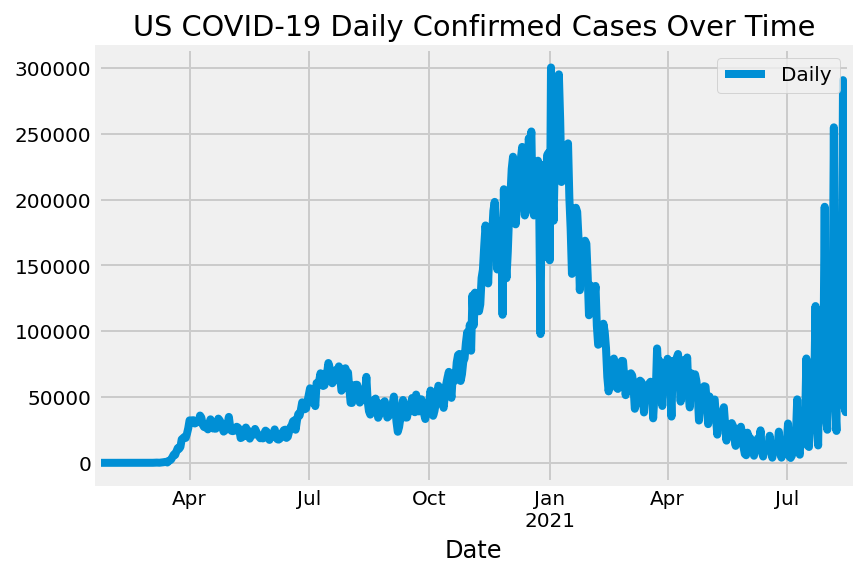

In [136]:
dr = confirmed_df[['Daily']]
dr.plot()
plt.title('US COVID-19 Daily Confirmed Cases Over Time');

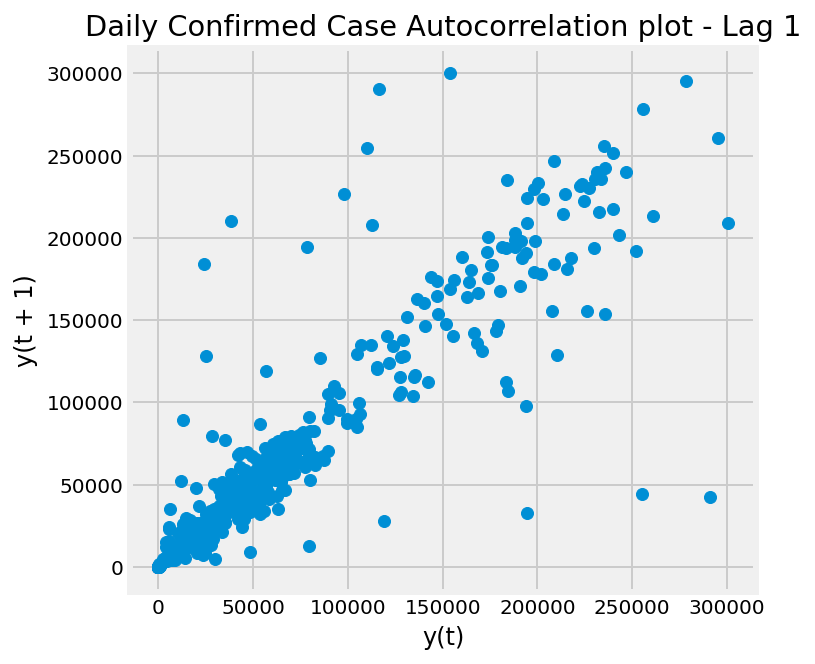

In [137]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['Daily'], lag=1)
plt.title('Daily Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets

In [138]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]

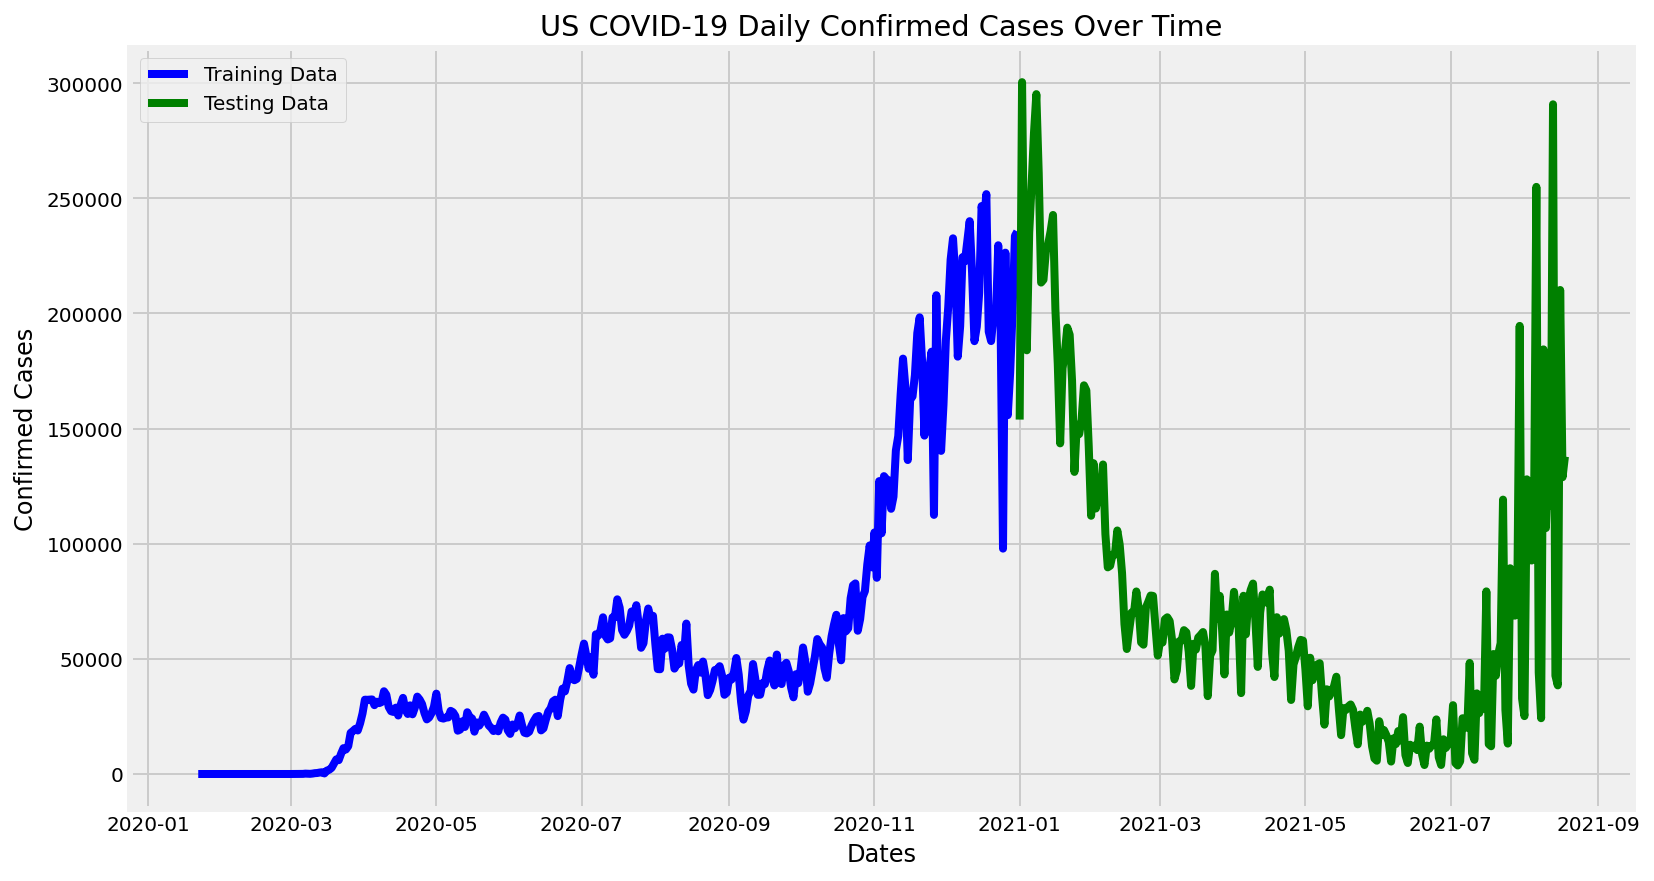

In [139]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

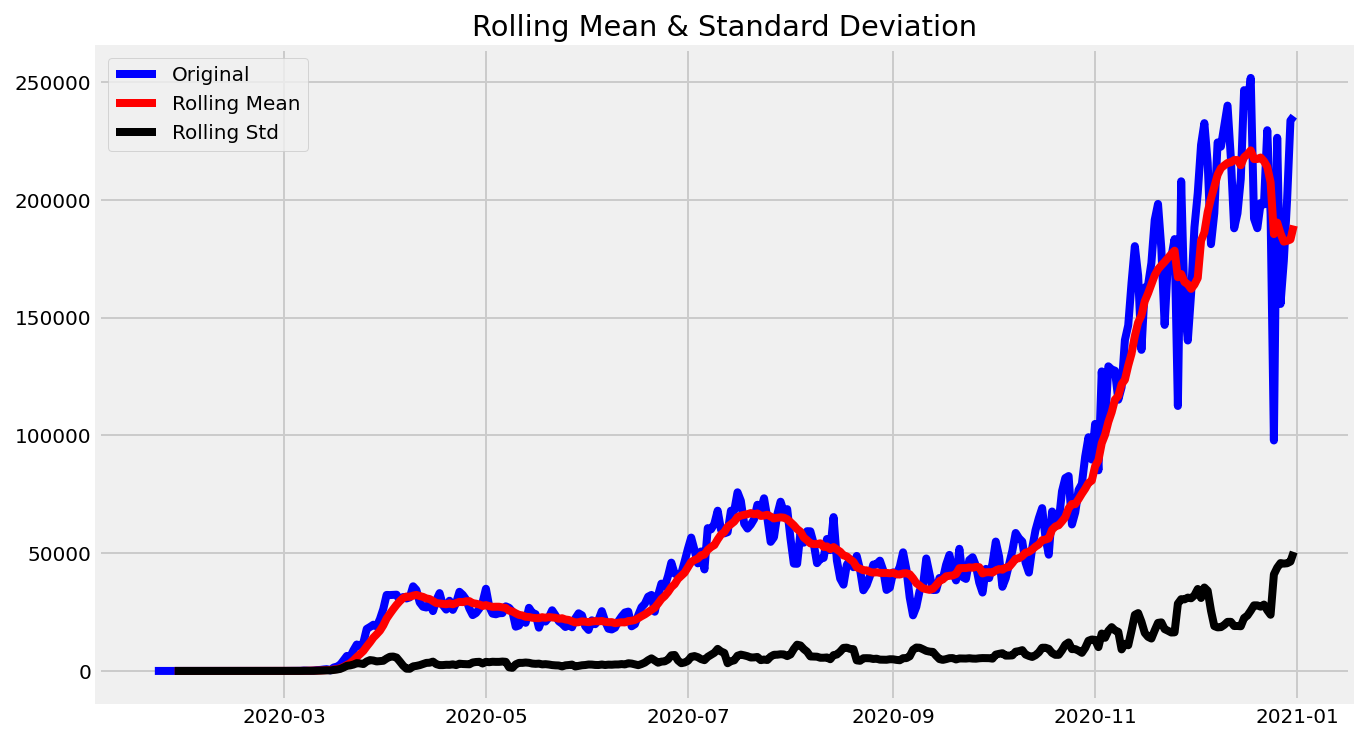

In [140]:
window = 7
train_series = train_data['Daily']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [141]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   0.090553
p-value                          0.965410
#Lags Used                      17.000000
Number of Observations Used    327.000000
Critical Value (1%)             -3.450507
Critical Value (5%)             -2.870420
Critical Value (10%)            -2.571501
dtype: float64

# Apply a first order differencing on the training data

In [142]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [143]:
train_diff

Date
2020-01-23       -1.0
2020-01-24        1.0
2020-01-25       -1.0
2020-01-26        3.0
2020-01-27       -3.0
               ...   
2020-12-27   -70571.0
2020-12-28    18307.0
2020-12-29    26256.0
2020-12-30    33293.0
2020-12-31     1899.0
Name: Daily, Length: 344, dtype: float64

# Visualize Rolling statistics for differenced train data

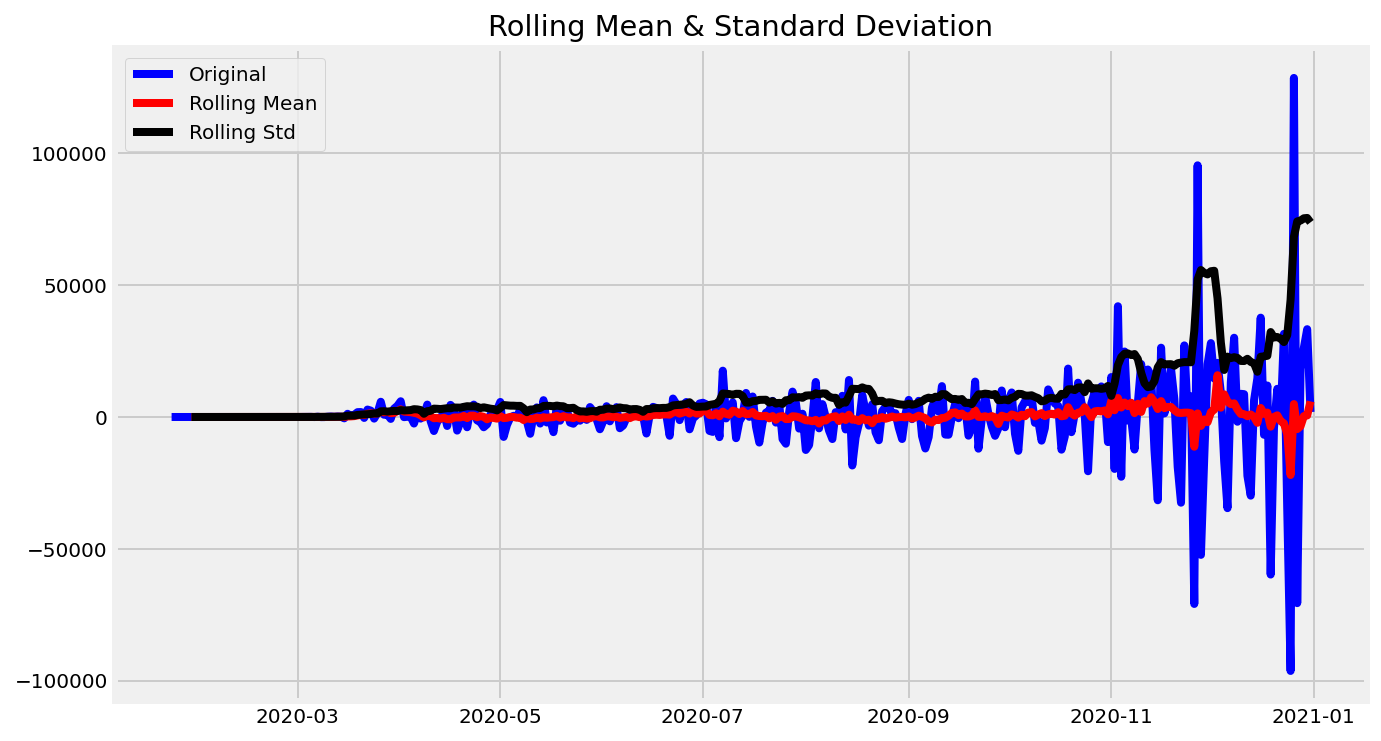

In [144]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [145]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -3.711415
p-value                          0.003955
#Lags Used                      17.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64

# Plot ACF and PACF on the original train series

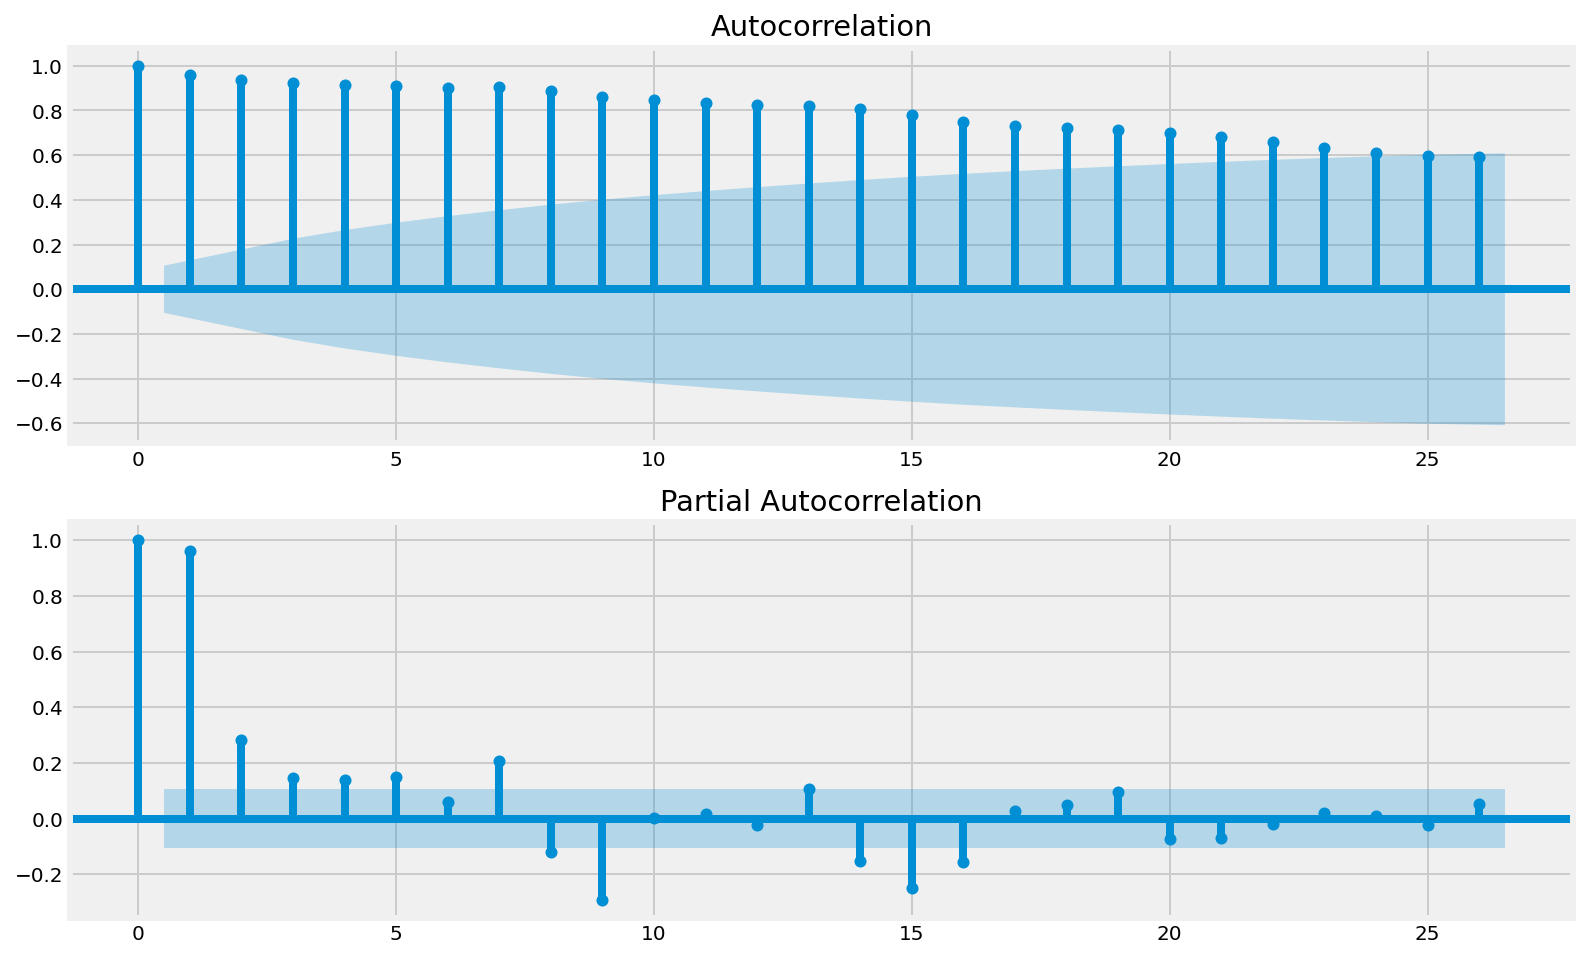

In [146]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

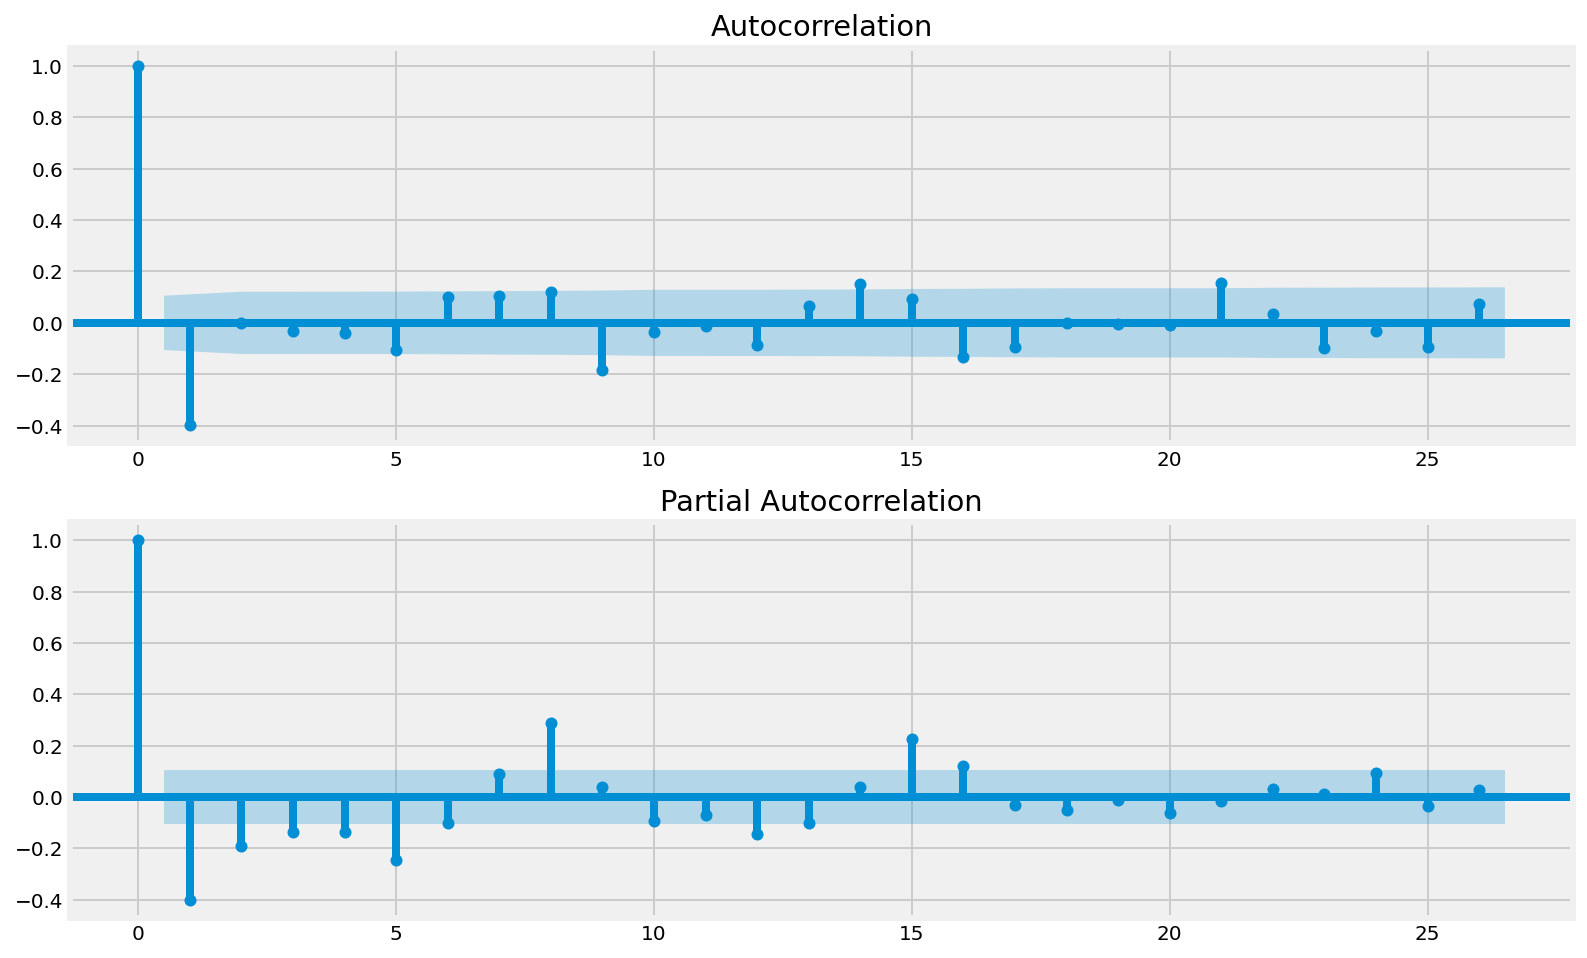

In [147]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [148]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [149]:
test_series = test_data['Daily']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-01-02    146546.0
2021-01-03    -91609.0
2021-01-04    -24848.0
2021-01-05     51037.0
2021-01-06     20595.0
                ...   
2021-08-14   -248133.0
2021-08-15     -4225.0
2021-08-16    171717.0
2021-08-17    -81297.0
2021-08-18      8913.0
Name: Daily, Length: 229, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [150]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [151]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(1,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=22114.75314040789, Expected=146546.0
Test Series Point: 100	Predicted=-17736.644029880492, Expected=23566.0
Test Series Point: 200	Predicted=20204.677333728017, Expected=9329.0
Wall time: 7.79 s


# Reverse Transform the forecasted values

In [152]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((230,), (230,))

# Evaluate model performance

In [153]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 3664544804.389
Symmetric Mean absolute percentage error: 69.268


In [154]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

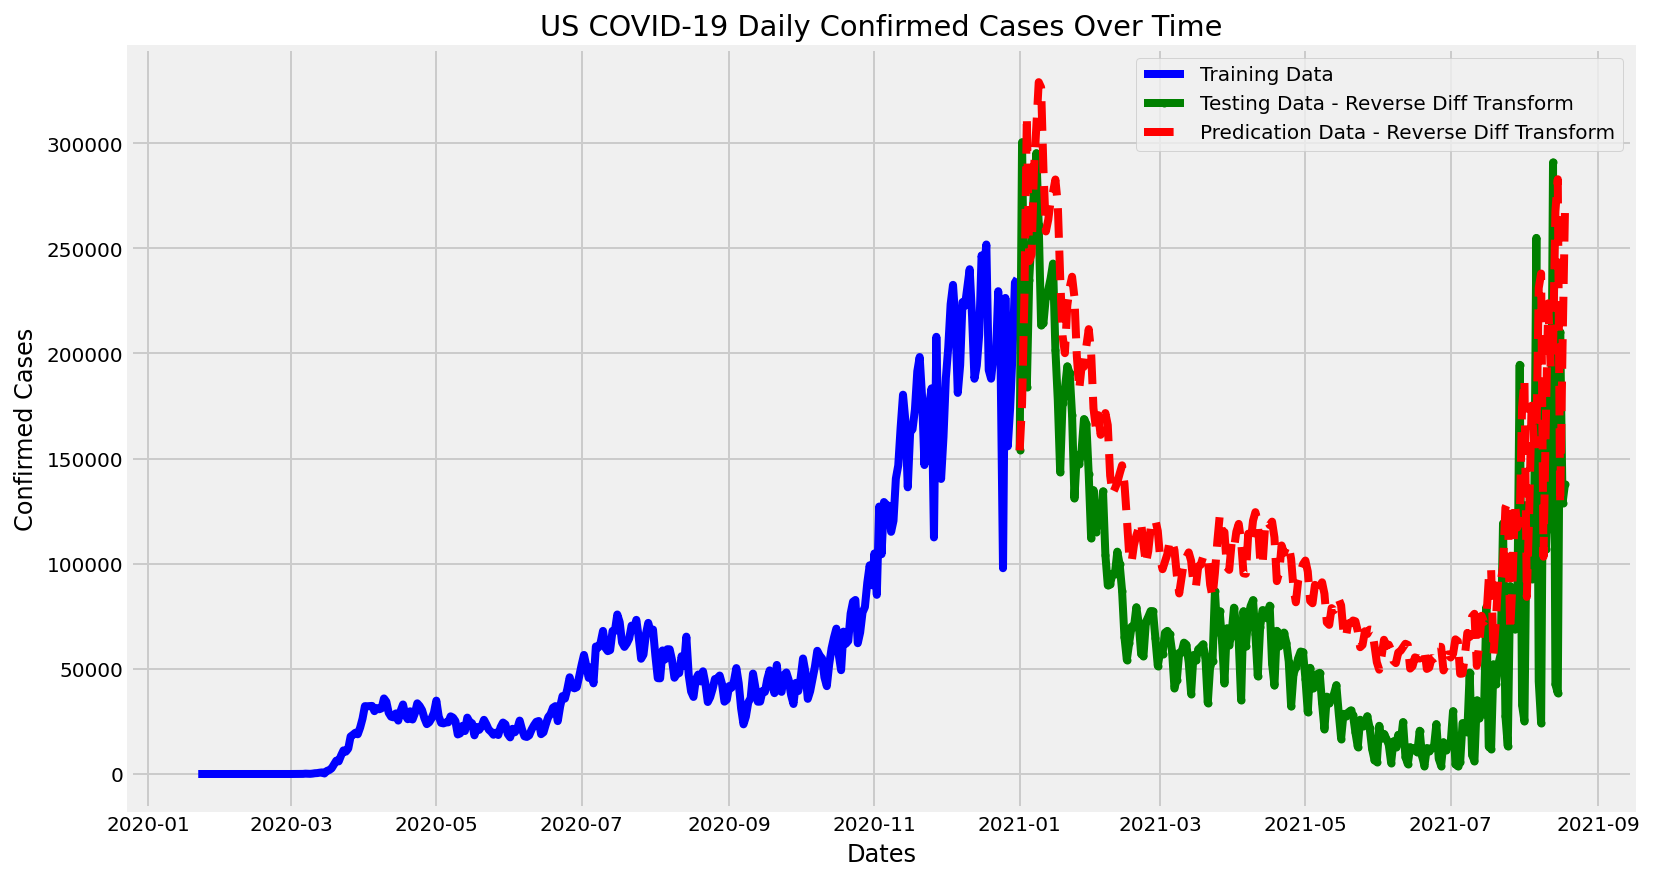

In [155]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and prediction results

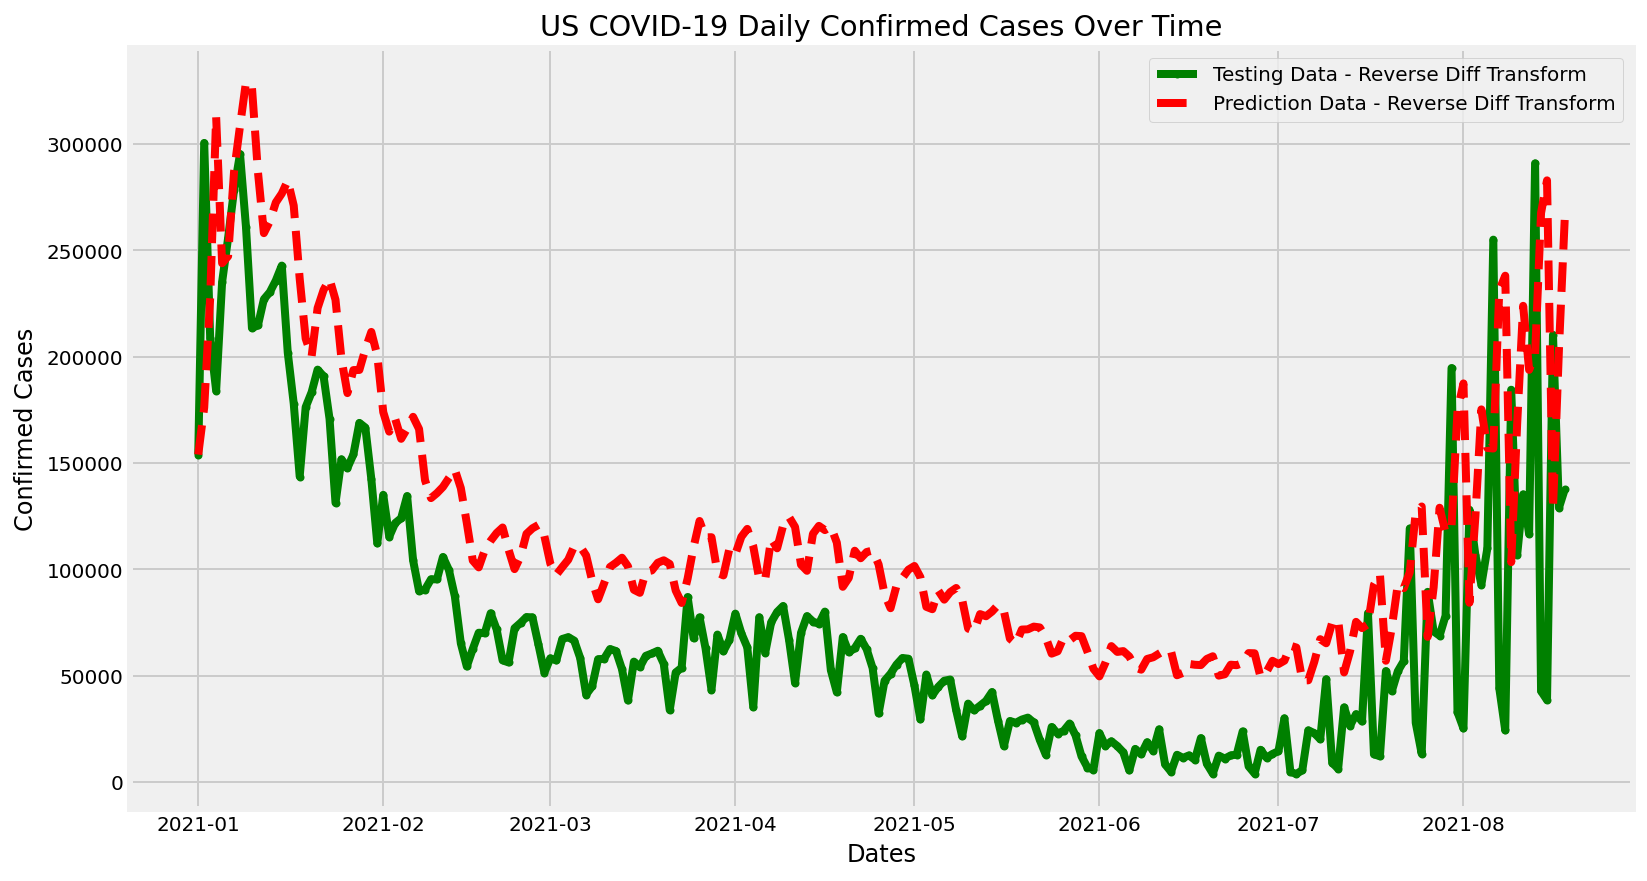

In [156]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Prediction Data - Reverse Diff Transform')
plt.legend();

# Generate forecasts

In [157]:
# Future predictions using ARIMA 
ARIMA_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'ARIMA Predicted # of US Daily Confirmed Cases': np.round(reverse_predictions_series[-10:])})
ARIMA_df.style.background_gradient(cmap='Reds')

In [158]:
ARIMA_df.reset_index(drop=True)

Future Date  ARIMA Predicted # of US Daily Confirmed Cases
0  08/19/2021                                       103327.0
1  08/20/2021                                       168555.0
2  08/21/2021                                       223859.0
3  08/22/2021                                       193747.0
4  08/23/2021                                       200972.0
5  08/24/2021                                       267543.0
6  08/25/2021                                       282866.0
7  08/26/2021                                       128187.0
8  08/27/2021                                       203646.0
9  08/28/2021                                       266808.0

# (4) Total Confirmed Cases Prediction- US

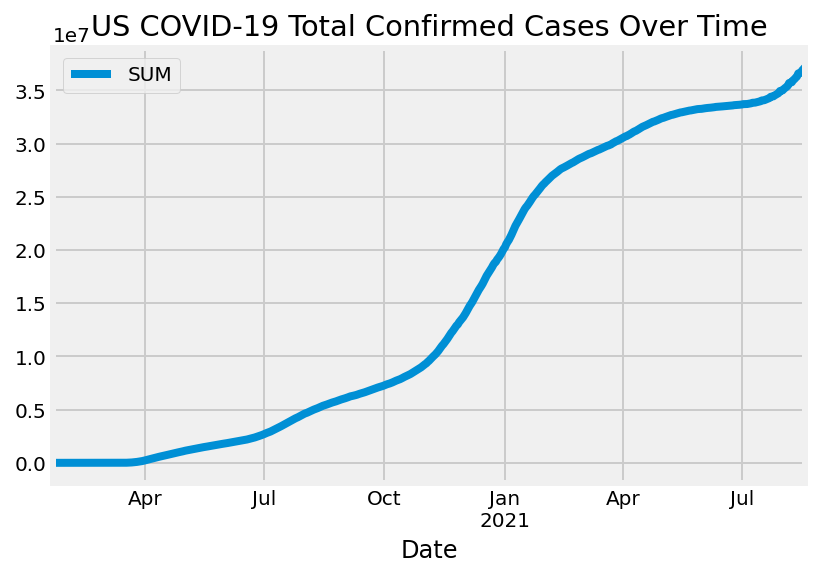

In [159]:
dr = confirmed_df[['SUM']]
dr.plot()
plt.title('US COVID-19 Total Confirmed Cases Over Time');

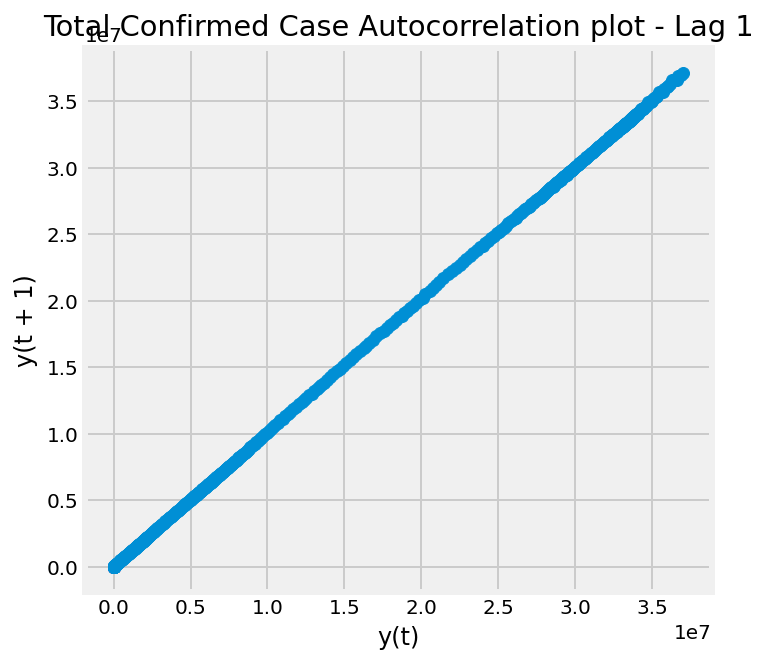

In [160]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['SUM'], lag=1)
plt.title('Total Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets

In [161]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]

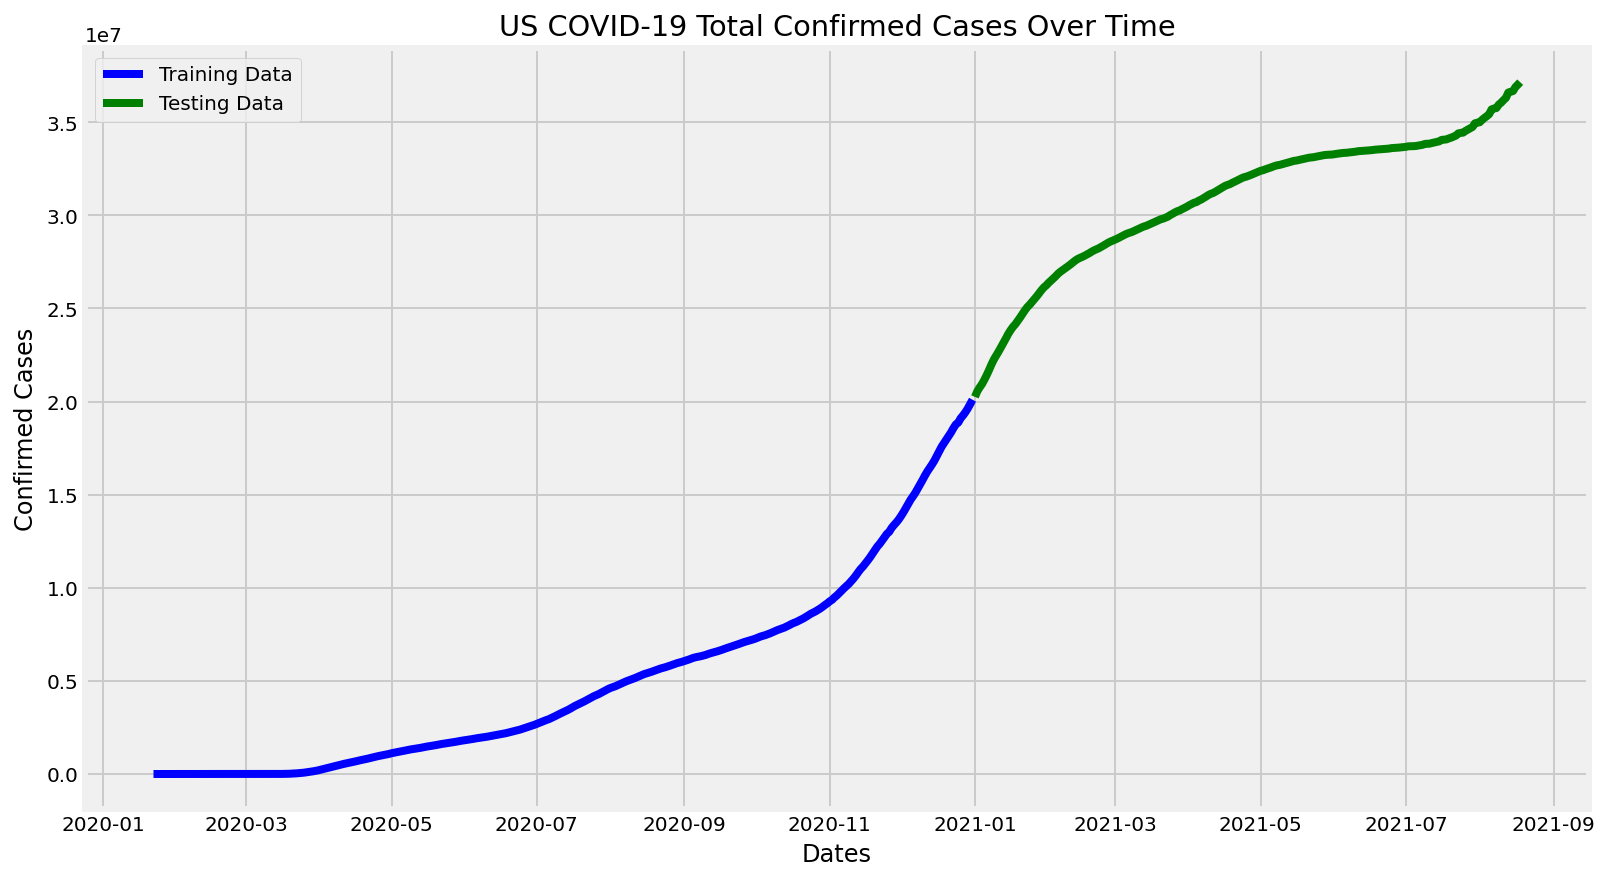

In [162]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['SUM'], 'blue', label='Training Data')
plt.plot(test_data['SUM'], 'green', label='Testing Data')
plt.legend();

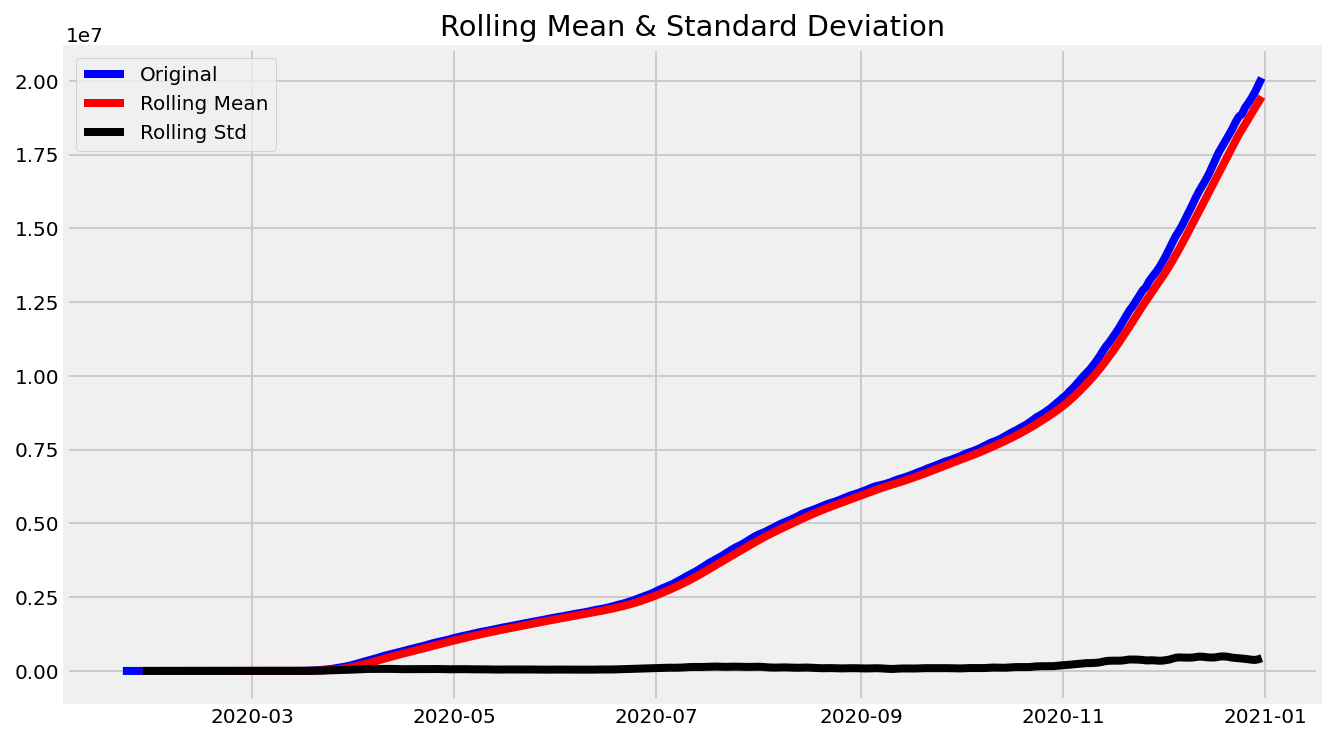

In [163]:
window = 7
train_series = train_data['SUM']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [164]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   2.377050
p-value                          0.998999
#Lags Used                      17.000000
Number of Observations Used    327.000000
Critical Value (1%)             -3.450507
Critical Value (5%)             -2.870420
Critical Value (10%)            -2.571501
dtype: float64

# Apply a first order differencing on the training data

In [165]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [166]:
train_diff

Date
2020-01-23         0.0
2020-01-24         1.0
2020-01-25         0.0
2020-01-26         3.0
2020-01-27         0.0
                ...   
2020-12-27    155845.0
2020-12-28    174152.0
2020-12-29    200408.0
2020-12-30    233701.0
2020-12-31    235600.0
Name: SUM, Length: 344, dtype: float64

# Visualize Rolling statistics for differenced train data

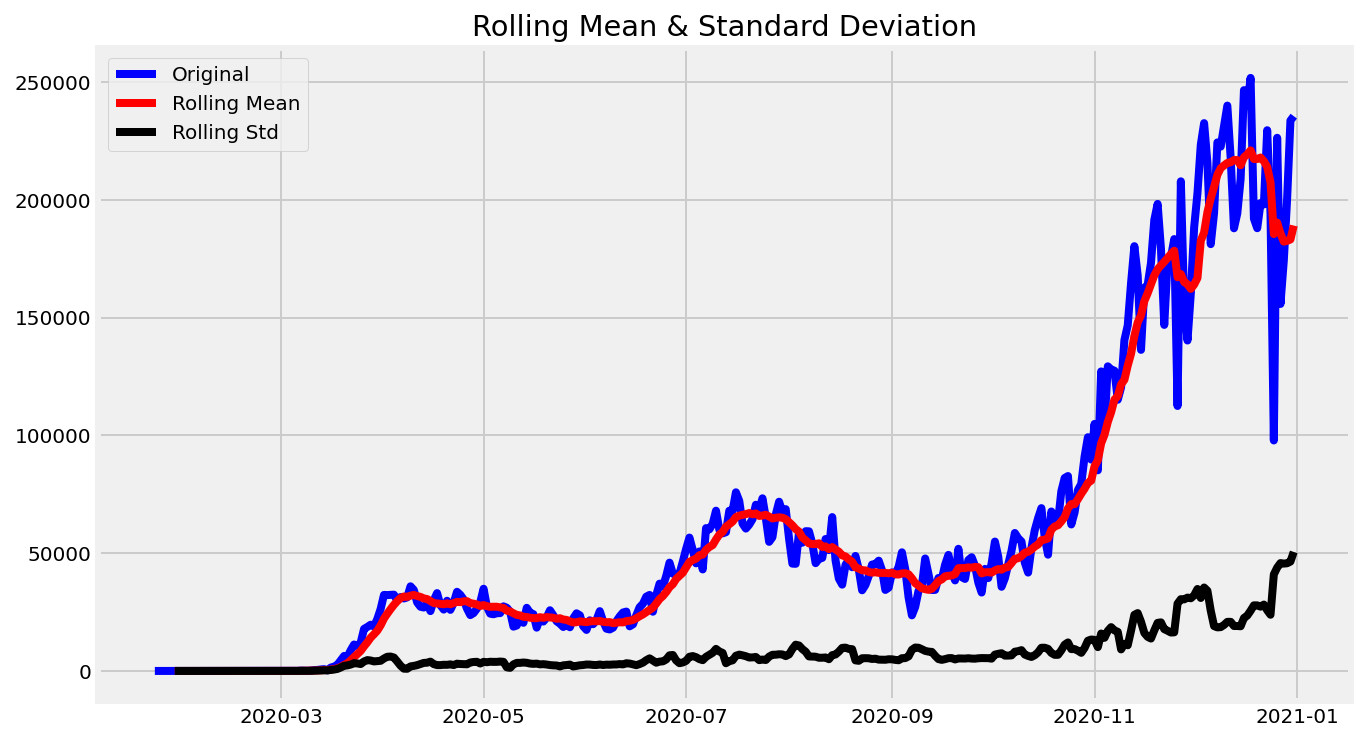

In [167]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [168]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   0.086094
p-value                          0.965099
#Lags Used                      17.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64

# Plot ACF and PACF on the original train series

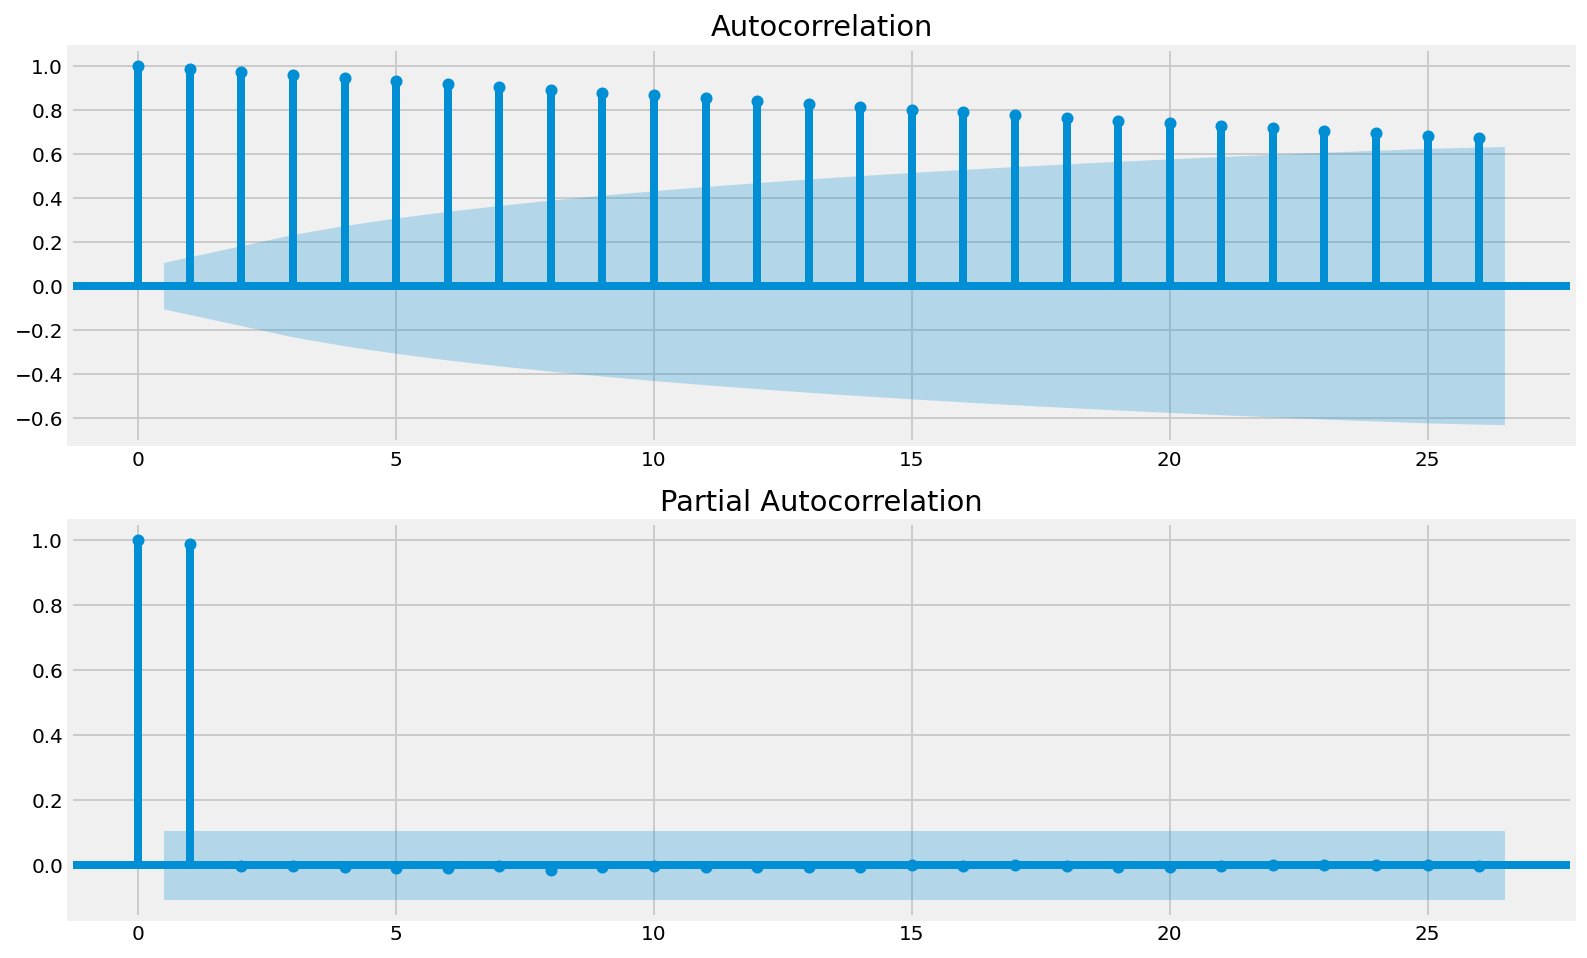

In [169]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

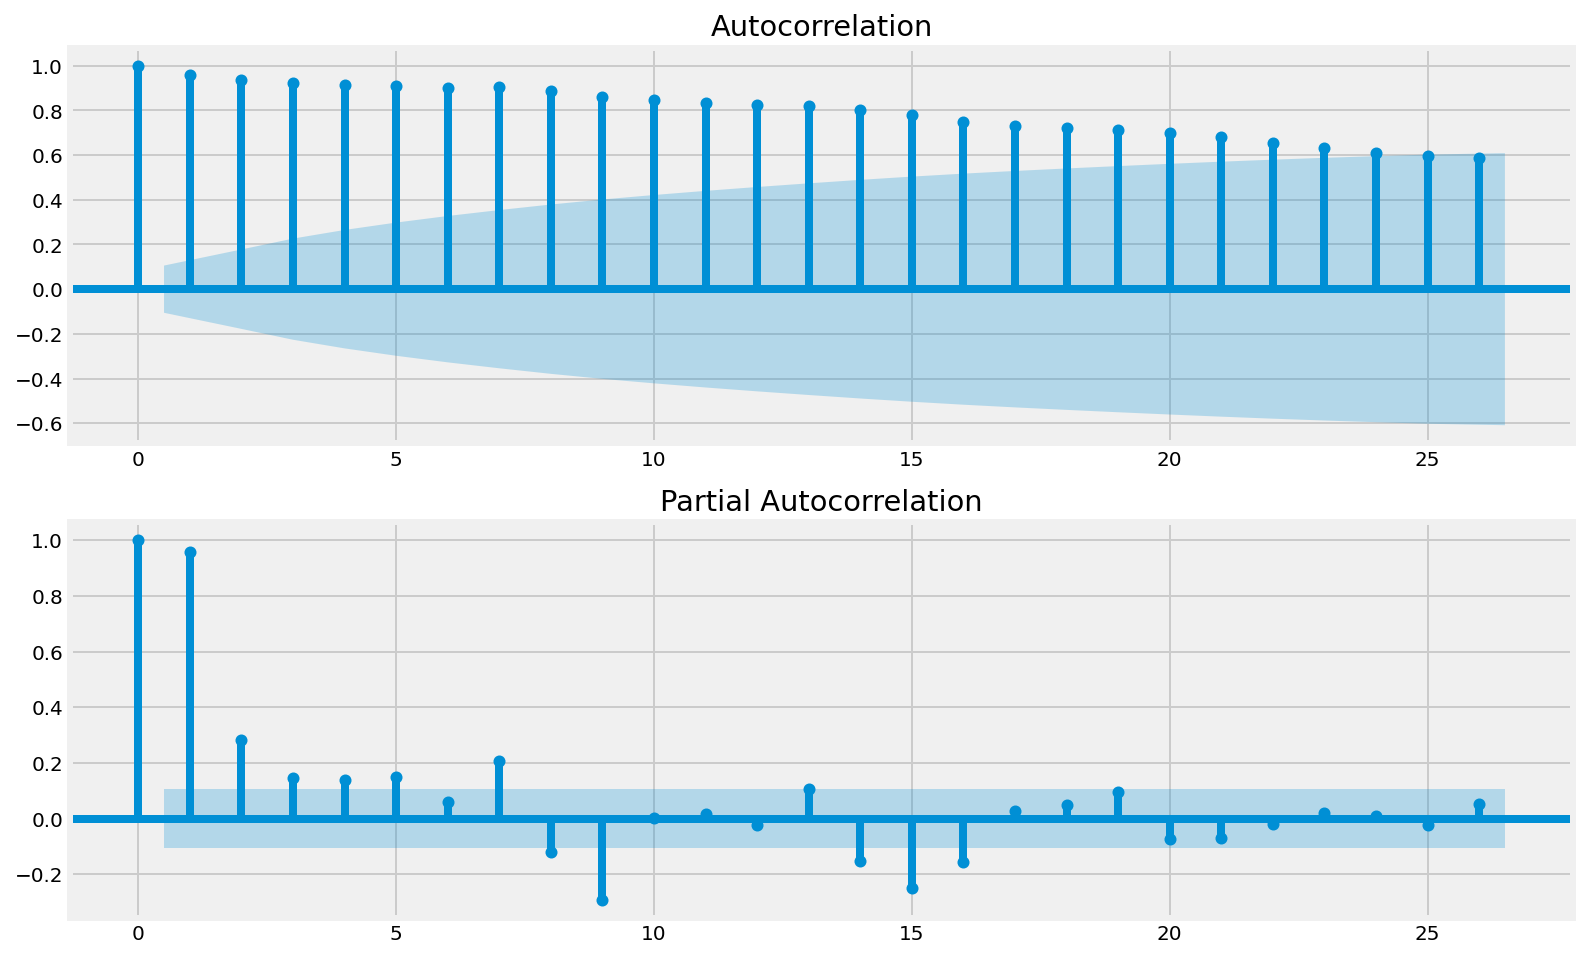

In [170]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [171]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [172]:
test_series = test_data['SUM']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-01-02    300462.0
2021-01-03    208853.0
2021-01-04    184005.0
2021-01-05    235042.0
2021-01-06    255637.0
                ...   
2021-08-14     42707.0
2021-08-15     38482.0
2021-08-16    210199.0
2021-08-17    128902.0
2021-08-18    137815.0
Name: SUM, Length: 229, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [173]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [174]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=229546.1238207626, Expected=300462.0
Test Series Point: 100	Predicted=53793.63466950951, Expected=70075.0
Test Series Point: 200	Predicted=37966.504150303845, Expected=52032.0
Wall time: 1min 13s


# Reverse Transform the forecasted values

In [175]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((230,), (230,))

# Evaluate model performance

In [176]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 269735515849.817
Symmetric Mean absolute percentage error: 1.525


In [177]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

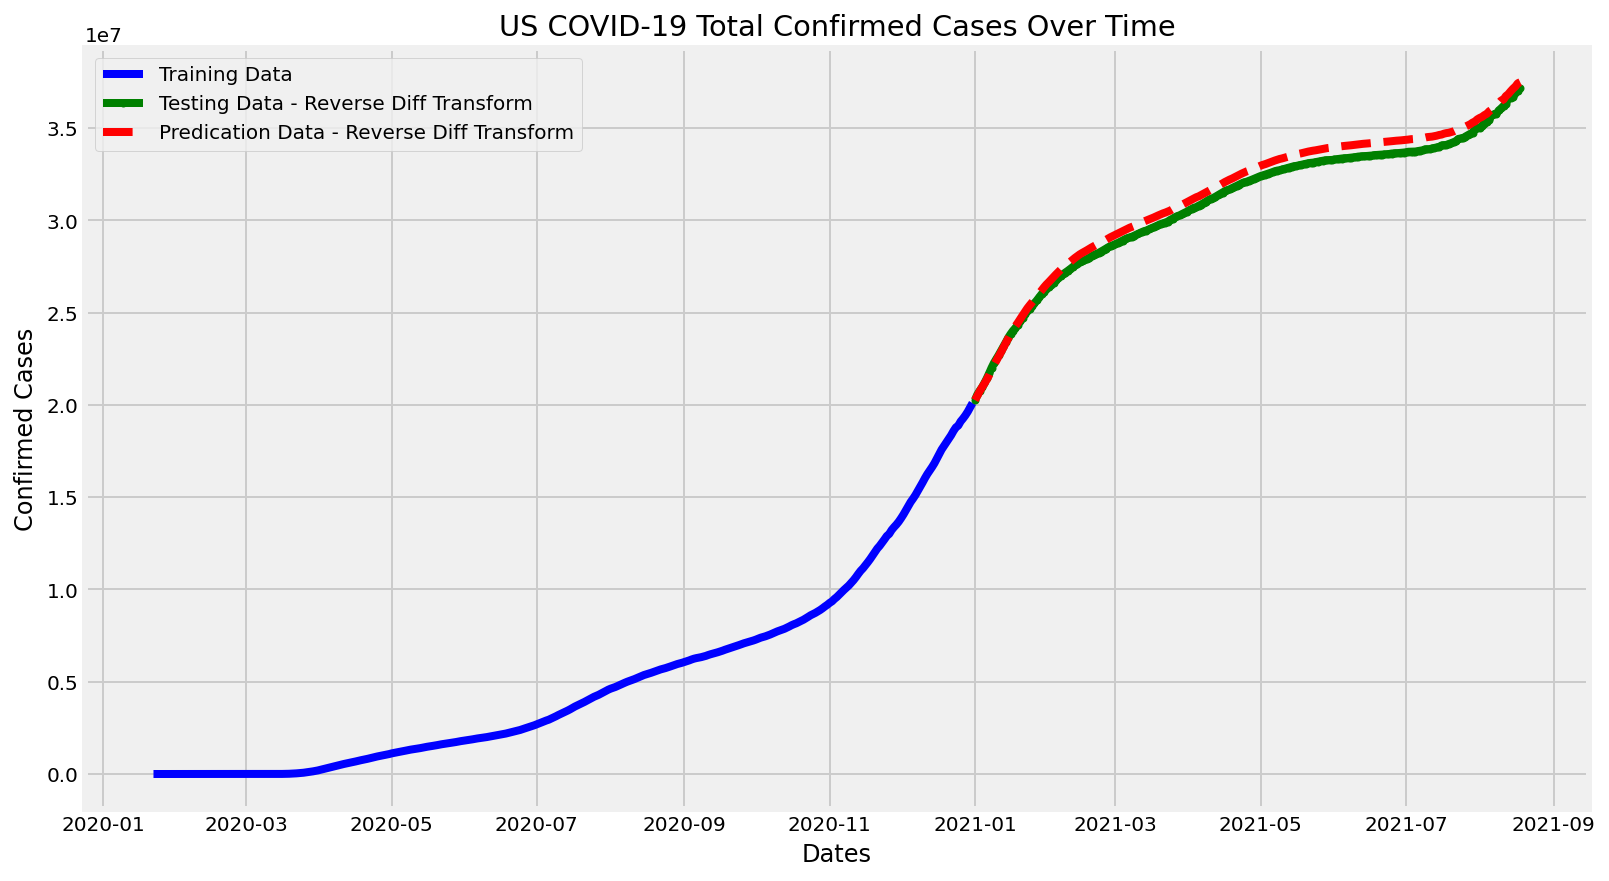

In [178]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and forecast prices

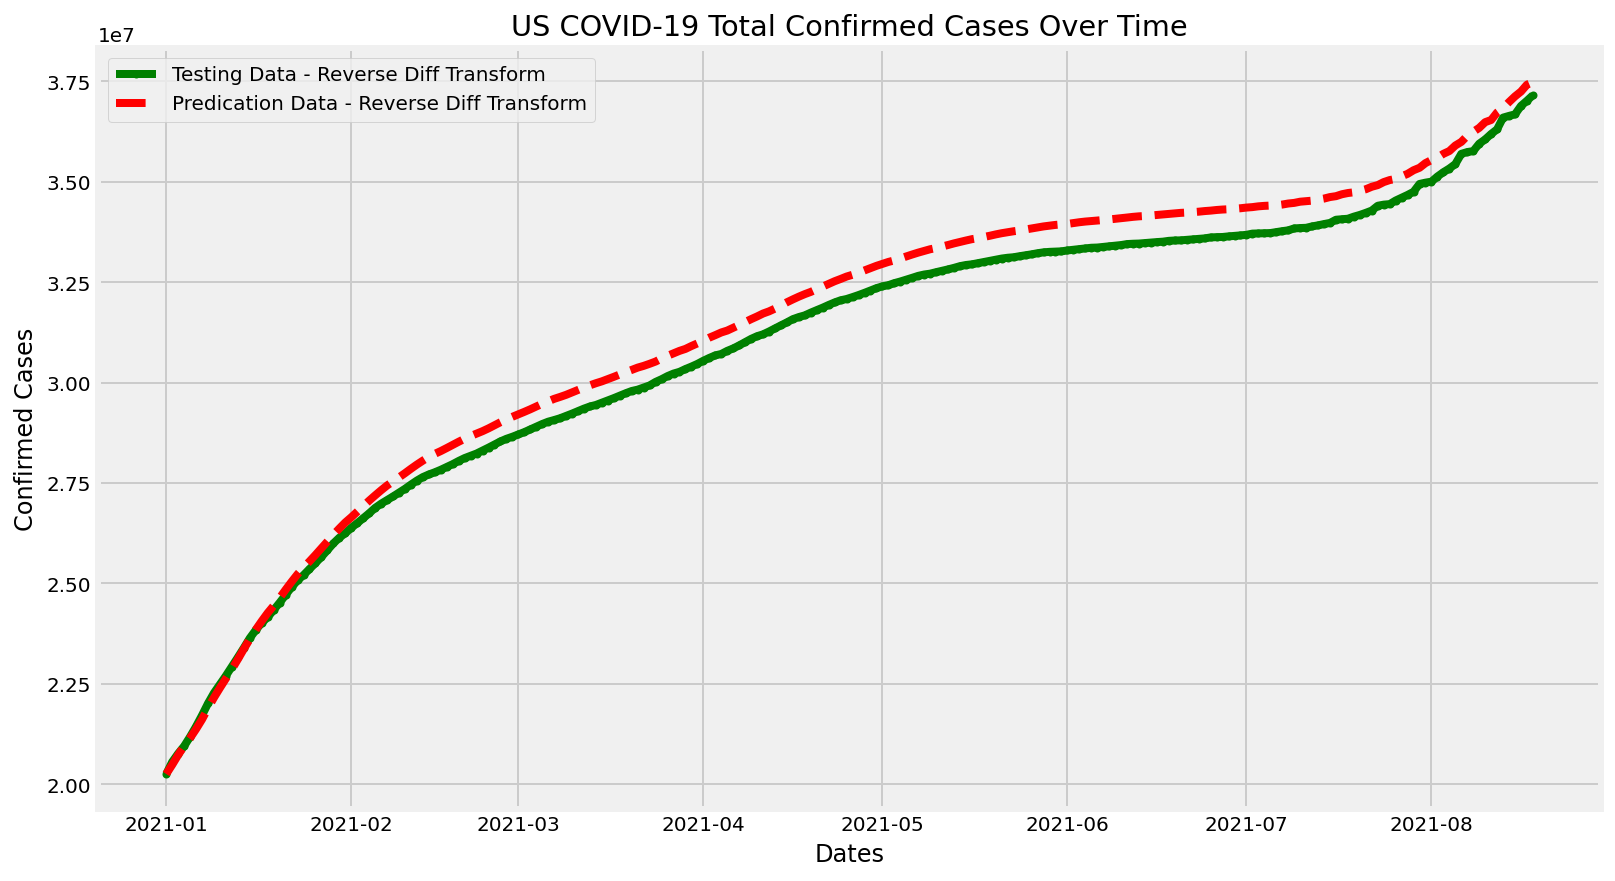

In [179]:
plt.figure(figsize=(12,7))
plt.title('US COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Predication Data - Reverse Diff Transform')
plt.legend();

# Generate forecasts

In [180]:
# Future predictions using ARIMA 
ARIMA_df = pd.DataFrame({'Future Date': future_forcast_dates[-10:], 'ARIMA Predicted # of US Total Confirmed Cases': np.round(reverse_predictions_series[-10:])})
ARIMA_df.style.background_gradient(cmap='Reds')

In [181]:
ARIMA_df.reset_index(drop=True)

Future Date  ARIMA Predicted # of US Total Confirmed Cases
0  08/19/2021                                     36342802.0
1  08/20/2021                                     36484462.0
2  08/21/2021                                     36538662.0
3  08/22/2021                                     36726011.0
4  08/23/2021                                     36831856.0
5  08/24/2021                                     36986258.0
6  08/25/2021                                     37127068.0
7  08/26/2021                                     37246802.0
8  08/27/2021                                     37417993.0
9  08/28/2021                                     37480633.0

# IV. Conclusion

Deep Learnig Time Series-ARIMA model produces most accurate predication results compared to traditional Machine Learning models in both Daily new confirmed cases and total accumulated cases.

Using 1st year data to train and 2nd year data to test generates best prediction results. Continously train LSTM model can reduce the gap between Forecast and Test curve. Same predication model and feature parameters could be scaled up to US data sets from CA.

Total 3 major peaks occurred in 2020-8, 2021-1,2021-9. Winter peak is higher than summer time. Similar pattern was shown in CA and US data sets. CA showed much lower 3rd peak than US which was probably due to Vaccination effect. Virus strain, lockdown, vaccination, season, Holiday gathering and regional corelation could be deeply investigated in the future. 

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
